# GoodDealDetector: Finding Houses with High Flipping Potential

## A tool to narrow searches for profitable real estate flips, simulate ROI from renovations, and help homeowners value their homes.

### Project Goal
This notebook goes beyond a standard price prediction. The project is split into two phases:
1.  **Regression:** We first build and tune a robust `XGBoost` model to accurately predict the "intrinsic value" of a house based on its features.
2.  **Classification:** We then use this regression model to engineer a new target variable: `Flipping_Potential`. We build a classifier to see if we can predict which properties are undervalued, have high renovation potential, and are in an area with high demand.

### Project Links
This notebook contains the full code. For a high-level overview of the business case and methodology, please see the links below.

* **Full Documentation:** [**README.md**](README.md)
* **Business Summary Article:** [**LinkedIn Article**](YOUR_LINKEDIN_ARTICLE_URL)

# 1. Importing Dataset & Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
#importing dataset
df = pd.read_csv('AmesHousing.csv')
pd.set_option("display.max_columns", None)
df.head()


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,NaN,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


# 2. Exploratory Data Analysis

- get an understanding of the data 
- get an idea of what to do with certain columns

In [3]:
from sklearn.model_selection import train_test_split

#train test split to avoid any learning from the test data
X = df.drop(['PID', 'Order', 'SalePrice'], axis=1)
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

df_train = pd.concat([X_train, y_train], axis=1)

- broad EDA

In [4]:
df.describe(include=object)

,MS Zoning,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating,Heating QC,Central Air,Electrical,Kitchen Qual,Functional,Fireplace Qu,Garage Type,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Pool QC,Fence,Misc Feature,Sale Type,Sale Condition
count,2930,2930,198,2930,2930,2930,2930,2930,2930,2930,2930,2930,2930,2930,2930,2930,2930,1155,2930,2930,2930,2850,2850,2847,2850,2849,2930,2930,2930,2929,2930,2930,1508,2773,2771,2771,2771,2930,13,572,106,2930,2930
unique,7,2,2,4,4,3,5,3,28,9,8,5,8,6,8,16,17,4,4,5,6,5,5,4,6,6,6,5,2,5,5,8,5,6,3,5,5,3,4,4,5,10,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,TA,TA,PConc,TA,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
freq,2273,2918,120,1859,2633,2927,2140,2789,443,2522,2900,2425,1481,2321,2887,1026,1015,880,1799,2549,1310,1283,2616,1906,859,2499,2885,1495,2734,2682,1494,2728,744,1731,1231,2615,2665,2652,4,330,95,2536,2413


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

In [6]:
df.select_dtypes(include=int).describe()

,Order,PID,MS SubClass,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2930.00000,2.930000e+03,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000
mean,1465.50000,7.144645e+08,57.387372,10147.921843,6.094881,5.563140,1971.356314,1984.266553,1159.557679,335.455973,4.676792,1499.690444,1.566553,0.379522,2.854266,1.044369,6.443003,0.599317,93.751877,47.533447,23.011604,2.592491,16.002048,2.243345,50.635154,6.216041,2007.790444,180796.060068
std,845.96247,1.887308e+08,42.638025,7880.017759,1.411026,1.111537,30.245361,20.860286,391.890885,428.395715,46.310510,505.508887,0.552941,0.502629,0.827731,0.214076,1.572964,0.647921,126.361562,67.483400,64.139059,25.141331,56.087370,35.597181,566.344288,2.714492,1.316613,79886.692357
min,1.00000,5.263011e+08,20.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,733.25000,5.284770e+08,20.000000,7440.250000,5.000000,5.000000,1954.000000,1965.000000,876.250000,0.000000,0.000000,1126.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129500.000000
50%,1465.50000,5.354536e+08,50.000000,9436.500000,6.000000,5.000000,1973.000000,1993.000000,1084.000000,0.000000,0.000000,1442.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000
75%,2197.75000,9.071811e+08,70.000000,11555.250000,7.000000,6.000000,2001.000000,2004.000000,1384.000000,703.750000,0.000000,1742.750000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213500.000000
max,2930.00000,1.007100e+09,190.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,5095.000000,2065.000000,1064.000000,5642.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


In [7]:
df.select_dtypes(include=object).describe().T

,count,unique,top,freq
MS Zoning,2930,7,RL,2273
Street,2930,2,Pave,2918
Alley,198,2,Grvl,120
Lot Shape,2930,4,Reg,1859
Land Contour,2930,4,Lvl,2633
Utilities,2930,3,AllPub,2927
Lot Config,2930,5,Inside,2140
Land Slope,2930,3,Gtl,2789
Neighborhood,2930,28,NAmes,443
Condition 1,2930,9,Norm,2522


- vizualizing and transforming target variable

<Axes: xlabel='SalePrice', ylabel='Count'>

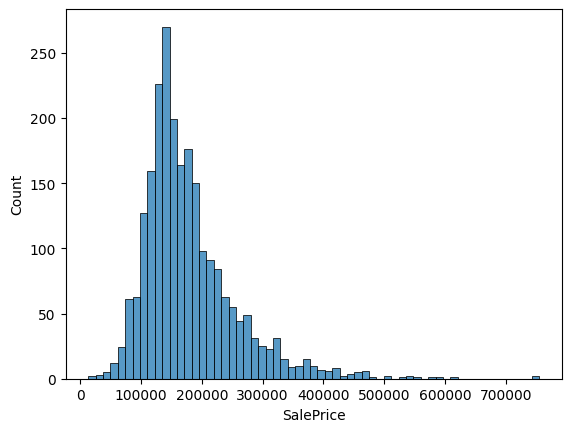

In [8]:
#vizualizing target (for the regression task)
sns.histplot(y_train)


In [9]:
#the target variable has a long right tail - we should log transform the data
df.describe()['SalePrice']

count      2930.000000
mean     180796.060068
std       79886.692357
min       12789.000000
25%      129500.000000
50%      160000.000000
75%      213500.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [10]:
#log transforming it can increase model accuracy by making the effect of outliers proportional.
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

<Axes: xlabel='SalePrice', ylabel='Count'>

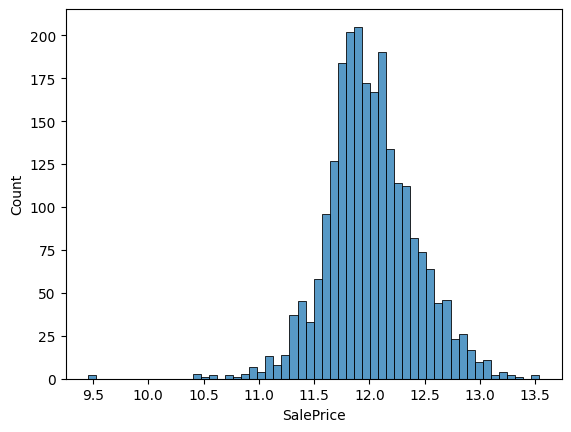

In [11]:
#a viz of the transformed target
sns.histplot(y_train_log)

In [12]:
y_train.sort_values(ascending=True)

181      12789
1553     13100
726      34900
2843     35000
2880     35311
         ...  
2450    584500
1637    591587
1063    615000
1760    745000
1767    755000
Name: SalePrice, Length: 2344, dtype: int64

In [13]:
#let's ensure all sales happened at around the same time so we don't have to adjust anything for inflation
df['Yr Sold'].value_counts()

Yr Sold
2007    694
2009    648
2006    625
2008    622
2010    341
Name: count, dtype: int64

In [14]:
#linear correlation of continuous variables with the target
df_train.corr(numeric_only=True)['SalePrice'].sort_values(ascending=False)


SalePrice          1.000000
Overall Qual       0.795298
Gr Liv Area        0.698315
Garage Cars        0.644304
Garage Area        0.633106
Total Bsmt SF      0.612256
1st Flr SF         0.607433
Year Built         0.545409
Full Bath          0.542053
Year Remod/Add     0.517653
Garage Yr Blt      0.516211
Mas Vnr Area       0.490912
TotRms AbvGrd      0.475455
Fireplaces         0.467501
BsmtFin SF 1       0.423906
Wood Deck SF       0.333045
Lot Frontage       0.328726
Open Porch SF      0.297722
Bsmt Full Bath     0.286515
Half Bath          0.285369
2nd Flr SF         0.278977
Lot Area           0.261336
Bsmt Unf SF        0.163571
Bedroom AbvGr      0.149269
Screen Porch       0.136936
Pool Area          0.079020
3Ssn Porch         0.034845
Mo Sold            0.030714
BsmtFin SF 2       0.027205
Low Qual Fin SF   -0.016025
Misc Val          -0.017729
Bsmt Half Bath    -0.023675
Yr Sold           -0.037686
MS SubClass       -0.066351
Overall Cond      -0.104085
Kitchen AbvGr     -0

In [15]:
#let's also viz missing values
print(X_train.shape)
X_train.isna().sum().sort_values(ascending=False)

(2344, 79)


Pool QC           2332
Misc Feature      2250
Alley             2182
Fence             1874
Mas Vnr Type      1426
                  ... 
Central Air          0
Electrical           0
1st Flr SF           0
2nd Flr SF           0
Sale Condition       0
Length: 79, dtype: int64

# 3. Vizualizing High-Impact Features:
- how does location impact sale price?
- how has the market changed year to year?
- how has the volume of homes sold changed each year?
- how much resale value do renovations actually bring?
- quantifying key features (kitchens, bathrooms, etc.)
- is sale price seasonal?
- `Overall Qual` as a key predictor of sale price

## How does location impact sale price?

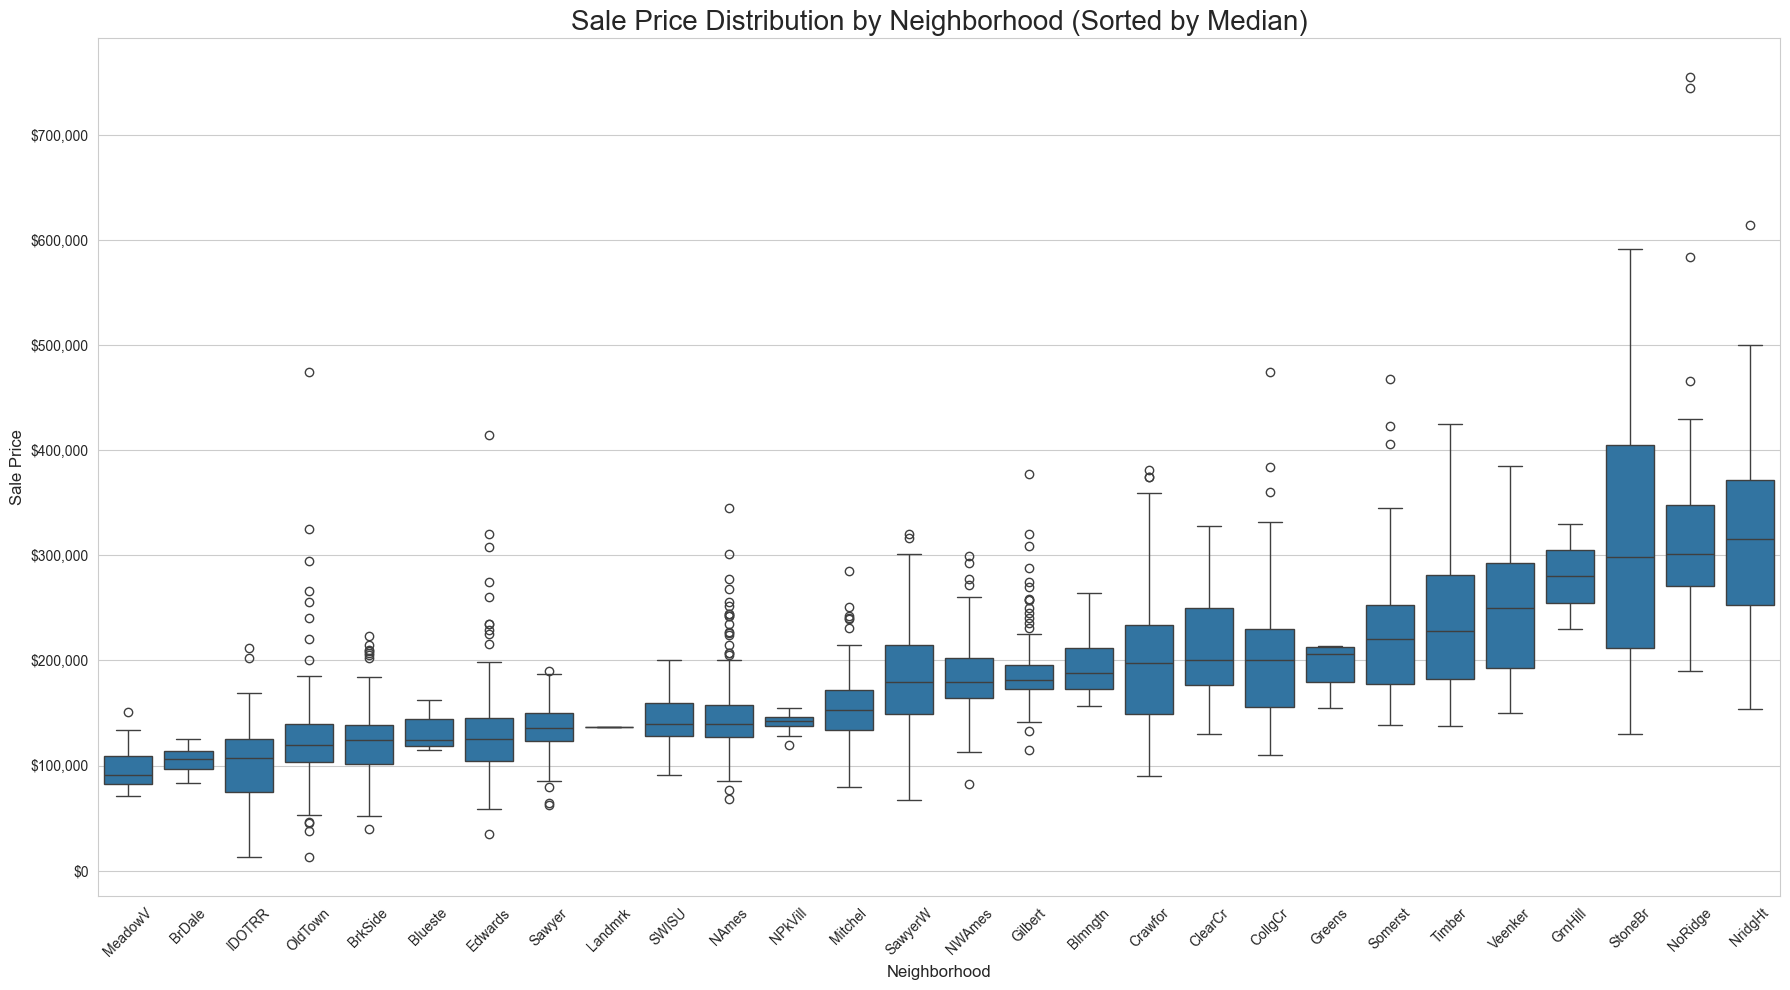

In [16]:
#sns.set_style("whitegrid")
from matplotlib.ticker import StrMethodFormatter

sns.set_style('whitegrid')

plt.figure(figsize=(18, 10))

#define order
median_prices = df_train.groupby('Neighborhood')['SalePrice'].median().sort_values()
sorted_neighborhood_list = median_prices.index

#plot
ax = sns.boxplot(
    x='Neighborhood', 
    y='SalePrice', 
    data=df_train, 
    order=sorted_neighborhood_list
)

#display $
formatter = StrMethodFormatter('${x:,.0f}')
ax.yaxis.set_major_formatter(formatter)

#titles and labels
ax.set_title('Sale Price Distribution by Neighborhood (Sorted by Median)', fontsize=20)

ax.set_ylabel('Sale Price', fontsize=12)
ax.set_xlabel('Neighborhood', fontsize=12)

plt.xticks(rotation=45)

plt.tight_layout()


Neighborhood has a huge impact on sale price, with neighborhoods like Meadow Village and Briardale averaging a $100k sale price, while Northridge and Northridge Heights average $300k

## How has the market changed year-to-year?

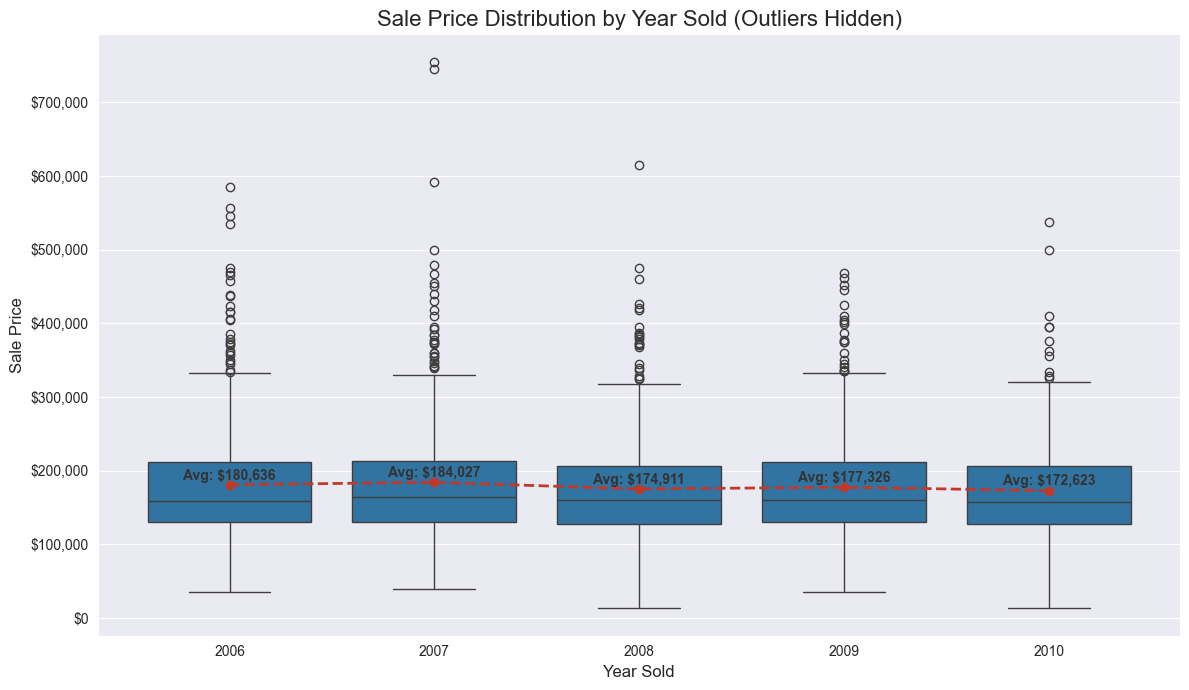

In [17]:
sns.set_style("darkgrid")

plt.figure(figsize=(12, 7))

ax = sns.boxplot(
    x='Yr Sold', 
    y='SalePrice', 
    data=df_train,
)

mean_prices = df_train.groupby('Yr Sold')['SalePrice'].mean()

tick_locs = ax.get_xticks()

ax.plot(
    ax.get_xticks(), 
    mean_prices,
    color='#c0392b',
    marker='o',    
    linestyle='--',
    linewidth=2
)

for i, year in enumerate(mean_prices.index):
    
    mean_val = mean_prices.loc[year]
    
    ax.text(
        x=i,
        y=mean_val + 3000,
        s=f'Avg: ${mean_val:,.0f}',
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold',
        color='#333333'
    )

formatter = StrMethodFormatter('${x:,.0f}')
ax.yaxis.set_major_formatter(formatter)

# Set clean title and labels
ax.set_title('Sale Price Distribution by Year Sold (Outliers Hidden)', fontsize=16)
ax.set_ylabel('Sale Price', fontsize=12)
ax.set_xlabel('Year Sold', fontsize=12)

# 5. Show the plot
plt.tight_layout()
plt.show()



Surprisingly, the average sale price barely moved in Ames between 2007 and 2009. This suggests the local market was highly insulated from the national crash - despite national panic, Ames had local stability.

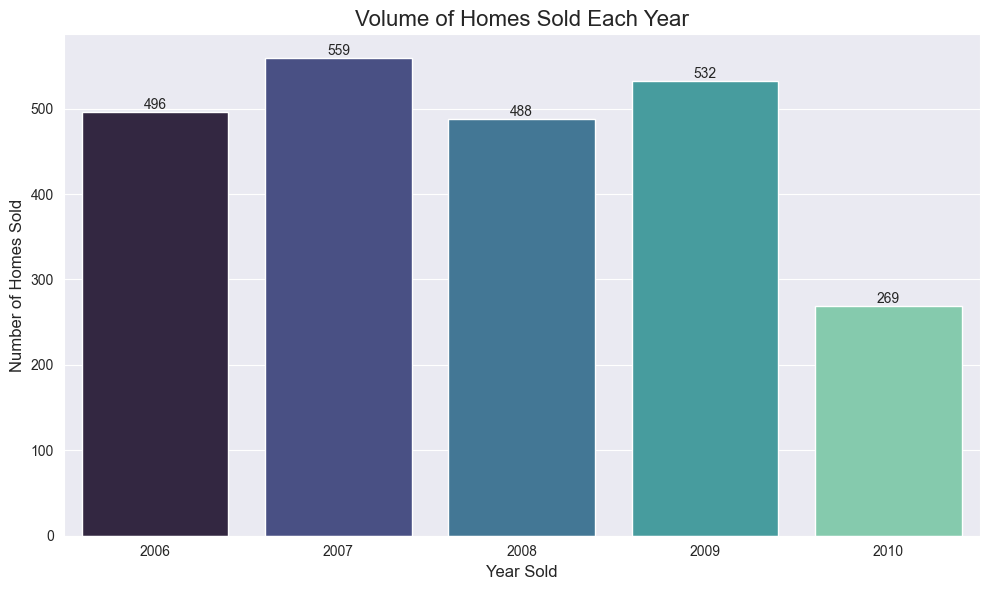

In [18]:
sns.set_style("darkgrid")

plt.figure(figsize=(10, 6))

ax = sns.countplot(
    x='Yr Sold', 
    data=df_train,
    palette='mako'
)

for container in ax.containers:
    ax.bar_label(container, fontsize=10)

ax.set_title('Volume of Homes Sold Each Year', fontsize=16)
ax.set_ylabel('Number of Homes Sold', fontsize=12)
ax.set_xlabel('Year Sold', fontsize=12)

ax.get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, p: format(int(x), ','))
)

# 6. Show the plot
plt.tight_layout()
plt.show()

The crash of 2008 did negatively impact the amount of homes sold in Ames in 2008 however, dropping by close to 15%. The great decrease in demand is alarming in 2010 however, though this could be due to a data collection cutoff.

## How much resale value do renovations actually bring?

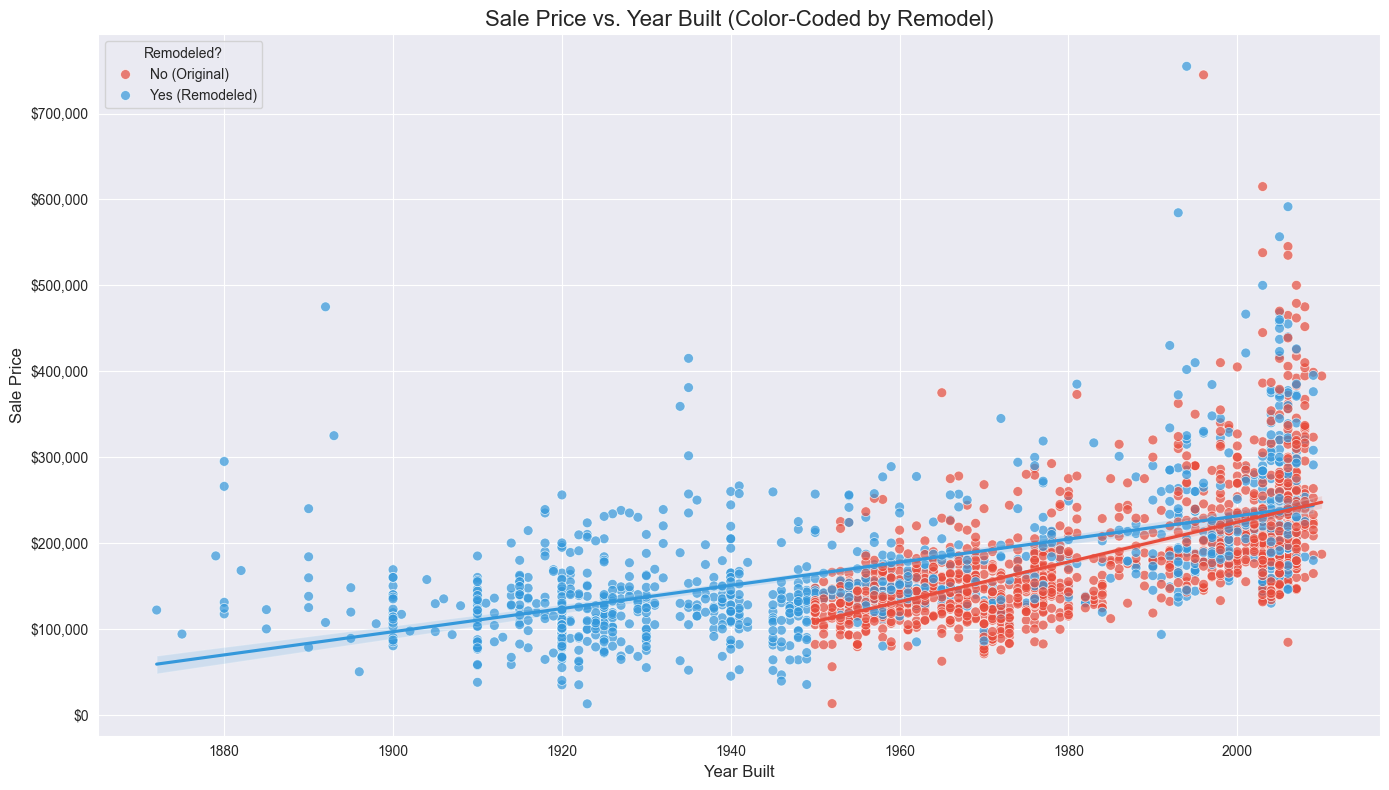

In [19]:
df_viz = df_train.copy()

df_viz['AgeAtSale'] = df_viz['Yr Sold'] - df_viz['Year Built']
df_viz['TimeSinceRemod'] = df_viz['Yr Sold'] - df_viz['Year Remod/Add']

df_viz['Was Remodeled'] = np.where(
    df_viz['TimeSinceRemod'] < df_viz['AgeAtSale'], 
    'Yes (Remodeled)', 
    'No (Original)'
)

sns.set_style("darkgrid")
plt.figure(figsize=(14, 8))

ax = sns.scatterplot(
    x='Year Built',
    y='SalePrice',
    data=df_viz,
    hue='Was Remodeled',  
    palette={'Yes (Remodeled)': '#3498db', 'No (Original)': '#e74c3c'},
    alpha=0.7,
    s=50
)

sns.regplot(
    x='Year Built', y='SalePrice', data=df_viz[df_viz['Was Remodeled'] == 'Yes (Remodeled)'],
    scatter=False, ax=ax, label=None, color='#3498db'
)
sns.regplot(
    x='Year Built', y='SalePrice', data=df_viz[df_viz['Was Remodeled'] == 'No (Original)'],
    scatter=False, ax=ax, label=None, color='#e74c3c'
)

formatter = StrMethodFormatter('${x:,.0f}')
ax.yaxis.set_major_formatter(formatter)

ax.set_title('Sale Price vs. Year Built (Color-Coded by Remodel)', fontsize=16)
ax.set_ylabel('Sale Price', fontsize=12)
ax.set_xlabel('Year Built', fontsize=12)

ax.legend(title='Remodeled?', loc='upper left')

plt.tight_layout()
plt.show()

The value of remodeling depends entirely on the home's age. Our analysis shows remodeling is an essential price stabilizer for pre-1960s homes, allowing them to compete with newer properties. However, for homes built after 1990, the price returns on a major remodel are minimal, suggesting agents should advise clients to prioritize staging and curb appeal instead.

## Quantifying the value of key features

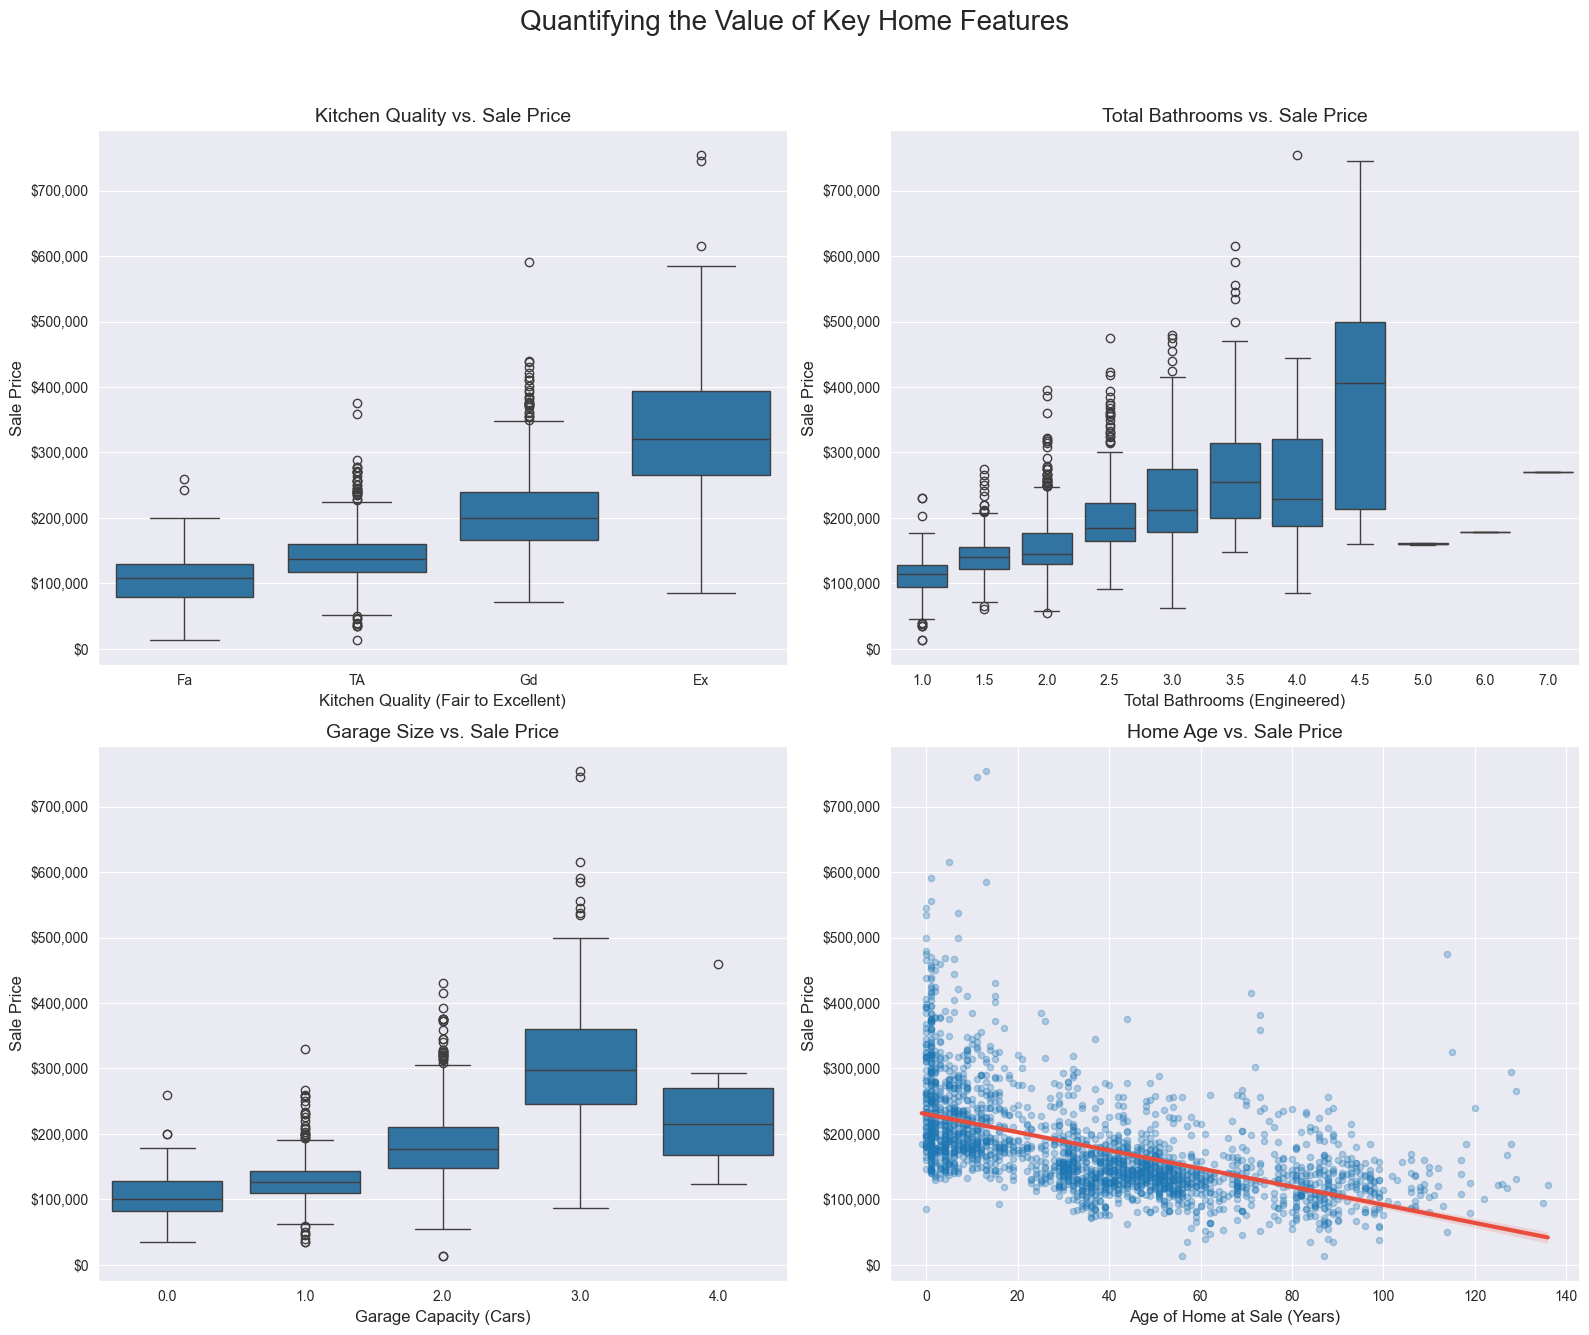

In [20]:
df_viz = df_train.copy()

# Engineer TotalBathrooms
df_viz['TotalBathrooms'] = (df_viz['Full Bath'] + 0.5*df_viz['Half Bath'] + 
                            df_viz['Bsmt Full Bath'] + 0.5*df_viz['Bsmt Half Bath'])

# Engineer AgeAtSale
df_viz['AgeAtSale'] = df_viz['Yr Sold'] - df_viz['Year Built']


# --- 2. Set up the 2x2 Subplot Grid ---
sns.set_style("darkgrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle("Quantifying the Value of Key Home Features", fontsize=20)


# --- 3. Plot 1: Kitchen Quality (Boxplot) ---
# We define the correct logical order for quality
kitchen_order = ['Fa', 'TA', 'Gd', 'Ex'] 
ax1 = axes[0, 0]
sns.boxplot(
    x='Kitchen Qual',
    y='SalePrice',
    data=df_viz,
    order=kitchen_order,
    ax=ax1
)
ax1.set_title('Kitchen Quality vs. Sale Price', fontsize=14)
ax1.set_xlabel('Kitchen Quality (Fair to Excellent)', fontsize=12)


# --- 4. Plot 2: Total Bathrooms (Boxplot) ---
ax2 = axes[0, 1]
sns.boxplot(
    x='TotalBathrooms',
    y='SalePrice',
    data=df_viz,
    ax=ax2
)
ax2.set_title('Total Bathrooms vs. Sale Price', fontsize=14)
ax2.set_xlabel('Total Bathrooms (Engineered)', fontsize=12)


# --- 5. Plot 3: Garage Cars (Boxplot) ---
ax3 = axes[1, 0]
sns.boxplot(
    x='Garage Cars',  # Note: This might be 'GarageCars' (no space)
    y='SalePrice',
    data=df_viz,
    ax=ax3
)
ax3.set_title('Garage Size vs. Sale Price', fontsize=14)
ax3.set_xlabel('Garage Capacity (Cars)', fontsize=12)


# --- 6. Plot 4: Age at Sale (Scatter/Regplot) ---
# A scatter plot with a regression line is better for a continuous feature
ax4 = axes[1, 1]
sns.regplot(
    x='AgeAtSale',
    y='SalePrice',
    data=df_viz,
    ax=ax4,
    scatter_kws={'alpha': 0.3, 's': 20}, # Make scatter points light
    line_kws={'color': '#e74c3c', 'linewidth': 3} # Make line strong red
)
ax4.set_title('Home Age vs. Sale Price', fontsize=14)
ax4.set_xlabel('Age of Home at Sale (Years)', fontsize=12)


# --- 7. Final Polish (Apply to all axes) ---
formatter = StrMethodFormatter('${x:,.0f}')
for ax in axes.flat:
    ax.yaxis.set_major_formatter(formatter)
    ax.set_ylabel('Sale Price', fontsize=12) # Set all Y-labels at once

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Make room for the main title
plt.show()

- an excellent kitchen quality is correlated with a $100k increase in house value
- the total amount of bathrooms also highly impacts sale price (the more the better)
- the size of the garage also represents a positive correlation with the target (the lower value for 4-car garages can be explained by too little instances of that case - only 13 garages in our training set have space for 4 garages)
- the younger the home, the higher the average saleprice

## Is sale price seasonal?

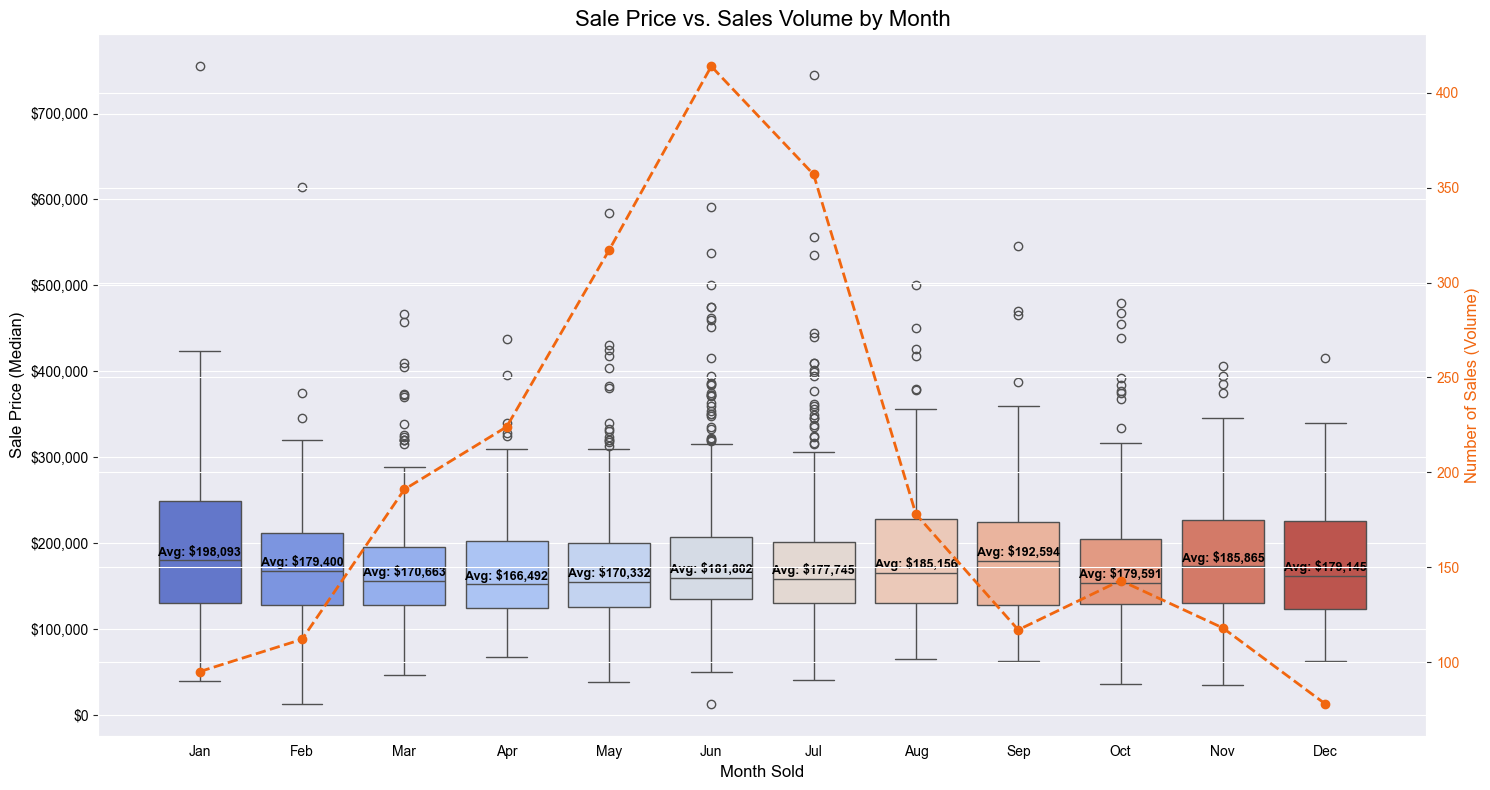

In [21]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(15, 8)) # Use plt.subplots to get ax directly

# --- 1. Map Month Numbers to Names for Readability ---
month_map = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
# Create a temporary column with the month names
df_viz = df_train.copy()
df_viz['Month'] = df_viz['Mo Sold'].map(month_map)

# Define the correct order for the x-axis
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

mean_prices = df_viz.groupby('Month')['SalePrice'].mean().reindex(month_order)
# --- 2. Plot the Boxplot on the Left Axis (ax) ---
sns.boxplot(
    x='Month', 
    y='SalePrice', 
    data=df_viz, 
    order=month_order,
    ax=ax,
    palette='coolwarm'
)

# --- 3. Format the Left Axis (Sale Price) ---
formatter = StrMethodFormatter('${x:,.0f}')
ax.yaxis.set_major_formatter(formatter)
ax.set_ylabel('Sale Price (Median)', fontsize=12, color='black')
ax.set_xlabel('Month Sold', fontsize=12, color='black')
ax.set_title('Sale Price vs. Sales Volume by Month', fontsize=16, color='black')
ax.tick_params(axis='y', labelcolor='black')
ax.tick_params(axis='x', labelcolor='black')


# --- 4. Create the Second Axis (ax2) for Volume ---
ax2 = ax.twinx()  # <-- This is the key line

# --- 5. Calculate and Plot the Volume Line ---
# Get the count of sales, and re-index it to be in the correct month order
sales_counts = df_viz['Month'].value_counts().reindex(month_order)

q3 = df_viz.groupby('Month')['SalePrice'].quantile(0.50)
position = (q3).reindex(month_order)

# Ensure the whisker doesn't go past the actual max data point
max_prices = df_viz.groupby('Month')['SalePrice'].max().reindex(month_order)
upper_whisker = pd.DataFrame({'position': position, 'max': max_prices}).min(axis=1)

for i, month in enumerate(month_order):
    mean_val = mean_prices.loc[month]
    text_y_pos = position.loc[month] + 2000

    ax.text(
        x=i,
        y=text_y_pos,
        s=f'Avg: ${mean_val:,.0f}',
        ha='center',
        va='bottom',
        fontsize=9,
        fontweight='bold',
        color='black' # Using black as per your style
    )
ax2.plot(
    sales_counts.index, 
    sales_counts.values,
    color="#f1660f",  # A bright yellow
    marker='o',
    linestyle='--',
    linewidth=2,
    label='Sales Volume'
)

# --- 6. Format the Right Axis (Volume) ---
ax2.set_ylabel('Number of Sales (Volume)', fontsize=12, color='#f1660f')
ax2.tick_params(axis='y', labelcolor='#f1660f')

plt.tight_layout()
plt.show()

In terms of price, we can see a slight trend of price increasing closer to the end of the year (excluding December - potentially due to Christman)

However, demand is clearly cyclical, being 400% higher in the summer months as opposed to the winter months.

## Overall Quality as a clear predictor of sale price

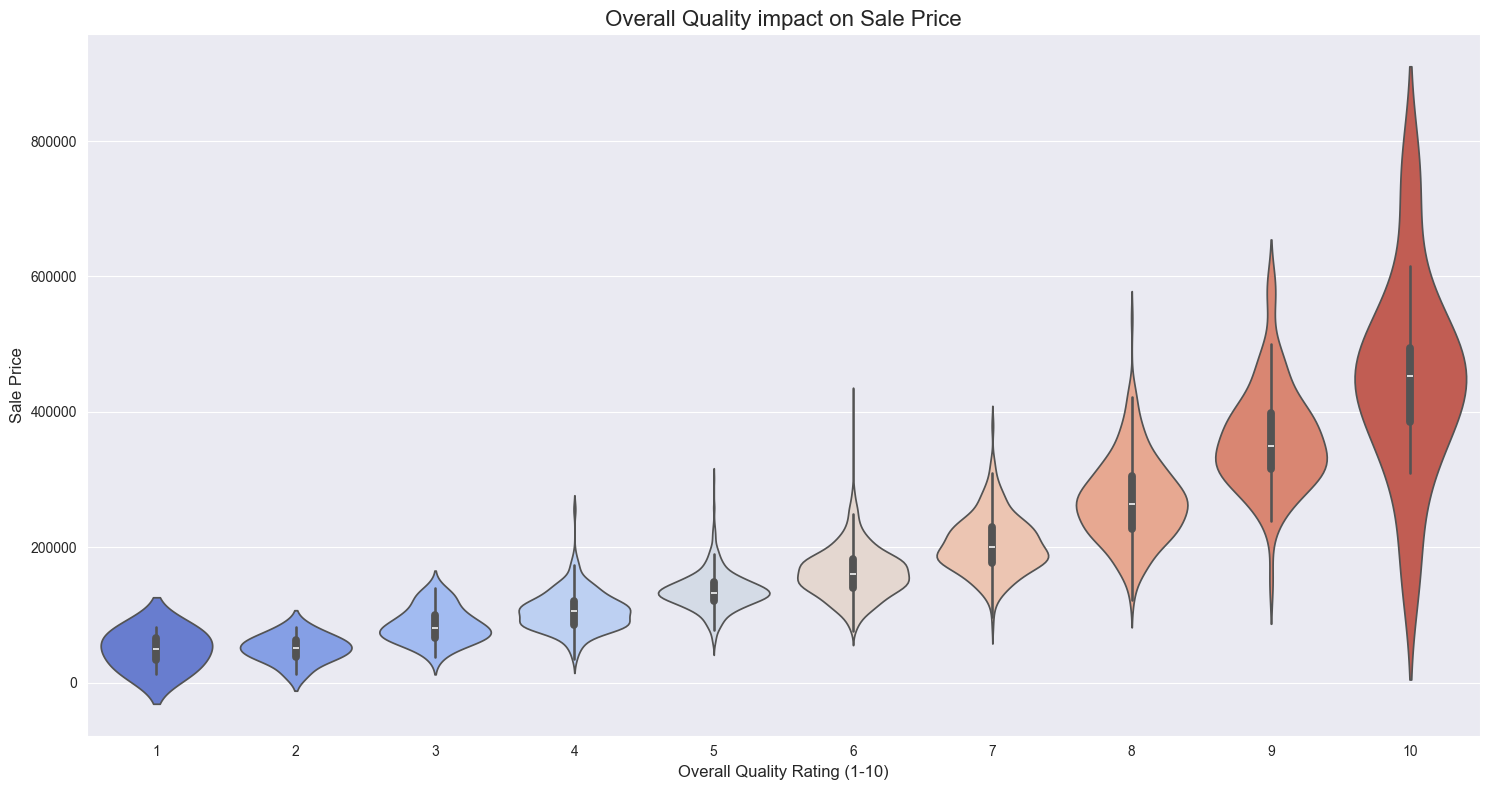

In [22]:
fig, ax = plt.subplots(figsize=(15, 8))

sns.violinplot(
    x='Overall Qual',
    y='SalePrice',
    data=df_train,
    palette='coolwarm',
    ax=ax
)

ax.set_title('Overall Quality impact on Sale Price', fontsize=16)
ax.set_ylabel('Sale Price', fontsize=12)
ax.set_xlabel('Overall Quality Rating (1-10)', fontsize=12)

# 5. Show the plot
plt.tight_layout()
plt.show()

The data shows a clear premium on 'Very Good' homes (8+). While the correlation between quality and price is strong across the board, the most significant price increase occurs when moving a property from the Good (6-7) to Very Good (8+) tier. This indicates that major, high-quality renovations designed to push a house into the 8+ rating will likely yield the highest return on investment.

The data shows a clear premium on 'Very Good' homes (8+). While the correlation between quality and price is strong across the board, the most significant price increase occurs when moving a property from the Good (6-7) to Very Good (8+) tier. This indicates that major, high-quality renovations designed to push a house into the 8+ rating will likely yield the highest return on investment.

# 3. Data Preprocessing Pipeline

## Inspecting Missing Values

In [23]:
missing = X_train.isnull().sum().sort_values(ascending=False)
missing_percent = (missing / len(X_train)) * 100
types = X_train.dtypes
unique_vals = X_train.nunique()

summary = pd.concat([missing, missing_percent, types, unique_vals], axis=1)
summary.columns = ['Missing', 'Missing_%', 'Type', 'Unique_Values']
print(summary[summary['Missing'] > 0])

                Missing  Missing_%     Type  Unique_Values
Pool QC            2332  99.488055   object              4
Misc Feature       2250  95.989761   object              4
Alley              2182  93.088737   object              2
Fence              1874  79.948805   object              4
Mas Vnr Type       1426  60.836177   object              4
Fireplace Qu       1144  48.805461   object              5
Lot Frontage        393  16.766212  float64            120
Garage Yr Blt       122   5.204778  float64            102
Garage Qual         122   5.204778   object              5
Garage Cond         122   5.204778   object              5
Garage Finish       122   5.204778   object              3
Garage Type         120   5.119454   object              6
Bsmt Exposure        63   2.687713   object              4
BsmtFin Type 2       62   2.645051   object              6
BsmtFin Type 1       61   2.602389   object              6
Bsmt Cond            61   2.602389   object             

### Choosing imputation strategy for each feature

In [24]:
#cateogricals to impute with "None": Pool QC, Misc Feature, Alley, Fence, Mas Vnr Type, Fireplace Qu, Garage Qual, Garage Cond, Garage Type, Garage Finish, Bsmt Exposure, BsmtFin Type 2, BsmtFin Type 1, Bsmt Cond, Bsmt Qual
#categoricals to impute with most common: 
#numericals to impute with 0: Lot Frontage, Mas Vnr Area, BsmtFin SF 1, BsmtFin SF 2, Bsmt Unf SF, Total Bsmt SF, Bsmt Half Bath, Bsmt Full Bath, Garage Area, Garage Cars
#numericals to impute with median: 

#side-note: features like pool qc, misc feature, alley, fence, and mas vnr type, and something from garage may be worth feature engineering into a binary existence feature

## Feature Engineering Pipeline
- new features to create
- feature types to change (month sold into categorical, mssublass to categorical)
- turn high-missingness features into binary classifiers (impute missing with "Missing" - only that makes sense for the one hot transformer)
- drop garage year blt - no way to impute it functionally.
- remember to append the lists created for transformers with the correct newly engineered column names.
- performing custom imputations


In [25]:
X_train.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition
381,20,RL,80.0,10400,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,7,5,1976,1976,Gable,CompShg,HdBoard,HdBoard,BrkFace,189.0,TA,TA,CBlock,Gd,TA,No,Unf,0.0,Unf,0.0,1090.0,1090.0,GasA,TA,Y,SBrkr,1370,0,0,1370,0.0,0.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,479.0,TA,TA,Y,0,0,0,0,0,0,NaN,MnPrv,NaN,0,6,2009,WD,Family
834,60,RL,NaN,28698,Pave,NaN,IR2,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,2Story,5,5,1967,1967,Flat,Tar&Grv,Plywood,Plywood,NaN,0.0,TA,TA,PConc,TA,Gd,Gd,LwQ,249.0,ALQ,764.0,0.0,1013.0,GasA,TA,Y,SBrkr,1160,966,0,2126,0.0,1.0,2,1,3,1,TA,7,Min2,0,NaN,Attchd,1967.0,Fin,2.0,538.0,TA,TA,Y,486,0,0,0,225,0,NaN,NaN,NaN,0,6,2009,WD,Abnorml
1898,90,RL,70.0,9842,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,NAmes,Norm,Norm,Duplex,1Story,4,5,1962,1962,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,TA,TA,Slab,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,TA,Y,SBrkr,1224,0,0,1224,0.0,0.0,2,0,2,2,TA,6,Typ,0,NaN,CarPort,1962.0,Unf,2.0,462.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,3,2007,WD,Normal
678,90,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,Duplex,1Story,4,5,1949,1950,Gable,CompShg,BrkFace,Stone,NaN,0.0,TA,TA,Slab,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,Wall,Fa,N,FuseF,1040,0,0,1040,0.0,0.0,2,0,2,2,TA,6,Typ,0,NaN,Detchd,1956.0,Unf,2.0,420.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal
700,190,RM,63.0,7627,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Artery,Norm,2fmCon,2Story,4,6,1920,1950,Gable,CompShg,AsbShng,AsbShng,NaN,0.0,Fa,TA,BrkTil,Fa,Po,No,Unf,0.0,Unf,0.0,600.0,600.0,GasA,Gd,N,SBrkr,1101,600,0,1701,0.0,0.0,2,0,4,2,Fa,8,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,N,0,0,148,0,0,0,NaN,NaN,NaN,0,10,2009,WD,Normal


In [26]:
#checking the skew of numerical variables
num_features = X_train.select_dtypes(exclude=object)
skew_num_features = num_features.skew()
print(skew_num_features)
skewed_features = skew_num_features[abs(skew_num_features) > 0.80]
skewed_features.index.to_list()

MS SubClass         1.364770
Lot Frontage        1.735006
Lot Area           13.743796
Overall Qual        0.204464
Overall Cond        0.595367
Year Built         -0.594285
Year Remod/Add     -0.428230
Mas Vnr Area        2.497916
BsmtFin SF 1        1.529633
BsmtFin SF 2        4.185302
Bsmt Unf SF         0.910201
Total Bsmt SF       1.343278
1st Flr SF          1.542293
2nd Flr SF          0.875991
Low Qual Fin SF    12.959105
Gr Liv Area         1.303483
Bsmt Full Bath      0.628831
Bsmt Half Bath      4.003080
Full Bath           0.184097
Half Bath           0.729985
Bedroom AbvGr       0.315893
Kitchen AbvGr       4.493078
TotRms AbvGrd       0.767736
Fireplaces          0.771836
Garage Yr Blt      -0.303852
Garage Cars        -0.211890
Garage Area         0.292990
Wood Deck SF        1.564691
Open Porch SF       2.664539
Enclosed Porch      3.993799
3Ssn Porch         12.140302
Screen Porch        3.894896
Pool Area          15.898588
Misc Val           20.416138
Mo Sold       

['MS SubClass',
 'Lot Frontage',
 'Lot Area',
 'Mas Vnr Area',
 'BsmtFin SF 1',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 '1st Flr SF',
 '2nd Flr SF',
 'Low Qual Fin SF',
 'Gr Liv Area',
 'Bsmt Half Bath',
 'Kitchen AbvGr',
 'Wood Deck SF',
 'Open Porch SF',
 'Enclosed Porch',
 '3Ssn Porch',
 'Screen Porch',
 'Pool Area',
 'Misc Val']

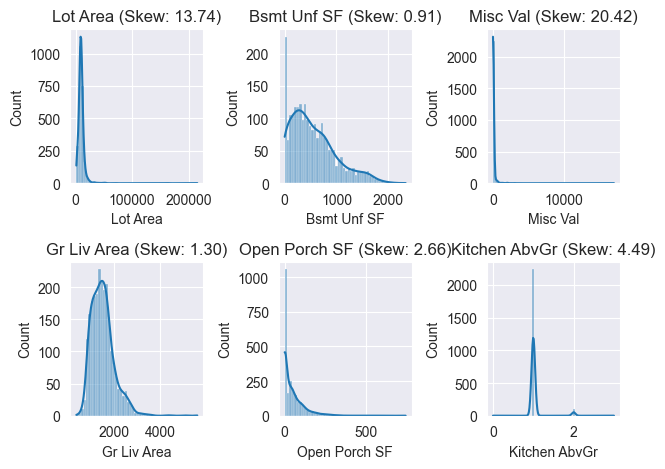

In [27]:
#vizualizing a few of the skewed features (BEFORE)
features_to_plot = [
    'Lot Area', 
    'Bsmt Unf SF',
    'Misc Val', 
    'Gr Liv Area', 
    'Open Porch SF', 
    'Kitchen AbvGr'
]

for i, feature in enumerate(features_to_plot):
    ax = plt.subplot(2, 3, i + 1) # <-- The fix
    sns.histplot(X_train[feature], bins=50, kde=True, ax=ax)
    ax.set_title(f'{feature} (Skew: {X_train[feature].skew():.2f})')

plt.tight_layout()

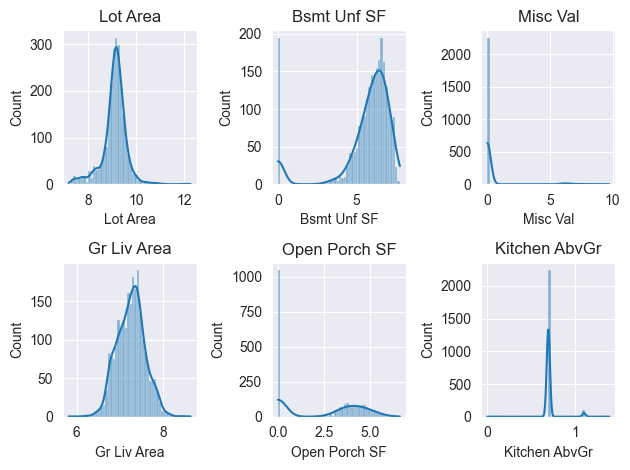

In [28]:
#AFTER (demo - there will be a systematic transformation process for all features inside the pipeline later in the code)

for i, feature in enumerate(features_to_plot):
    ax = plt.subplot(2, 3, i + 1) # <-- The fix
    sns.histplot(np.log1p(X_train[feature]), bins=50, kde=True, ax=ax)
    ax.set_title(f'{feature}')

plt.tight_layout()

In [29]:
#defining a high-missingness list (including Mas Vnr Type and Fireplace Qu, since their missingness indicates lack of existence)
missingness = X_train.isna().sum().sort_values(ascending=False) * 100 / X_train.shape[0]
missingness

Pool QC           99.488055
Misc Feature      95.989761
Alley             93.088737
Fence             79.948805
Mas Vnr Type      60.836177
                    ...    
Central Air        0.000000
Electrical         0.000000
1st Flr SF         0.000000
2nd Flr SF         0.000000
Sale Condition     0.000000
Length: 79, dtype: float64

In [30]:
high_missingness = missingness[missingness > 45]
high_missingness.index.to_list()

['Pool QC', 'Misc Feature', 'Alley', 'Fence', 'Mas Vnr Type', 'Fireplace Qu']

### Defining Feature Engineering Pipeline Step Function

In [31]:
def FeatureEngineering(param):
    param_ = param.copy()

    #changing feature types
    param_['MS SubClass'] = param_['MS SubClass'].astype('object')
    param_['Mo Sold'] = param_['Mo Sold'].astype('object')

    #log transforming variables
    high_skew_features = ['Lot Frontage','Lot Area','Mas Vnr Area',
    'BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF','Total Bsmt SF','1st Flr SF',
    '2nd Flr SF','Low Qual Fin SF','Gr Liv Area','Bsmt Half Bath','Kitchen AbvGr',
    'Wood Deck SF','Open Porch SF','Enclosed Porch','3Ssn Porch','Screen Porch',
    'Pool Area','Misc Val']

    for item in high_skew_features:
        param_[item] = np.log1p(param_[item])

    #turning high-missingness features into binaries
    high_missingness_list = ['Pool QC', 'Misc Feature', 'Alley', 'Fence', 'Mas Vnr Type', 'Fireplace Qu']

    for item in high_missingness_list:
        param_[item] = param_[item].notna().astype(int) 

    #creating variables through interaction terms
    param_['TotalSF'] = param_['Total Bsmt SF'] + param_['1st Flr SF'] + param_['2nd Flr SF']
    param_['AgeAtSale'] = param_['Yr Sold'] - param_['Year Built']
    param_['TimeSinceRemod'] = param_['Yr Sold'] - param_['Year Remod/Add']
    param_['TotalBathrooms'] = (param_['Full Bath'] + 0.5*param_['Half Bath'] +
                                param_['Bsmt Full Bath'] + 0.5*param_['Bsmt Half Bath'])

    #defining new binaries
    param_['HasGarage'] = (param_['Garage Area'] > 0).astype(int)
    param_['Has2ndFloor'] = (param_['2nd Flr SF'] > 0).astype(int)
    param_['WasRemodeled'] = (param_['Year Remod/Add'] != param_['Year Built']).astype(int)

    #dropping unusable features
    param_ = param_.drop('Garage Yr Blt', axis=1)

    return param_

In [32]:
#using a function transformer to turn this function into a pipeline step
from sklearn.preprocessing import FunctionTransformer

feature_transformer = FunctionTransformer(FeatureEngineering, validate=False)

### Defining lists of features to be encoded in different ways

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import TargetEncoder

#Different types of transforming we want to do:
#Numericals imputed with median
#Numericals imputed with 0
#Categoricals imputed with 0 and Ordinally Encoded
#Categoricals imputed with mode and ordianlly encoded
#Categoricals imputed with "missing" and one-hot encoded
#Categoricals imputed with mode and one-hot encoded
#Cateogricals Replaced with mode and Target Encoded

#high missingness features to be engineered into binary existence features should go into the one hot encoding set to fill with 
#Defining Separate lists to be transformed differently.

#Numerical Columns
num_cols = X_train.select_dtypes(exclude='object').columns.tolist()
#Categorical columns
categorical_columns = X_train.select_dtypes(include='object').columns.tolist()

#print(df_train.shape[1])
#print(len(num_cols))
#print(len(categorical_columns))

#1. Numericals Imputed with median list
num_median = ['Year Built', 'Year Remod/Add', 'Garage Yr Blt', 'Overall Qual', 'Overall Cond', '1st Flr SF', '2nd Flr SF', 'Gr Liv Area', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd']

#2. numericals imputed with 0 list
num_zero = list(set(num_cols) - set(num_median))

#print(num_zero)
#print(num_zero)
print(X_train.shape)
print(len(num_cols))
print(len(categorical_columns))
print()
print(len(num_median))
print(len(num_zero))



(2344, 79)
36
43

13
23


In [34]:
#Categoricals To Be Ordinally Encoded: 
cat_ordinal = ['Utilities', 'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating QC', 'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Qual', 'Garage Cond']

#3. Categorials to be Target Encoded
cat_target = ['Neighborhood', 'Exterior 1st', 'Exterior 2nd', 'Sale Type']
df_train[categorical_columns].nunique().sort_values(ascending=False)

Neighborhood      28
Exterior 1st      16
Exterior 2nd      16
Sale Type         10
Condition 1        9
Functional         8
Condition 2        8
House Style        8
Roof Matl          8
MS Zoning          7
Garage Type        6
Heating            6
BsmtFin Type 2     6
BsmtFin Type 1     6
Foundation         6
Sale Condition     6
Roof Style         6
Lot Config         5
Garage Cond        5
Garage Qual        5
Fireplace Qu       5
Heating QC         5
Electrical         5
Bsmt Qual          5
Bldg Type          5
Bsmt Cond          5
Exter Cond         5
Misc Feature       4
Fence              4
Pool QC            4
Exter Qual         4
Bsmt Exposure      4
Land Contour       4
Kitchen Qual       4
Mas Vnr Type       4
Lot Shape          4
Land Slope         3
Garage Finish      3
Paved Drive        3
Utilities          3
Central Air        2
Street             2
Alley              2
dtype: int64

In [35]:
#Columns to be one hot encoded (nominal)
cat_onehot = list(set(categorical_columns) - set(cat_ordinal) - set(cat_target))

print(len(categorical_columns))
print(len(cat_onehot))
print(len(cat_ordinal))
print(len(cat_target))

print(categorical_columns)
print()
print('nominal:',sorted(cat_onehot))
print('ordinal',sorted(cat_ordinal))
print('target:',sorted(cat_target))

43
25
14
4
['MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC', 'Central Air', 'Electrical', 'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence', 'Misc Feature', 'Sale Type', 'Sale Condition']

nominal: ['Alley', 'Bldg Type', 'Central Air', 'Condition 1', 'Condition 2', 'Electrical', 'Fence', 'Foundation', 'Garage Finish', 'Garage Type', 'Heating', 'House Style', 'Land Contour', 'Land Slope', 'Lot Config', 'Lot Shape', 'MS Zoning', 'Mas Vnr Type', 'Misc Feature', 'Paved Drive', 'Pool QC', 'Roof Matl', 'Roof Style', 'Sale Condition', 'Street']
ordinal ['Bsmt C

In [36]:
#4. Nominal columns to be imputed with "Missing":
cat_onehot_missing = ['Pool QC', 'Misc Feature', 'Alley', 'Garage Finish', 'Garage Type', 'Fence', 'Mas Vnr Type']
#5. Nominal columns to be imputed with mode
cat_onehot_mode = list(set(cat_onehot) - set(cat_onehot_missing))

print(len(cat_onehot))
print(len(cat_onehot_missing))
print(len(cat_onehot_mode))

25
7
18


In [37]:
#6. Ordinal columns to be imputed with "Missing" (signaling that the feature is missing): Bsmt Qual, Bsmt Cond, Bsmt Exposure, BsmtFin Type 1, BsmtFin Type 2, Fireplace Qu, Garage Qual, Garage Cond
cat_ordinal_missing = ['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Fireplace Qu', 'Garage Qual', 'Garage Cond']

#7. Ordinal columns to be imputed with mode: 
cat_ordinal_mode = list(set(cat_ordinal) - set(cat_ordinal_missing))

print(len(cat_ordinal))
print(len(cat_ordinal_missing))
print(len(cat_ordinal_mode))

14
8
6


### Final Lists

In [38]:
#We now have 7 lists to be imputed and encoded in different ways. 
print("num_median:", len(num_median), num_median)
print("num_zero:", len(num_zero), num_zero)
print("cat_onehot_mode:", len(cat_onehot_mode), cat_onehot_mode)
print("cat_onehot_missing:", len(cat_onehot_missing), cat_onehot_missing)
print("cat_ordinal_mode:", len(cat_ordinal_mode), cat_ordinal_mode)
print("cat_ordinal_missing:", len(cat_ordinal_missing), cat_ordinal_missing)
print("cat_target:", len(cat_target), cat_target)

num_median: 13 ['Year Built', 'Year Remod/Add', 'Garage Yr Blt', 'Overall Qual', 'Overall Cond', '1st Flr SF', '2nd Flr SF', 'Gr Liv Area', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd']
num_zero: 23 ['Lot Frontage', 'Wood Deck SF', 'Pool Area', 'Bsmt Unf SF', 'Screen Porch', '3Ssn Porch', 'Lot Area', 'BsmtFin SF 2', 'Bsmt Full Bath', 'Garage Cars', 'Mo Sold', 'Total Bsmt SF', 'Enclosed Porch', 'BsmtFin SF 1', 'Low Qual Fin SF', 'Yr Sold', 'Bsmt Half Bath', 'Fireplaces', 'MS SubClass', 'Mas Vnr Area', 'Misc Val', 'Open Porch SF', 'Garage Area']
cat_onehot_mode: 18 ['House Style', 'Sale Condition', 'Roof Style', 'Paved Drive', 'Bldg Type', 'Street', 'Condition 2', 'Land Slope', 'Foundation', 'Land Contour', 'Condition 1', 'MS Zoning', 'Heating', 'Central Air', 'Lot Config', 'Electrical', 'Roof Matl', 'Lot Shape']
cat_onehot_missing: 7 ['Pool QC', 'Misc Feature', 'Alley', 'Garage Finish', 'Garage Type', 'Fence', 'Mas Vnr Type']
cat_ordinal_mode: 6 ['Utilitie

In [39]:
#extending our lists by the newly created features (in the Feature Engineering Section)
new_numeric_median = ['TotalSF', 'AgeAtSale', 'TimeSinceRemod', 'TotalBathrooms']
num_median.extend(new_numeric_median)

#we won't append the newly created binaries, since they are ready to use and don't need encoding/imputing

#removing the dropped Garage Yr Blt feature from its list
num_median.remove('Garage Yr Blt')

#the following are now categoricals
changed_types = ['MS SubClass', 'Mo Sold']
for feat in changed_types:
    num_zero.remove(feat)
    cat_onehot_mode.append(feat)

In [40]:
cat_onehot_mode

['House Style',
 'Sale Condition',
 'Roof Style',
 'Paved Drive',
 'Bldg Type',
 'Street',
 'Condition 2',
 'Land Slope',
 'Foundation',
 'Land Contour',
 'Condition 1',
 'MS Zoning',
 'Heating',
 'Central Air',
 'Lot Config',
 'Electrical',
 'Roof Matl',
 'Lot Shape',
 'MS SubClass',
 'Mo Sold']

In [41]:
#checking value ordering for columns to be imputed with mode:
print('Ordinal to be imputed with mode - list of values')
for feature in cat_ordinal_mode:
    print(f"{feature}:", X_train[feature].unique())

print()
print("Ordinal to be imputed with 'missing' - list of values")

for feature in cat_ordinal_missing:
    print(f"{feature}:", X_train[feature].unique())

Ordinal to be imputed with mode - list of values
Utilities: ['AllPub' 'NoSewr' 'NoSeWa']
Exter Qual: ['TA' 'Fa' 'Gd' 'Ex']
Heating QC: ['TA' 'Fa' 'Gd' 'Ex' 'Po']
Functional: ['Typ' 'Min2' 'Sev' 'Min1' 'Maj2' 'Mod' 'Maj1' 'Sal']
Kitchen Qual: ['TA' 'Fa' 'Gd' 'Ex']
Exter Cond: ['TA' 'Gd' 'Fa' 'Ex' 'Po']

Ordinal to be imputed with 'missing' - list of values
Bsmt Qual: ['Gd' 'TA' nan 'Fa' 'Ex' 'Po']
Bsmt Cond: ['TA' 'Gd' nan 'Po' 'Fa' 'Ex']
Bsmt Exposure: ['No' 'Gd' nan 'Av' 'Mn']
BsmtFin Type 1: ['Unf' 'LwQ' nan 'GLQ' 'BLQ' 'ALQ' 'Rec']
BsmtFin Type 2: ['Unf' 'ALQ' nan 'Rec' 'LwQ' 'GLQ' 'BLQ']
Fireplace Qu: ['TA' nan 'Ex' 'Po' 'Gd' 'Fa']
Garage Qual: ['TA' nan 'Gd' 'Fa' 'Po' 'Ex']
Garage Cond: ['TA' nan 'Gd' 'Fa' 'Po' 'Ex']


In [42]:
#defining lists in order:
#1. For Ordinal to be imputed with mode:
qualfeatures = ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
utilities = ['ELO', 'NoSeWa', 'NoSewr', 'AllPub']
functional = ['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal']
ordinal_mode_order = [qualfeatures,
                      qualfeatures,
                      qualfeatures,
                      qualfeatures,
                      utilities,
                      functional]

#2. For Ordinal to be imputed with missing
exposure = ['None', 'No', 'Mn', 'Av', 'Gd']
bsmtfin = ['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
ordinal_missing_order = [qualfeatures,
                         qualfeatures,
                         exposure,
                         bsmtfin,
                         bsmtfin,
                         qualfeatures,
                         qualfeatures,
                         qualfeatures]

### Defining the Encoding/Scaling Pipeline Step

In [43]:
#Let's build a pipeline to handle this logic
#(we'll columns transform later, once features are enginnered and added to the list)

# 1. num_median: Impute with median, then scale
num_median_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 2. num_zero: Impute with 0, then scale
num_zero_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

# 3. cat_onehot_mode: Impute with mode, then OneHotEncode
cat_onehot_mode_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='infrequent_if_exist',
                          min_frequency=30,
                          sparse_output=False))
])

# 4. cat_onehot_missing: Impute with constant 'Missing', then OneHotEncode
cat_onehot_missing_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('ohe', OneHotEncoder(handle_unknown='infrequent_if_exist',
                          min_frequency=30,
                          sparse_output=False))
])

# 5. cat_ordinal_mode: Impute with mode, then OrdinalEncode
cat_ordinal_mode_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('oe', OrdinalEncoder(
        categories=ordinal_mode_order,
        handle_unknown='use_encoded_value',
        unknown_value=-1 # Assign -1 to unknown categories
    ))
])

# 6. cat_ordinal_missing: Impute with constant 'None', then OrdinalEncode
cat_ordinal_missing_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
    ('oe', OrdinalEncoder(
        categories=ordinal_missing_order,
        handle_unknown='use_encoded_value',
        unknown_value=-1 #Assigns -1 to unknown categories
    ))


])

target_transform_pipe = TargetEncoder(
    target_type='continuous', 
    cv=5,
    shuffle=True,
    random_state=42
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num_median', num_median_pipe, num_median),
        ('num_zero', num_zero_pipe, num_zero),
        ('cat_ohe_mode', cat_onehot_mode_pipe, cat_onehot_mode),
        ('cat_ohe_miss', cat_onehot_missing_pipe, cat_onehot_missing),
        ('cat_ord_mode', cat_ordinal_mode_pipe, cat_ordinal_mode),
        ('cat_ord_miss', cat_ordinal_missing_pipe, cat_ordinal_missing),
        ('cat_target', target_transform_pipe, cat_target)

    ],
    remainder='passthrough'
)

In [44]:
#combining pipelines
preprocessing_pipeline = Pipeline(steps=[
    ('feature_transformer', feature_transformer),
    ('preprocessor', preprocessor),
])

In [45]:
#ensuring the pipeline works as intended
preprocessing_pipeline.set_output(transform="pandas")

,steps,"[('feature_transformer', ...), ('preprocessor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,func,<function Fea...t 0x159395120>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


In [46]:
#running the preprocessing pipeline

X_train_prepared = preprocessing_pipeline.fit_transform(X_train, y_train_log)


X_test_prepared = preprocessing_pipeline.transform(X_test)

print(f"Original shape: {X_train.shape}")
print(f"Prepared shape: {X_train_prepared.shape}")

Original shape: (2344, 79)
Prepared shape: (2344, 168)


In [47]:
X_train_prepared.head()

,num_median__Year Built,num_median__Year Remod/Add,num_median__Overall Qual,num_median__Overall Cond,num_median__1st Flr SF,num_median__2nd Flr SF,num_median__Gr Liv Area,num_median__Full Bath,num_median__Half Bath,num_median__Bedroom AbvGr,num_median__Kitchen AbvGr,num_median__TotRms AbvGrd,num_median__TotalSF,num_median__AgeAtSale,num_median__TimeSinceRemod,num_median__TotalBathrooms,num_zero__Lot Frontage,num_zero__Wood Deck SF,num_zero__Pool Area,num_zero__Bsmt Unf SF,num_zero__Screen Porch,num_zero__3Ssn Porch,num_zero__Lot Area,num_zero__BsmtFin SF 2,num_zero__Bsmt Full Bath,num_zero__Garage Cars,num_zero__Total Bsmt SF,num_zero__Enclosed Porch,num_zero__BsmtFin SF 1,num_zero__Low Qual Fin SF,num_zero__Yr Sold,num_zero__Bsmt Half Bath,num_zero__Fireplaces,num_zero__Mas Vnr Area,num_zero__Misc Val,num_zero__Open Porch SF,num_zero__Garage Area,cat_ohe_mode__House Style_1.5Fin,cat_ohe_mode__House Style_1Story,cat_ohe_mode__House Style_2Story,cat_ohe_mode__House Style_SFoyer,cat_ohe_mode__House Style_SLvl,cat_ohe_mode__House Style_infrequent_sklearn,cat_ohe_mode__Sale Condition_Abnorml,cat_ohe_mode__Sale Condition_Family,cat_ohe_mode__Sale Condition_Normal,cat_ohe_mode__Sale Condition_Partial,cat_ohe_mode__Sale Condition_infrequent_sklearn,cat_ohe_mode__Roof Style_Gable,cat_ohe_mode__Roof Style_Hip,cat_ohe_mode__Roof Style_infrequent_sklearn,cat_ohe_mode__Paved Drive_N,cat_ohe_mode__Paved Drive_P,cat_ohe_mode__Paved Drive_Y,cat_ohe_mode__Bldg Type_1Fam,cat_ohe_mode__Bldg Type_2fmCon,cat_ohe_mode__Bldg Type_Duplex,cat_ohe_mode__Bldg Type_Twnhs,cat_ohe_mode__Bldg Type_TwnhsE,cat_ohe_mode__Street_Pave,cat_ohe_mode__Street_infrequent_sklearn,cat_ohe_mode__Condition 2_Norm,cat_ohe_mode__Condition 2_infrequent_sklearn,cat_ohe_mode__Land Slope_Gtl,cat_ohe_mode__Land Slope_Mod,cat_ohe_mode__Land Slope_infrequent_sklearn,cat_ohe_mode__Foundation_BrkTil,cat_ohe_mode__Foundation_CBlock,cat_ohe_mode__Foundation_PConc,cat_ohe_mode__Foundation_Slab,cat_ohe_mode__Foundation_infrequent_sklearn,cat_ohe_mode__Land Contour_Bnk,cat_ohe_mode__Land Contour_HLS,cat_ohe_mode__Land Contour_Low,cat_ohe_mode__Land Contour_Lvl,cat_ohe_mode__Condition 1_Artery,cat_ohe_mode__Condition 1_Feedr,cat_ohe_mode__Condition 1_Norm,cat_ohe_mode__Condition 1_RRAn,cat_ohe_mode__Condition 1_infrequent_sklearn,cat_ohe_mode__MS Zoning_FV,cat_ohe_mode__MS Zoning_RL,cat_ohe_mode__MS Zoning_RM,cat_ohe_mode__MS Zoning_infrequent_sklearn,cat_ohe_mode__Heating_GasA,cat_ohe_mode__Heating_infrequent_sklearn,cat_ohe_mode__Central Air_N,cat_ohe_mode__Central Air_Y,cat_ohe_mode__Lot Config_Corner,cat_ohe_mode__Lot Config_CulDSac,cat_ohe_mode__Lot Config_FR2,cat_ohe_mode__Lot Config_Inside,cat_ohe_mode__Lot Config_infrequent_sklearn,cat_ohe_mode__Electrical_FuseA,cat_ohe_mode__Electrical_FuseF,cat_ohe_mode__Electrical_SBrkr,cat_ohe_mode__Electrical_infrequent_sklearn,cat_ohe_mode__Roof Matl_CompShg,cat_ohe_mode__Roof Matl_infrequent_sklearn,cat_ohe_mode__Lot Shape_IR1,cat_ohe_mode__Lot Shape_IR2,cat_ohe_mode__Lot Shape_Reg,cat_ohe_mode__Lot Shape_infrequent_sklearn,cat_ohe_mode__MS SubClass_20,cat_ohe_mode__MS SubClass_30,cat_ohe_mode__MS SubClass_50,cat_ohe_mode__MS SubClass_60,cat_ohe_mode__MS SubClass_70,cat_ohe_mode__MS SubClass_80,cat_ohe_mode__MS SubClass_85,cat_ohe_mode__MS SubClass_90,cat_ohe_mode__MS SubClass_120,cat_ohe_mode__MS SubClass_160,cat_ohe_mode__MS SubClass_190,cat_ohe_mode__MS SubClass_infrequent_sklearn,cat_ohe_mode__Mo Sold_1,cat_ohe_mode__Mo Sold_2,cat_ohe_mode__Mo Sold_3,cat_ohe_mode__Mo Sold_4,cat_ohe_mode__Mo Sold_5,cat_ohe_mode__Mo Sold_6,cat_ohe_mode__Mo Sold_7,cat_ohe_mode__Mo Sold_8,cat_ohe_mode__Mo Sold_9,cat_ohe_mode__Mo Sold_10,cat_ohe_mode__Mo Sold_11,cat_ohe_mode__Mo Sold_12,cat_ohe_miss__Pool QC_0,cat_ohe_miss__Pool QC_infrequent_sklearn,cat_ohe_miss__Misc Feature_0,cat_ohe_miss__Misc Feature_1,cat_ohe_miss__Alley_0,cat_ohe_miss__Alley_1,cat_ohe_miss__Garage Finish_Fin,cat_ohe_miss__Garage Finish_Missing,cat_ohe_miss__Garage Finish_RFn,cat_ohe

# 4. Modeling - Regression
- Baseline model
- Linear regression
- Ridge regression
- Random forest regressor
- XGBoost


### Baseline Model 1 - raw average in dollars

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

mean_price = y_train.mean()
y_pred_baseline = [mean_price] * len(y_test)

r2 = r2_score(y_test, y_pred_baseline)
rmse = sqrt(mean_squared_error(y_test, y_pred_baseline))

print('--- Baseline 1 (Raw Dollars) ---')
print(f'R2: {r2:.3f}')
print(f'RMSE: ${rmse:,.2f}')

--- Baseline 1 (Raw Dollars) ---
R2: -0.015
RMSE: $90,222.37


### Baseline Model 2 - average in log-scale
- this is necessary to compare to our models results, which will also be in log scale

In [49]:
mean_log = y_train_log.mean()
y_pred_baseline_log = [mean_log] * len(y_test_log)

r2_log = r2_score(y_test_log, y_pred_baseline_log)
rmse_log = sqrt(mean_squared_error(y_test_log, y_pred_baseline_log))

print('--- Baseline 2 (log-scale) ---')
print(f'R2: {r2_log:.3f}')
print('RMSE:',rmse_log)


--- Baseline 2 (log-scale) ---
R2: -0.011
RMSE: 0.4325824030274985


### Linear Regression

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

#raw
lr = LinearRegression()
lr.fit(X_train_prepared, y_train_log)
y_pred_lr = lr.predict(X_test_prepared)
print(np.expm1(y_pred_lr[0:5]))

r2 = r2_score(y_test_log, y_pred_lr)
rmse = sqrt(mean_squared_error(y_test_log, y_pred_lr))

print('R2 Score is:',r2)
print('RMSE is:',rmse)

[166749.63303263 107735.66491797 191540.32746865 128231.72911771
 120441.76743551]
R2 Score is: 0.9278532969170126
RMSE is: 0.11553896599583705


In [51]:
#cross-validated
lr2 = LinearRegression()

scores = cross_val_score(
    lr2, 
    X_train_prepared, 
    y_train_log, 
    cv=5, 
    scoring='neg_root_mean_squared_error'
)

print(f'Log-RMSE scores for each of the 5 folds: {-scores}')

print(f'Average Log-RMSE (CV): {-np.mean(scores):.4f}')

Log-RMSE scores for each of the 5 folds: [0.13918843 0.12904967 0.14223042 0.13607335 0.11693887]
Average Log-RMSE (CV): 0.1327


### Ridge Regression

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
import joblib
import os

#Ridge regression tends to perform better on such high-dimensionality datasets - we can tune alpha to avoid overfitting
scoring_metrics = ['neg_root_mean_squared_error', 'r2']

ridge_file = 'models/ridge_grid_search.pkl'
#checking if a model was already trained:
if os.path.exists(ridge_file):
    
    #if so, just load the file
    ridge_grid_search = joblib.load(ridge_file)

else:
    ridge = Ridge()
    param_grid = {'alpha' : [0.05, 0.1, 0.5, 1, 10, 20, 50]}

    ridge_grid_search = GridSearchCV(estimator=ridge,
                                 param_grid=param_grid,
                                 cv=5,
                                 scoring=scoring_metrics, 
                                 refit='neg_root_mean_squared_error')

    ridge_grid_search.fit(X_train_prepared, y_train_log)

    #saving ridge model
    joblib.dump(ridge_grid_search, ridge_file)

In [53]:
#printing out the results for all folds:
results = pd.DataFrame(ridge_grid_search.cv_results_)
results[['params', 'mean_test_neg_root_mean_squared_error', 'rank_test_neg_root_mean_squared_error', 'mean_test_r2', 'rank_test_r2']]

,params,mean_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,mean_test_r2,rank_test_r2
0,{'alpha': 0.05},-0.132381,7,0.890529,7
1,{'alpha': 0.1},-0.132291,6,0.890684,6
2,{'alpha': 0.5},-0.131933,5,0.891292,5
3,{'alpha': 1},-0.131679,4,0.891706,4
4,{'alpha': 10},-0.130290,3,0.893871,2
5,{'alpha': 20},-0.130014,1,0.894270,1
6,{'alpha': 50},-0.130259,2,0.893810,3


In [54]:
#best model:
ridge_grid_search.best_estimator_

,alpha,20
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [55]:
#best score
best_ridge_score = -ridge_grid_search.best_score_
best_ridge_score

np.float64(0.13001436440928243)

### Random Forest Regressor

In [56]:
from sklearn.ensemble import RandomForestRegressor

rf_file = 'models/rf_grid_search.pkl'

if os.path.exists(rf_file):
    
    rfr_grid_search = joblib.load(rf_file)

else:
    
    rfr = RandomForestRegressor()
    param_grid_rf = {
        'n_estimators': [300, 500],
        'max_depth': [20, None],
        'min_samples_leaf': [1, 5],
        'max_features': [0.6, 0.8] 
    }
    
    # Assuming 'scoring_metrics' is defined from the previous (Ridge) cell
    
    rfr_grid_search = GridSearchCV(estimator=rfr,
                                   param_grid=param_grid_rf,
                                   cv=5,
                                   scoring=scoring_metrics,
                                   refit='neg_root_mean_squared_error'
                                   )
    
    rfr_grid_search.fit(X_train_prepared, y_train_log)
    
    joblib.dump(rfr_grid_search, rf_file)

In [57]:
#best model:
rfr_grid_search.best_estimator_

,n_estimators,500
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,0.6
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [58]:
#best score
best_rfr_score = -rfr_grid_search.best_score_
best_rfr_score

np.float64(0.13635713875585803)

### XGBoost

In [59]:
xgbr_file = 'models/xgbr_grid_search.pkl'

if os.path.exists(xgbr_file):
    
    xgbr_grid_search = joblib.load(xgbr_file)

else:
    
    from xgboost import XGBRegressor

    xgbr = XGBRegressor()
    param_grid_xgbr = {
        'n_estimators': [100, 300, 500, 750],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [2, 3, 5],
        'subsample': [0.5, 0.7, 1.0] 
    }
        
    xgbr_grid_search = GridSearchCV(estimator=xgbr,
                                   param_grid=param_grid_xgbr,
                                   cv=5,
                                   scoring=scoring_metrics,
                                   refit='neg_root_mean_squared_error'
                                   )
    
    xgbr_grid_search.fit(X_train_prepared, y_train_log)
    
    joblib.dump(xgbr_grid_search, xgbr_file)

In [60]:
#best model:
xgbr_grid_search.best_estimator_

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [61]:
#best score
best_xgbr_score = -xgbr_grid_search.best_score_
best_xgbr_score

np.float64(0.12123220715939394)

In [62]:
#I STILL NEED TO DETERMINE THE BEST MODEL, RETRAIN IT ON THE FULL DATASET, AND ADD IT INTO THE PIPELINE

#determining the best model (from CV):
print('Best Ridge Score:', best_ridge_score)
print('Best Random Forest Score:', best_rfr_score)
print('Best XGBoost Score:', best_xgbr_score)

Best Ridge Score: 0.13001436440928243
Best Random Forest Score: 0.13635713875585803
Best XGBoost Score: 0.12123220715939394


### Final Model - XGBRegressor

In [63]:
final_model_reg = xgbr_grid_search.best_estimator_
final_model_reg

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


### Adding our Final Model into the pipeline

In [64]:
PIPELINE_FILE = 'models/final_ames_model_pipeline.pkl'

# Check if the final, complete pipeline exists
if os.path.exists(PIPELINE_FILE):
    
    # --- IF YES: Just load the one file ---
    print(f"✅ Loading the complete, final pipeline from {PIPELINE_FILE}...")
    full_pipeline = joblib.load(PIPELINE_FILE)

else:
    
    # --- IF NO: This is the code you ran last time ---
    print(f"⚠️ {PIPELINE_FILE} not found. Re-building the full pipeline...")

    # 2. Build the pipeline using the *original* data_prep_pipeline
    #    (Assuming 'data_prep_pipeline' is loaded from its cell)
    full_pipeline = Pipeline(steps=preprocessing_pipeline.steps + [('regressor', final_model_reg)])
    
    # 3. Save the final, complete pipeline
    joblib.dump(full_pipeline, PIPELINE_FILE)
    print("✅ Full pipeline has been built and saved.")

# ---
# Now, 'full_pipeline' is ready to use, guaranteed to be in sync.
# You can now run your prediction cell safely.
print("Final pipeline is loaded and ready.")

✅ Loading the complete, final pipeline from models/final_ames_model_pipeline.pkl...
Final pipeline is loaded and ready.


In [65]:
# Get the list of features the model was trained on
model_features = xgbr_grid_search.best_estimator_.feature_names_in_

print(f"--- MODEL EXPECTS {len(model_features)} FEATURES ---")
# print(model_features)

--- MODEL EXPECTS 168 FEATURES ---


In [66]:
# We must re-fit the pipeline to get the feature names
# This uses your CURRENT code
preprocessing_pipeline.fit(X_train, y_train_log) 

# Get the list of features the pipeline is creating
pipeline_features = preprocessing_pipeline['preprocessor'].get_feature_names_out()

print(f"--- PIPELINE IS CREATING {len(pipeline_features)} FEATURES ---")
# print(pipeline_features)

--- PIPELINE IS CREATING 168 FEATURES ---


In [69]:
#ensuring the correct features are fed in
X_test_prepared = X_test_prepared[final_model_reg.get_booster().feature_names]

#the model's score on our instances of the split:
y_pred_log_pipe_test = final_model_reg.predict(X_test_prepared)
y_pred_dollar_pipe_test = np.expm1(y_pred_log_pipe_test)

final_rmse_log = sqrt(mean_squared_error(y_test_log, y_pred_log_pipe_test))
print('Final Model Log-Scale RMSE:',final_rmse_log)

final_rmse = sqrt(mean_squared_error(y_test, y_pred_dollar_pipe_test))
print(f"Final Model Dollar-Amount RMSE: ${final_rmse:,.2f}")

Final Model Log-Scale RMSE: 0.11339691152626119
Final Model Dollar-Amount RMSE: $27,015.19


# Regression Model Results: Predicting Intrinsic Value

### 1. The Goal & Baseline
The first goal was to build a reliable model to predict the "intrinsic value" of a house based on its features. To measure our success, we first established a baseline by "predicting the average."

* **Raw Baseline RMSE (Predicting the Mean): $90,222**

This is the error we get from a "dumb" guess. Our final model must be significantly better.

### 2. The Champion Model (XGBoost)
After training and tuning three models (Ridge, Random Forest, and XGBoost), the `XGBRegressor` was the clear winner, with the lowest cross-validation log-RMSE.

### 3. Conclusion & Business Value
We used the champion model to make final predictions and calculated its error in real-world terms (dollars).

* **Final Model RMSE (in Dollars): `$27,015`

### **Takeaways:**

1. For Sellers (Automated Price Setting)
The Use: An agent can input a new client's home features into the full_pipeline and get an instant, unbiased "intrinsic value" (e.g., $245,000).

The Value: This eliminates guesswork. It provides a confident, data-backed starting point for a list price, preventing the seller from under-pricing (losing money) or over-pricing (letting the house sit on the market for months).

2. For Buyers (Offer Validation)
The Use: A buyer's agent can run the features of a target property (e.g., one listed at $300,000) through the model.

The Value: If the model predicts its value at only $260,000, the agent can advise their client that the house is overpriced and help them draft a much lower, data-supported offer. It provides objective negotiating power.

3. For Renovators (Basic ROI Simulation)
The Use: An investor can take a house's data and manually change its features in the raw file (e.g., KitchenQual from 'TA' to 'Ex' and TotalBathrooms from 1 to 2).

The Value: By running both the "before" and "after" versions of the house through the full_pipeline.predict(), they can get a rough, data-driven estimate of the "After Repair Value" (ARV), helping them decide if a project is even profitable.

## Regression Model Results: Vizualized

### Plotting actual vs predicted values

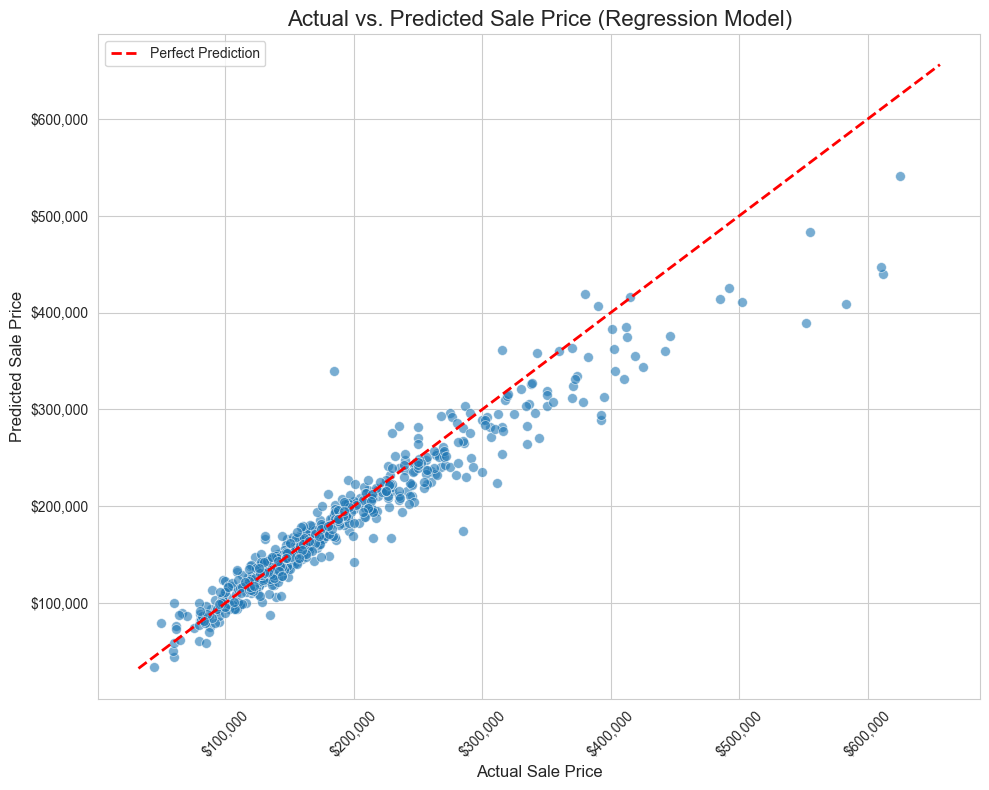

In [70]:
plot_data = pd.DataFrame({
    'Actual Price': y_test,
    'Predicted Price': y_pred_dollar_pipe_test
})

sns.set_style("whitegrid")
plt.figure(figsize=(10, 8))
ax = sns.scatterplot(
    x='Actual Price',
    y='Predicted Price',
    data=plot_data,
    alpha=0.6,
    s=50
)

min_val = min(plot_data['Actual Price'].min(), plot_data['Predicted Price'].min())
max_val = max(plot_data['Actual Price'].max(), plot_data['Predicted Price'].max())

min_val *= 0.95
max_val *= 1.05

ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', lw=2, label='Perfect Prediction')

formatter = StrMethodFormatter('${x:,.0f}')
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

ax.set_title('Actual vs. Predicted Sale Price (Regression Model)', fontsize=16)
ax.set_xlabel('Actual Sale Price', fontsize=12)
ax.set_ylabel('Predicted Sale Price', fontsize=12)
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Feature Importance for Regression

#### This plot shows the Top 20 features our regression model found most predictive of a home's value. With Overall Quality and Garage Cars as key determinants, our engineered variables also made the list (like TotalSF and TotalBathrooms), which validates our feature engineering strategy.


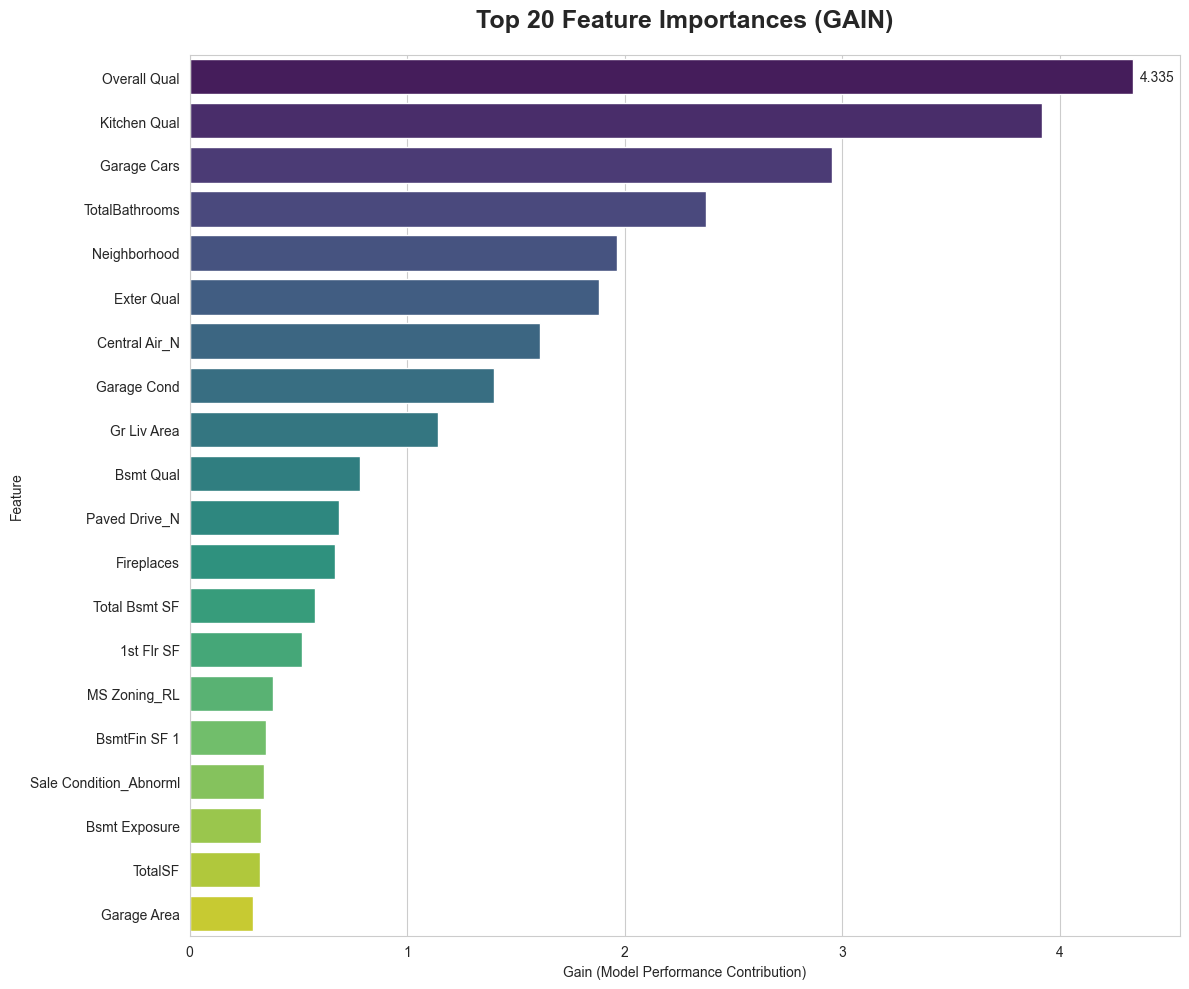

In [161]:
# 1. Extract GAIN importances
# Booster gives raw XGBoost model
booster = final_model_reg.get_booster()
importance_dict = booster.get_score(importance_type='gain')

# Convert to DataFrame
imp_df = (
    pd.DataFrame({
        'feature': list(importance_dict.keys()),
        'importance': list(importance_dict.values())
    })
    .sort_values(by='importance', ascending=False)
    .head(20)
)

# 2. Clean labels (optional, matches your pipeline output)
imp_df['clean_feature'] = imp_df['feature'].str.split('__').str[-1]

# 3. Plot with viridis gradient
plt.figure(figsize=(12, 10))
sns.set_style("whitegrid")

ax = sns.barplot(
    data=imp_df,
    x='importance',
    y='clean_feature',
    palette='viridis'
)

# Label bars
ax.bar_label(
    ax.containers[0],
    fmt='%.3f',
    padding=5
)

# Titles & labels
ax.set_title("Top 20 Feature Importances (GAIN)", fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel("Gain (Model Performance Contribution)")
ax.set_ylabel("Feature")

plt.tight_layout()
plt.savefig("feature_importance_gain.png", dpi=300, bbox_inches='tight')
plt.show()


-----

# 5. Classification - Finding Houses with High Flipping Potential

We can take this analysis a step further. Instead of merely predicting house prices using regression, we can now use classification techniques to determine which houses have the highest "flipping potential."

Here is the step-by-step process we will use:

<br>

### Stage 1: Defining "Intrinsic Value"
We will treat our predicted sale price values as the house's **intrinsic value**.

This is logically sound because our regression model has learned the "standard" market rate for a home based on its features. The regression line effectively cuts through the center of the actual values; therefore, any deviation from this prediction (the residual) represents a house that is either overvalued or undervalued relative to the market norm.

<br>

### Stage 2: Deriving the `Flipping_Potential` Target
Next, we can mathematically derive a binary `Flipping_Potential` variable. We can identify the traits that make a house a good candidate for a real estate agent looking to flip it:
1.  **Price:** It must be lower than its true (intrinsic) value.
2.  **Condition and Renovation Potential:** It must have fixable flaws and renovation potential.
3.  **Market Liquidity/Demand:** We need to ensure the neighborhood the house is in has an active market - signaling demand, suggesting a quicker turn-around time.

Upon taking a closer look at our training data, we can define these specifically:

* **Undervaluation:** We determine this through a simple equation: Intrinsic Value (`y_pred`) is at least 7% higher than Market Price (`y_test`).
* **Renovation Potential:** We need houses that have good "bones" but need cosmetic updates.
    * *Overall Quality* must be solid (e.g., 6+), as structural issues are too costly to fix.
    * We can identify features where improvement yields the highest value gains, such as **Kitchen Quality**, **Exterior Quality**, or **Garage** size.
    * We can also look for a Bathroom Gap—houses with very few bathrooms that would benefit significantly from adding a new one.
* **Market Liquidity/Demand:** We need to filter for neighborhoods with an active market (we'll do this through a threshold for sale count)

We will derive the final target based on these conditions. For example, `Flipping_Potential` returns a `1` if the undervalued condition is met **AND** it has a specific set of fixable flaws (like a poor kitchen in an otherwise good house).

<br>

### Stage 3: The Secondary Train/Test Split
Once the target is derived on our test set, we must perform another train/test split.

Because we used our original training data to build the regression model that *created* this new target, we cannot reuse that data for classification (it would cause data leakage). We must take our original Test Set and split it further into a **Classification Train Set** and a **Classification Validation Set**.

<br>

### Stage 4: Modeling
Finally, we will train our classification models on this new subset of data to predict our engineered target. We will test:
* Logistic Regression (as a baseline)
* Random Forest Classifier
* XGBoost Classifier

<br>

#### **Note:** In an ideal world, we would have access to a real-world investors opinion of each of these houses, and they would manually annotate whether a house would be a good flip (this is doable - all it requires is an investor supplying the data scientist a list of houses he chose to flip or considered in the past, or even considers now.)

#### This would allow us to simulate the experienced investor's brain—enabling the model to pick up on peculiar preferences and innately made decisions which can't be derived mathematically, are invisible to the human eye, and perhaps can't even be articulated by the investor themself. Since we don't have that, we will mathematically derive our own target.

#### In our analysis, the target, due to lack of an investors opinion, is mathematically derived - the intention was to simulate domain knowledge a realtor or investor might have. Due to this, the model's performance is expected to be inflated relative to what could be learned from raw features alone, and relative to what we might see in the real world, should the target be created through real-world annotations from an actual investor.

-------

let's begin:

## Stage 1: Defining "Intrinsic Value"

In [72]:
#as discussed, intrinsic value will be scores predicted by the model. We need to append those to the "test" dataframe.

df_class = X_test.copy()
df_class['Market Price (test)'] = y_test
df_class['Intrinsic Value (pred)'] = y_pred_dollar_pipe_test

print(df_class.shape)
df_class.head()

(586, 81)


,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,Market Price (test),Intrinsic Value (pred)
1357,70,RM,NaN,5100,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,2Story,8,7,1925,1996,Hip,CompShg,Stucco,Wd Shng,NaN,0.0,TA,Gd,PConc,TA,TA,No,Unf,0.0,Unf,0.0,588.0,588.0,GasA,Fa,Y,SBrkr,833,833,0,1666,0.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1925.0,Unf,1.0,228.0,TA,TA,Y,192,63,0,0,0,0,NaN,MnPrv,NaN,0,6,2008,WD,Normal,161000,165920.640625
2367,160,RM,21.0,1890,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,BrDale,Norm,Norm,Twnhs,2Story,6,7,1972,1972,Gable,CompShg,HdBoard,HdBoard,BrkFace,380.0,TA,TA,CBlock,TA,TA,No,ALQ,282.0,Unf,0.0,212.0,494.0,GasA,Ex,Y,SBrkr,494,536,0,1030,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,Detchd,1973.0,Unf,1.0,264.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,7,2006,WD,Normal,116000,99454.476562
2822,60,RL,62.0,7162,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,2Story,7,5,2003,2004,Hip,CompShg,HdBoard,Stucco,BrkFace,190.0,Gd,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,796.0,796.0,GasA,Ex,Y,SBrkr,806,918,0,1724,0.0,0.0,2,1,3,1,Gd,8,Typ,1,Gd,BuiltIn,2003.0,Fin,2.0,616.0,TA,TA,Y,168,57,0,0,0,0,NaN,NaN,NaN,0,5,2006,WD,Normal,196500,173988.218750
2126,20,RL,60.0,8070,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,4,5,1994,1995,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,588.0,Unf,0.0,402.0,990.0,GasA,Ex,Y,SBrkr,990,0,0,990,1.0,0.0,1,0,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,123600,129717.109375
1544,30,RM,50.0,7000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,6,8,1926,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,Gd,BrkTil,TA,TA,No,Rec,299.0,GLQ,40.0,555.0,894.0,GasA,TA,Y,SBrkr,919,0,0,919,1.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Detchd,1926.0,Unf,1.0,195.0,TA,TA,P,0,0,116,0,0,0,NaN,MnPrv,NaN,0,7,2008,WD,Normal,126000,118801.968750


In [73]:
df_class

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,Market Price (test),Intrinsic Value (pred)
1357,70,RM,NaN,5100,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,2Story,8,7,1925,1996,Hip,CompShg,Stucco,Wd Shng,NaN,0.0,TA,Gd,PConc,TA,TA,No,Unf,0.0,Unf,0.0,588.0,588.0,GasA,Fa,Y,SBrkr,833,833,0,1666,0.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1925.0,Unf,1.0,228.0,TA,TA,Y,192,63,0,0,0,0,NaN,MnPrv,NaN,0,6,2008,WD,Normal,161000,165920.640625
2367,160,RM,21.0,1890,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,BrDale,Norm,Norm,Twnhs,2Story,6,7,1972,1972,Gable,CompShg,HdBoard,HdBoard,BrkFace,380.0,TA,TA,CBlock,TA,TA,No,ALQ,282.0,Unf,0.0,212.0,494.0,GasA,Ex,Y,SBrkr,494,536,0,1030,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,Detchd,1973.0,Unf,1.0,264.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,7,2006,WD,Normal,116000,99454.476562
2822,60,RL,62.0,7162,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,2Story,7,5,2003,2004,Hip,CompShg,HdBoard,Stucco,BrkFace,190.0,Gd,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,796.0,796.0,GasA,Ex,Y,SBrkr,806,918,0,1724,0.0,0.0,2,1,3,1,Gd,8,Typ,1,Gd,BuiltIn,2003.0,Fin,2.0,616.0,TA,TA,Y,168,57,0,0,0,0,NaN,NaN,NaN,0,5,2006,WD,Normal,196500,173988.218750
2126,20,RL,60.0,8070,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,4,5,1994,1995,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,588.0,Unf,0.0,402.0,990.0,GasA,Ex,Y,SBrkr,990,0,0,990,1.0,0.0,1,0,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,123600,129717.109375
1544,30,RM,50.0,7000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,6,8,1926,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,Gd,BrkTil,TA,TA,No,Rec,299.0,GLQ,40.0,555.0,894.0,GasA,TA,Y,SBrkr,919,0,0,919,1.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Detchd,1926.0,Unf,1.0,195.0,TA,TA,P,0,0,116,0,0,0,NaN,MnPrv,NaN,0,7,2008,WD,Normal,126000,118801.968750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2268,80,RL,73.0,9590,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Timber,Norm,Norm,1Fam,SLvl,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,442.0,Gd,TA,PConc,Ex,TA,Av,GLQ,786.0,Unf,0.0,82.0,868.0,GasA,Ex,Y,SBrkr,1146,0,0,1146,1.0,0.0,2,0,3,1,Gd,6,Typ,1,Gd,Attchd,2003.0,Fin,2.0,438.0,TA,TA,Y,160,22,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,187500,187069.218750
456,20,RL,100.0,14836,Pave,NaN,IR1,HLS,AllPub,Inside,Mod,NridgHt,Norm,Norm,1Fam,1Story,10,5,2004,2005,Hip,CompShg,CemntBd,CmentBd,Stone,730.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2146.0,Unf,0.0,346.0,2492.0,GasA,Ex,Y,SBrkr,2492,0,0,2492,1.0,0.0,2,1,2,1,Ex,8,Typ,1,Ex,Attchd,2004.0,Fin,3.0,949.0,TA,TA,Y,226,235,0,0,0,0,NaN,NaN,NaN,0,2,2009,WD,Abnorml,552000,389414.125000
462,120,RL,48.0,3480,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,TwnhsE,1Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,Stone,163.0,Gd,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,1405.0,1405.0,GasA,Ex,Y,SBrkr,1405,0,0,1405,0

### Given this interpretation, our scatterplot of actual vs predicted values becomes much more interesting - What it really shows is market inefficecies.

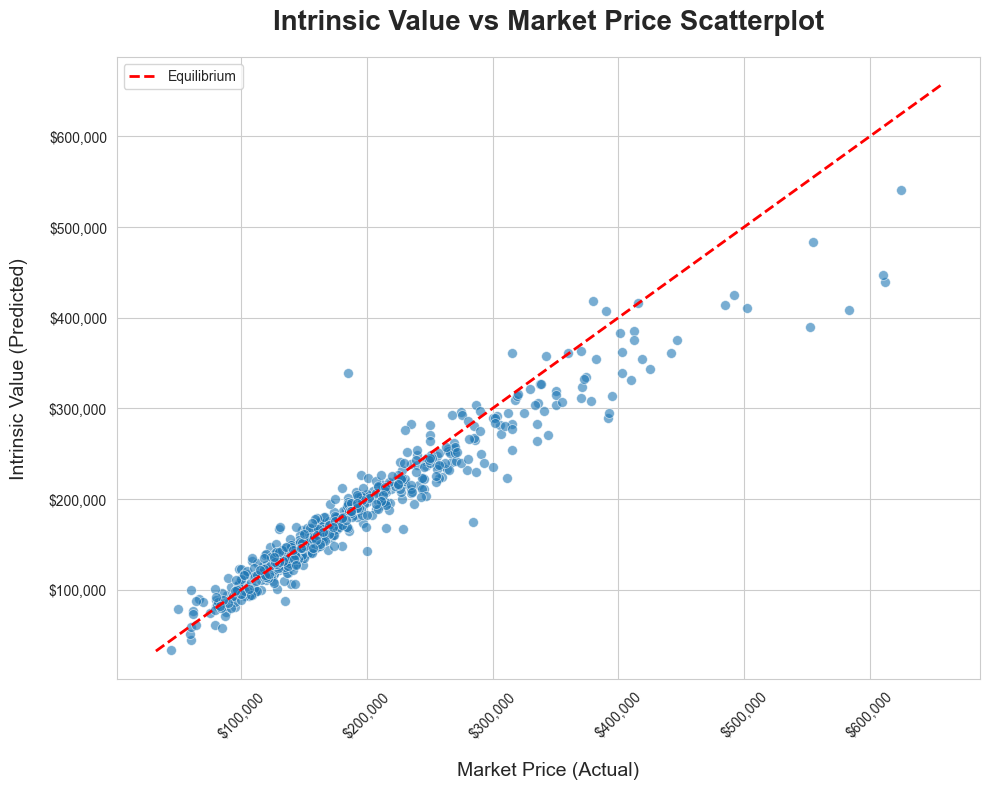

In [74]:
plot_data = pd.DataFrame({
    'Market Price (test)': df_class['Market Price (test)'],
    'Intrinsic Value (pred)': df_class['Intrinsic Value (pred)']
})

sns.set_style("whitegrid")
plt.figure(figsize=(10, 8))
ax = sns.scatterplot(
    x='Market Price (test)',
    y='Intrinsic Value (pred)',
    data=plot_data,
    alpha=0.6,
    s=50
)

min_val = min(plot_data['Market Price (test)'].min(), plot_data['Intrinsic Value (pred)'].min())
max_val = max(plot_data['Market Price (test)'].max(), plot_data['Intrinsic Value (pred)'].max())

min_val *= 0.95
max_val *= 1.05

ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', lw=2, label='Equilibrium')

formatter = StrMethodFormatter('${x:,.0f}')
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

ax.set_title('Intrinsic Value vs Market Price Scatterplot', fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel('Market Price (Actual)', fontsize=14, labelpad=15)
ax.set_ylabel('Intrinsic Value (Predicted)', fontsize=14, labelpad=15)
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Treating our regression model as an "intrinsic/fair value estimator", this graph reveals to us the overpriced and the underpriced homes. The further a house is above the red equilibrium line, the more underpriced the home, which signals flipping potential.

## Stage 2: Deriving the `Flipping_Potential` Target

In [75]:
#let's tackle the "underpriced" binary first - classifying a house as
#underpriced if its intrinsic value is 7%++ higher than the market price

df_class['Underpriced'] = (df_class['Intrinsic Value (pred)'] >= df_class['Market Price (test)'] * 1.07).astype(int)

#we can see we have 66 underpriced homes in the dataset.
print(df_class.Underpriced.value_counts())

Underpriced
0    499
1     87
Name: count, dtype: int64


In [76]:
#a key condition for a house to have good flipping potential is that the overall quality
#needs to be good - structural changes would be too expensive to the investor

qual = df_class[df_class['Overall Qual'] > 6]
print('Total Rows:',len(df_class))
print('Rows with an Overall Qualiy of 7+:',len(qual))

Total Rows: 586
Rows with an Overall Qualiy of 7+: 255


In [77]:
#now let's determine which features, if improved, yield the highest average increase in house value.
#we'll use df_train for these vizualizations, since it provides more data, leading to more robust insights.
#this doesn't leak data since we won't be using the original training set anymore in our classification model.

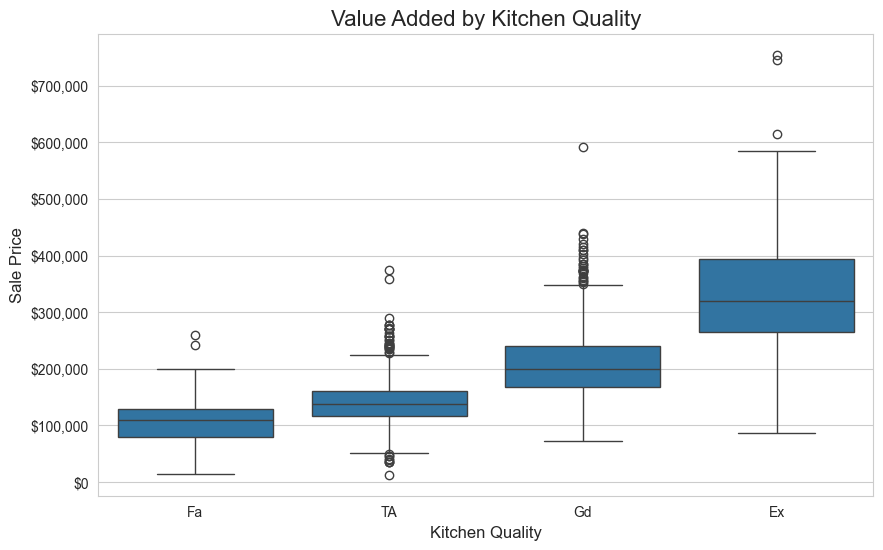

In [78]:
#impact of kitchen quality on sale price:

plt.figure(figsize=(10, 6))

kitchen_order = ['Fa', 'TA', 'Gd', 'Ex']

ax = sns.boxplot(
    x='Kitchen Qual',
    y='SalePrice',
    data=df_train,
    order=kitchen_order,
)

ax.set_title('Value Added by Kitchen Quality', fontsize=16)
ax.set_xlabel('Kitchen Quality', fontsize=12)
ax.set_ylabel('Sale Price', fontsize=12)
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
plt.show()

In [79]:
df_train.groupby('Kitchen Qual')['SalePrice'].mean()

Kitchen Qual
Ex    330569.146667
Fa    106817.677966
Gd    209727.105379
TA    140235.038399
Name: SalePrice, dtype: float64

In [80]:
df_train.groupby('Kitchen Qual')['SalePrice'].median()

Kitchen Qual
Ex    320000.0
Fa    108500.0
Gd    200000.0
TA    137000.0
Name: SalePrice, dtype: float64

##### the above data signals that taking a kitchen from average/good to excellent could greatly increase market value (by an average of $100k+ from good to excellent, and $60k from average to good -> a $160k total premium).

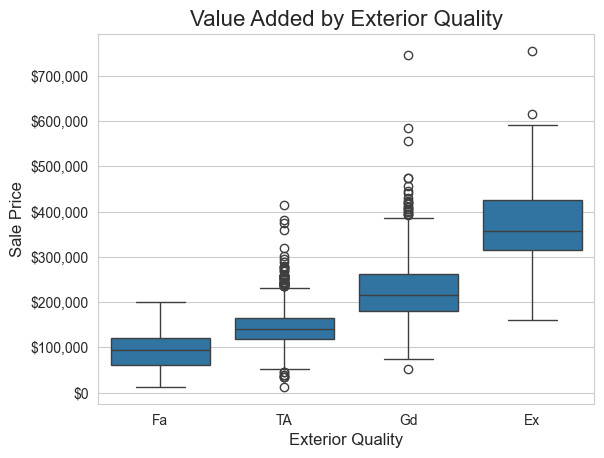

In [81]:
#impact of exterior quality
exter_order = ['Fa', 'TA', 'Gd', 'Ex'] # Define logical order

ax = sns.boxplot(
    x='Exter Qual',
    y='SalePrice',
    data=df_train,
    order=exter_order
)

ax.set_title('Value Added by Exterior Quality', fontsize=16)
ax.set_xlabel('Exterior Quality', fontsize=12)
ax.set_ylabel('Sale Price', fontsize=12)
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
plt.show()

In [82]:
df_train.groupby('Exter Qual')['SalePrice'].mean()

Exter Qual
Ex    366703.451220
Fa     94565.392857
Gd    227855.197930
TA    143564.074606
Name: SalePrice, dtype: float64

In [83]:
df_train.groupby('Exter Qual')['SalePrice'].median()

Exter Qual
Ex    357950.0
Fa     93775.0
Gd    216500.0
TA    139500.0
Name: SalePrice, dtype: float64

##### an increase in external quality also correlates with great increases in market value - ones of up to $200k from average to excellent - this indicates that there is huge value in upgrading curb appeal (e.g. siding)

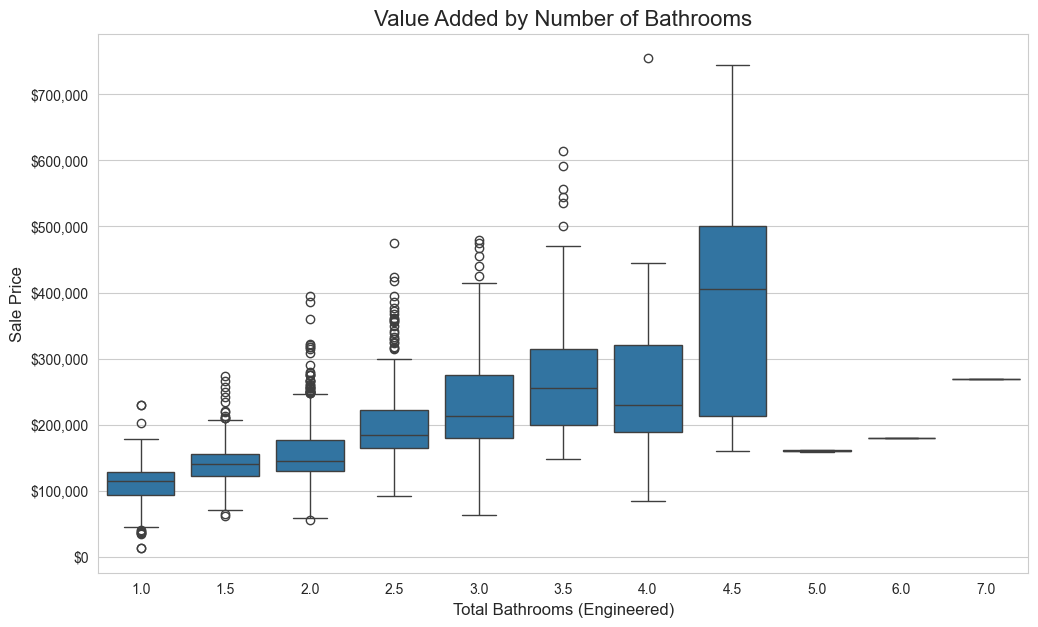

In [84]:
#impact of bathroom count on saleprice

#reengineering feature in df_train
df_train['TotalBathrooms'] = (df_train['Full Bath'] + 0.5*df_train['Half Bath'] + 
                            df_train['Bsmt Full Bath'] + 0.5*df_train['Bsmt Half Bath'])

plt.figure(figsize=(12, 7))
ax = sns.boxplot(
    x='TotalBathrooms',
    y='SalePrice',
    data=df_train
)
ax.set_title('Value Added by Number of Bathrooms', fontsize=16)
ax.set_xlabel('Total Bathrooms (Engineered)', fontsize=12)
ax.set_ylabel('Sale Price', fontsize=12)
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
plt.show()

In [85]:
df_train.groupby('TotalBathrooms')['SalePrice'].median()

TotalBathrooms
1.0    114504.0
1.5    140375.0
2.0    145000.0
2.5    184000.0
3.0    212304.5
3.5    255000.0
4.0    228950.0
4.5    405749.0
5.0    160450.0
6.0    179000.0
7.0    269500.0
Name: SalePrice, dtype: float64

##### an extra bathroom in houses that currently have less than 3 bathrooms is worth an average of ~$45k

Basement quality plot saved as 'basement_quality_boxplot.png'


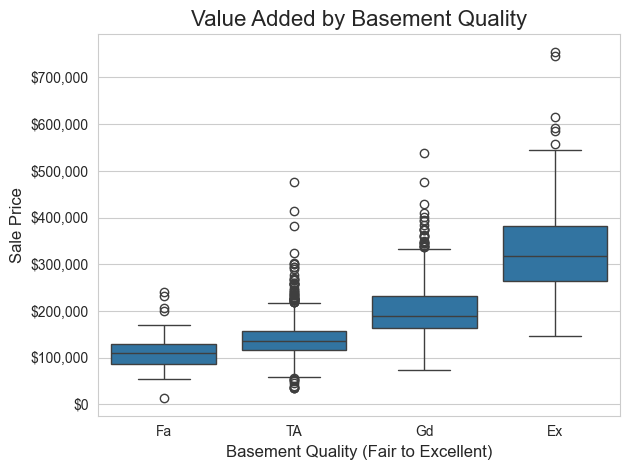

In [86]:
#checking impact of basement quality
bsmt_order = ['Fa', 'TA', 'Gd', 'Ex'] 

ax1 = sns.boxplot(
    x='Bsmt Qual',
    y='SalePrice',
    data=df_train,
    order=bsmt_order
)

ax1.set_title('Value Added by Basement Quality', fontsize=16)
ax1.set_xlabel('Basement Quality (Fair to Excellent)', fontsize=12)
ax1.set_ylabel('Sale Price', fontsize=12)
ax1.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))

plt.tight_layout()
print("Basement quality plot saved as 'basement_quality_boxplot.png'")

##### taking a basement quality to excellent also also correlates with a $100k+ increase

Fireplace quality plot saved as 'fireplace_quality_boxplot.png'


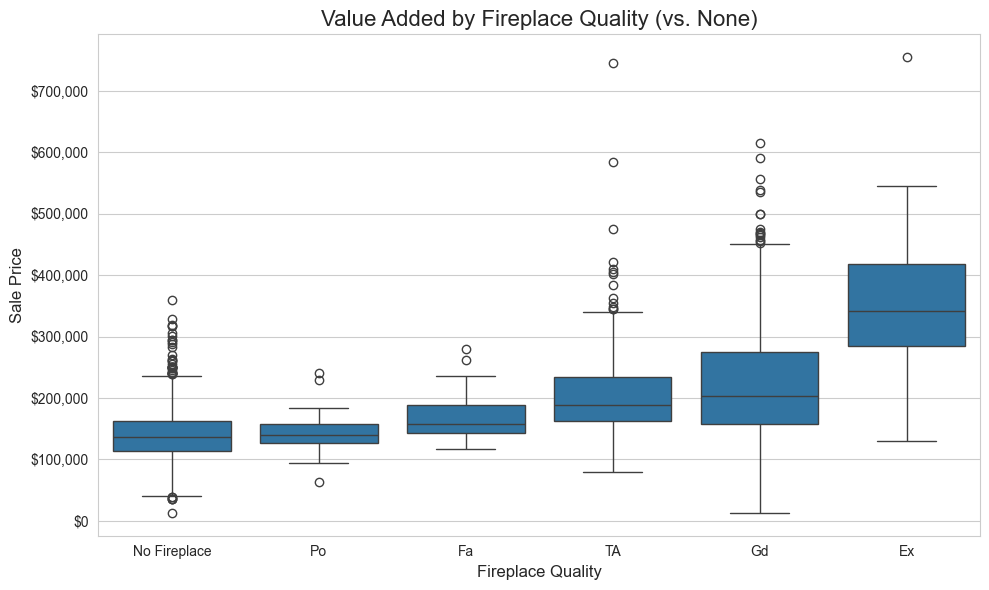

In [87]:
#checking impact of fireplace quality:

df_viz = df_train.copy()

# Fill NaN values with a 'No Fireplace' category
df_viz['Fireplace Qu'] = df_viz['Fireplace Qu'].fillna('No Fireplace')

# Define the logical order, including the new category
fireplace_order = ['No Fireplace', 'Po', 'Fa', 'TA', 'Gd', 'Ex']

plt.figure(figsize=(10, 6))
ax2 = sns.boxplot(
    x='Fireplace Qu',
    y='SalePrice',
    data=df_viz,
    order=fireplace_order
)

ax2.set_title('Value Added by Fireplace Quality (vs. None)', fontsize=16)
ax2.set_xlabel('Fireplace Quality', fontsize=12)
ax2.set_ylabel('Sale Price', fontsize=12)
ax2.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))

plt.tight_layout()
print("Fireplace quality plot saved as 'fireplace_quality_boxplot.png'")

##### taking a fireplace from good to excellent also average around a $100k increase in price value

In [88]:
df_train.head()


,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,TotalBathrooms
381,20,RL,80.0,10400,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,7,5,1976,1976,Gable,CompShg,HdBoard,HdBoard,BrkFace,189.0,TA,TA,CBlock,Gd,TA,No,Unf,0.0,Unf,0.0,1090.0,1090.0,GasA,TA,Y,SBrkr,1370,0,0,1370,0.0,0.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,479.0,TA,TA,Y,0,0,0,0,0,0,NaN,MnPrv,NaN,0,6,2009,WD,Family,152000,2.0
834,60,RL,NaN,28698,Pave,NaN,IR2,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,2Story,5,5,1967,1967,Flat,Tar&Grv,Plywood,Plywood,NaN,0.0,TA,TA,PConc,TA,Gd,Gd,LwQ,249.0,ALQ,764.0,0.0,1013.0,GasA,TA,Y,SBrkr,1160,966,0,2126,0.0,1.0,2,1,3,1,TA,7,Min2,0,NaN,Attchd,1967.0,Fin,2.0,538.0,TA,TA,Y,486,0,0,0,225,0,NaN,NaN,NaN,0,6,2009,WD,Abnorml,185000,3.0
1898,90,RL,70.0,9842,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,NAmes,Norm,Norm,Duplex,1Story,4,5,1962,1962,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,TA,TA,Slab,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,TA,Y,SBrkr,1224,0,0,1224,0.0,0.0,2,0,2,2,TA,6,Typ,0,NaN,CarPort,1962.0,Unf,2.0,462.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,3,2007,WD,Normal,101800,2.0
678,90,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,Duplex,1Story,4,5,1949,1950,Gable,CompShg,BrkFace,Stone,NaN,0.0,TA,TA,Slab,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,Wall,Fa,N,FuseF,1040,0,0,1040,0.0,0.0,2,0,2,2,TA,6,Typ,0,NaN,Detchd,1956.0,Unf,2.0,420.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal,90000,2.0
700,190,RM,63.0,7627,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Artery,Norm,2fmCon,2Story,4,6,1920,1950,Gable,CompShg,AsbShng,AsbShng,NaN,0.0,Fa,TA,BrkTil,Fa,Po,No,Unf,0.0,Unf,0.0,600.0,600.0,GasA,Gd,N,SBrkr,1101,600,0,1701,0.0,0.0,2,0,4,2,Fa,8,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,N,0,0,148,0,0,0,NaN,NaN,NaN,0,10,2009,WD,Normal,94550,2.0


---

##### **NOTE:** While the plots show that upgrading a single feature like a kitchen or basement from 'Average' to 'Excellent' correlates with a ~$100k+ jump in sale price, this is not additive. You cannot add five $100k upgrades and expect a $500k increase in value.

##### This is because these quality features are highly collinear and confounded by the `Overall Qual` of the home. A house with an 'Excellent' kitchen likely also has an 'Excellent' basement, and both are symptoms of a high-end property.

---

#### Plotting multicolinearity:

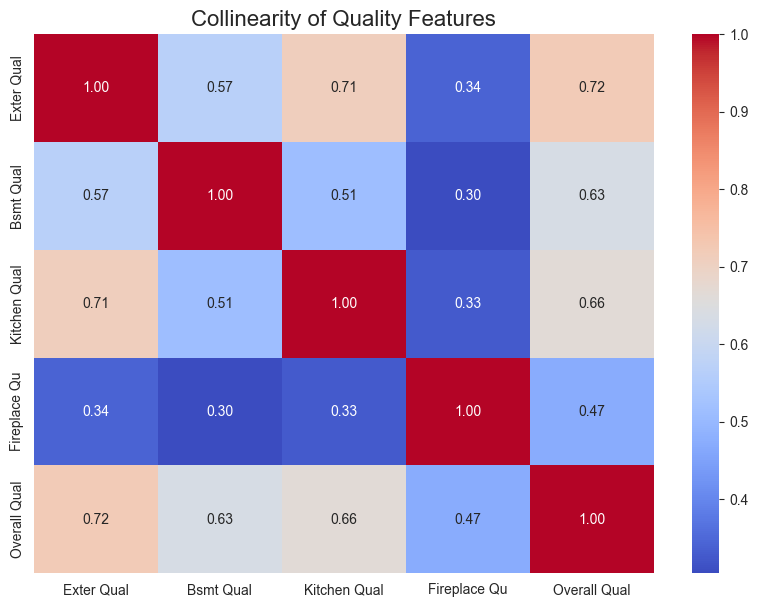

In [89]:
qual_features = ['Exter Qual', 'Bsmt Qual', 'Kitchen Qual', 'Fireplace Qu', 'Overall Qual']

# Create a copy for this plot
df_corr = df_train[qual_features].copy()

# Define the ordinal mapping
# We fill NaNs (like 'No Fireplace') with a 0
qual_map = {
    np.nan: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5
}

# Apply the mapping to all columns
for col in ['Exter Qual', 'Bsmt Qual', 'Kitchen Qual', 'Fireplace Qu']:
    df_corr[col] = df_corr[col].map(qual_map)
    # Fill any NaNs that weren't caught by the map (e.g., in BsmtQual)
    df_corr[col] = df_corr[col].fillna(0) 

# --- 2. Calculate the correlation matrix ---
corr_matrix = df_corr.corr()

# --- 3. Plot the heatmap ---
plt.figure(figsize=(10, 7))
sns.heatmap(
    corr_matrix, 
    annot=True,     # Show the numbers in the squares
    cmap='coolwarm',# Use a blue-to-red color scheme
    fmt='.2f'       # Format numbers to 2 decimal places
)
plt.title('Collinearity of Quality Features', fontsize=16)
plt.show()

### Note on Causality and Strategy:

Despite the colineariy above, and while we can't prove a purely causal link (e.g., "upgrading this kitchen *caused* a $50k increase") from this data alone, the strong correlation is undeniable.

Our model's true value comes from its focused approach. It has already filtered for high-quality homes (`Overall Qual` 7+), so it's comparing 'good' homes to 'great' ones. Within this high-value bracket, our classification model learns to pinpoint which *specific cosmetic flaws* (like an 'Average' kitchen in an otherwise 'Good' house) represent the most profitable renovation opportunities.

This data-driven insight is designed to **complement, not replace** an investor's own experience and intuition, allowing them to find the "diamond in the rough" homes that others might overlook.

---

In [90]:
#lastly, we need to ensure market liquidity. finding the neighborhoods with active sales and demand.
sale_by_neigh = df_train['Neighborhood'].value_counts()
sale_by_neigh

Neighborhood
NAmes      367
CollgCr    211
OldTown    199
Edwards    150
Gilbert    138
Somerst    136
NridgHt    121
Sawyer     119
NWAmes     109
SawyerW     98
Mitchel     97
Crawfor     89
BrkSide     84
IDOTRR      73
Timber      59
NoRidge     57
SWISU       37
StoneBr     36
ClearCr     35
MeadowV     28
BrDale      24
Blmngtn     23
Veenker     22
NPkVill     15
Greens       7
Blueste      7
GrnHill      2
Landmrk      1
Name: count, dtype: int64

in our model, we'll filter for Neighborhoods with at least 50 sales in the period

In [91]:
high_demand_neighborhood = sale_by_neigh[sale_by_neigh > 50]
high_demand_neighborhood_list = high_demand_neighborhood.index.tolist()

#### Creating the `Flipping_Potential` variable. Our conditions will be:
- underpriced (look to start of step 2 for formula)
- overall quality 6+
- a neighborhood with at least 50 sales across the period
- at least 3 of the following:
    - a `Kitchen Qual` of TA (average) or Gd
    - an `Exter Qual` of TA or Gd
    - a `Bsmt Qual` of TA or Gd
    - a `Fireplace Qu` of Fa (fair), TA or Gd
    - between 1-2.5 `TotalBathrooms`


#### **Note:** This bears repeating: In an ideal world, we would have access to a real-world investors opinion of each of these houses, and they would manually annotate whether a house would be a good flip (this is doable - all it requires is an investor supplying the data scientist a list of houses he chose to flip or considered in the past, or even considers now.)

#### This would allow us to simulate the experienced investor's brain—enabling the model to pick up on peculiar preferences and innately made decisions which can't be derived mathematically, are invisible to the human eye, and perhaps can't even be articulated by the investor themself. Since we don't have that, we will mathematically derive our own target.

#### In our analysis, the target, due to lack of an investors opinion, is mathematically derived - the intention was to simulate domain knowledge a realtor or investor might have. Due to this, the model's performance is expected to be inflated relative to what could be learned from raw features alone, and relative to what we might see in the real world, should the target be created through real-world addnotations from an actual investor.

In [92]:
# --- 1. Define Condition 1: Underpriced ---
C1_underpriced = (df_class['Underpriced'] == 1)

# --- 2. Define Condition 2: Good Base ---
C2_good_base = (df_class['Overall Qual'] >= 6)

# --- 3. Define Condition 3: Market Liquidity ---
C3_liquid_market = df_class['Neighborhood'].isin(high_demand_neighborhood_list)

# --- 4. Define Condition 4: Renovation Score (3+ opportunities) ---

# We still need to re-engineer TotalBathrooms
df_class['TotalBathrooms'] = (df_class['Full Bath'] + 0.5 * df_class['Half Bath'] + 
                              df_class['Bsmt Full Bath'] + 0.5 * df_class['Bsmt Half Bath'])

# Fill NaNs for FireplaceQu so we can check it
df_class['Fireplace Qu'] = df_class['Fireplace Qu'].fillna('No Fireplace')

# Create a boolean (True/False) Series for each sub-condition
sub_c1_kitchen = df_class['Kitchen Qual'].isin(['TA', 'Gd'])
sub_c2_exter = df_class['Exter Qual'].isin(['Fa', 'TA', 'Gd'])
sub_c3_bsmt = df_class['Bsmt Qual'].isin(['TA', 'Gd'])
sub_c4_bath = df_class['TotalBathrooms'].isin([1, 1.5, 2.0, 2.5])
sub_c5_fireplace = df_class['Fireplace Qu'].isin(['TA', 'Gd'])

# Add up the conditions (True=1, False=0).
# The result is a total "Renovation Score" (0-5) for each house.
renovation_score = (
    sub_c1_kitchen.astype(int) + 
    sub_c2_exter.astype(int) + 
    sub_c3_bsmt.astype(int) + 
    sub_c4_bath.astype(int) +
    sub_c5_fireplace.astype(int)
)

# The final condition is True if the score is 2 or more
C4_renovation_potential = (renovation_score >= 2)

# --- 5. Combine All Conditions to Create Final Target ---
# A house is a "Good Flip" (1) if *all four* main conditions are True.
df_class['Flipping_Potential'] = np.where(
    C1_underpriced & 
    C2_good_base & 
    C3_liquid_market & 
    C4_renovation_potential,
    1, 
    0
)

#checking split
print('Counts:')
print(df_class['Flipping_Potential'].value_counts())
print()
print('Percentages:')
print(df_class['Flipping_Potential'].value_counts(normalize=True))

Counts:
Flipping_Potential
0    548
1     38
Name: count, dtype: int64

Percentages:
Flipping_Potential
0    0.935154
1    0.064846
Name: proportion, dtype: float64


In [93]:
df_class

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,Market Price (test),Intrinsic Value (pred),Underpriced,TotalBathrooms,Flipping_Potential
1357,70,RM,NaN,5100,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,2Story,8,7,1925,1996,Hip,CompShg,Stucco,Wd Shng,NaN,0.0,TA,Gd,PConc,TA,TA,No,Unf,0.0,Unf,0.0,588.0,588.0,GasA,Fa,Y,SBrkr,833,833,0,1666,0.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1925.0,Unf,1.0,228.0,TA,TA,Y,192,63,0,0,0,0,NaN,MnPrv,NaN,0,6,2008,WD,Normal,161000,165920.640625,0,1.0,0
2367,160,RM,21.0,1890,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,BrDale,Norm,Norm,Twnhs,2Story,6,7,1972,1972,Gable,CompShg,HdBoard,HdBoard,BrkFace,380.0,TA,TA,CBlock,TA,TA,No,ALQ,282.0,Unf,0.0,212.0,494.0,GasA,Ex,Y,SBrkr,494,536,0,1030,0.0,0.0,1,1,3,1,TA,6,Typ,0,No Fireplace,Detchd,1973.0,Unf,1.0,264.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,7,2006,WD,Normal,116000,99454.476562,0,1.5,0
2822,60,RL,62.0,7162,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,2Story,7,5,2003,2004,Hip,CompShg,HdBoard,Stucco,BrkFace,190.0,Gd,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,796.0,796.0,GasA,Ex,Y,SBrkr,806,918,0,1724,0.0,0.0,2,1,3,1,Gd,8,Typ,1,Gd,BuiltIn,2003.0,Fin,2.0,616.0,TA,TA,Y,168,57,0,0,0,0,NaN,NaN,NaN,0,5,2006,WD,Normal,196500,173988.218750,0,2.5,0
2126,20,RL,60.0,8070,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,4,5,1994,1995,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,588.0,Unf,0.0,402.0,990.0,GasA,Ex,Y,SBrkr,990,0,0,990,1.0,0.0,1,0,3,1,TA,5,Typ,0,No Fireplace,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,123600,129717.109375,0,2.0,0
1544,30,RM,50.0,7000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,6,8,1926,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,Gd,BrkTil,TA,TA,No,Rec,299.0,GLQ,40.0,555.0,894.0,GasA,TA,Y,SBrkr,919,0,0,919,1.0,0.0,1,0,2,1,TA,5,Typ,0,No Fireplace,Detchd,1926.0,Unf,1.0,195.0,TA,TA,P,0,0,116,0,0,0,NaN,MnPrv,NaN,0,7,2008,WD,Normal,126000,118801.968750,0,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2268,80,RL,73.0,9590,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Timber,Norm,Norm,1Fam,SLvl,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,442.0,Gd,TA,PConc,Ex,TA,Av,GLQ,786.0,Unf,0.0,82.0,868.0,GasA,Ex,Y,SBrkr,1146,0,0,1146,1.0,0.0,2,0,3,1,Gd,6,Typ,1,Gd,Attchd,2003.0,Fin,2.0,438.0,TA,TA,Y,160,22,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,187500,187069.218750,0,3.0,0
456,20,RL,100.0,14836,Pave,NaN,IR1,HLS,AllPub,Inside,Mod,NridgHt,Norm,Norm,1Fam,1Story,10,5,2004,2005,Hip,CompShg,CemntBd,CmentBd,Stone,730.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2146.0,Unf,0.0,346.0,2492.0,GasA,Ex,Y,SBrkr,2492,0,0,2492,1.0,0.0,2,1,2,1,Ex,8,Typ,1,Ex,Attchd,2004.0,Fin,3.0,949.0,TA,TA,Y,226,235,0,0,0,0,NaN,NaN,NaN,0,2,2009,WD,Abnorml,552000,389414.125000,0,3.5,0
462,120,RL,48.0,3480,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,TwnhsE,1Sto

## Stage 3: The Secondary Train Test Split

In [94]:
#further train test splitting our data

X_class_prepared = df_class.drop(['Flipping_Potential'], axis=1)
y_class = df_class['Flipping_Potential']

X_T_train, X_T_val, y_T_train, y_T_val = train_test_split(
    X_class_prepared, 
    y_class, 
    test_size=0.4, 
    random_state=42,
    stratify=y_class
)

In [95]:
print(X_T_val.shape)
X_T_val.head()

(235, 83)


,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,Market Price (test),Intrinsic Value (pred),Underpriced,TotalBathrooms
2319,60,RL,72.0,10463,Pave,NaN,IR1,HLS,AllPub,CulDSac,Gtl,Gilbert,Norm,Norm,1Fam,2Story,8,5,2005,2005,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,Gd,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,893.0,893.0,GasA,Ex,Y,SBrkr,901,900,0,1801,0.0,0.0,2,1,3,1,Gd,8,Typ,1,Gd,Attchd,2005.0,Fin,3.0,800.0,TA,TA,Y,0,116,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal,239900,237324.000000,0,2.5
80,20,RL,81.0,9672,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,SawyerW,Norm,Norm,1Fam,1Story,6,5,1984,1985,Hip,CompShg,HdBoard,Plywood,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,338.0,Unf,0.0,702.0,1040.0,GasA,TA,Y,SBrkr,1097,0,0,1097,0.0,0.0,2,0,3,1,TA,6,Typ,0,No Fireplace,Attchd,1986.0,Unf,2.0,480.0,TA,TA,Y,0,0,0,0,0,0,NaN,GdPrv,NaN,0,5,2010,WD,Normal,152000,142509.406250,0,2.0
1738,60,RL,72.0,8229,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,2007,2007,Gable,CompShg,VinylSd,VinylSd,Stone,22.0,Gd,TA,PConc,Gd,TA,Av,Unf,0.0,Unf,0.0,752.0,752.0,GasA,Ex,Y,SBrkr,752,752,0,1504,0.0,0.0,2,1,3,1,Gd,6,Typ,0,No Fireplace,Attchd,2007.0,Fin,2.0,440.0,TA,TA,Y,100,32,0,0,0,0,NaN,NaN,NaN,0,12,2007,New,Partial,166000,180601.625000,1,2.5
1880,20,RL,NaN,12342,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,5,1960,1978,Hip,CompShg,Wd Sdng,Wd Sdng,NaN,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,978.0,978.0,GasA,TA,Y,SBrkr,1422,0,0,1422,0.0,0.0,1,0,3,1,TA,6,Min1,1,TA,Attchd,1960.0,RFn,1.0,286.0,TA,TA,Y,0,0,36,0,0,0,NaN,GdWo,Shed,600,8,2007,WD,Normal,139900,137661.265625,0,1.0
1486,90,RL,67.0,8777,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Feedr,Norm,Duplex,1.5Fin,5,7,1900,2003,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1084.0,Unf,0.0,188.0,1272.0,GasA,Gd,Y,SBrkr,1272,928,0,2200,2.0,0.0,2,2,4,2,TA,9,Typ,0,No Fireplace,NaN,NaN,NaN,0.0,0.0,NaN,NaN,N,0,70,0,0,0,0,NaN,GdPrv,NaN,0,9,2008,WD,Normal,145900,154377.343750,0,5.0


In [96]:
print(X_T_train.shape)
X_T_train.head()

(351, 83)


,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,Market Price (test),Intrinsic Value (pred),Underpriced,TotalBathrooms
221,20,RL,NaN,8246,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,8,1968,2001,Gable,CompShg,Plywood,Plywood,NaN,0.0,TA,Gd,CBlock,TA,TA,Mn,Rec,188.0,ALQ,668.0,204.0,1060.0,GasA,Ex,Y,SBrkr,1060,0,0,1060,1.0,0.0,1,0,3,1,Gd,6,Typ,1,TA,Attchd,1968.0,Unf,1.0,270.0,TA,TA,Y,406,90,0,0,0,0,NaN,MnPrv,NaN,0,5,2010,WD,Normal,154000,149468.453125,0,2.0
1461,20,RL,NaN,14860,Pave,NaN,IR2,Lvl,AllPub,CulDSac,Gtl,CollgCr,Norm,Norm,1Fam,1Story,8,5,2002,2003,Hip,CompShg,VinylSd,VinylSd,BrkFace,240.0,Gd,TA,PConc,Ex,TA,Gd,GLQ,1538.0,Unf,0.0,240.0,1778.0,GasA,Ex,Y,SBrkr,1786,0,0,1786,1.0,0.0,2,0,3,1,Gd,6,Typ,1,Gd,Attchd,2002.0,RFn,3.0,715.0,TA,TA,Y,182,35,0,0,0,0,NaN,NaN,NaN,0,6,2008,WD,Normal,300000,289359.875000,0,3.0
2153,60,RL,NaN,15295,Pave,NaN,IR3,Lvl,AllPub,Corner,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,1996,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,254.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,762.0,Unf,0.0,98.0,860.0,GasA,Ex,Y,SBrkr,1212,780,0,1992,1.0,0.0,2,1,3,1,Gd,7,Min2,2,TA,Attchd,1996.0,RFn,2.0,608.0,TA,TA,Y,225,32,0,0,0,0,NaN,NaN,NaN,0,6,2007,WD,Normal,211000,226935.625000,1,3.5
1426,20,RL,91.0,11778,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,PosN,Norm,1Fam,1Story,9,5,2008,2008,Hip,CompShg,VinylSd,VinylSd,Stone,402.0,Ex,TA,PConc,Ex,TA,Av,GLQ,1153.0,Unf,0.0,598.0,1751.0,GasA,Ex,Y,SBrkr,1766,0,0,1766,1.0,0.0,2,1,3,1,Ex,8,Typ,2,Gd,Attchd,2008.0,Fin,3.0,874.0,TA,TA,Y,216,36,0,0,0,0,NaN,NaN,NaN,0,12,2008,New,Partial,395039,313058.656250,0,3.5
1010,60,RL,101.0,13543,Pave,NaN,IR1,HLS,AllPub,Corner,Gtl,StoneBr,Norm,Norm,1Fam,2Story,8,5,2005,2005,Gable,CompShg,VinylSd,VinylSd,Stone,130.0,Gd,TA,PConc,Ex,TA,Gd,GLQ,16.0,Unf,0.0,1152.0,1168.0,GasA,Ex,Y,SBrkr,1168,1332,0,2500,0.0,0.0,3,1,5,1,Ex,9,Typ,1,Gd,BuiltIn,2005.0,Fin,3.0,683.0,TA,TA,Y,192,32,0,0,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal,355000,307179.843750,0,3.5


In [97]:
#running our new training/test sets through the pipeline:
X_T_train_prepared = preprocessing_pipeline.transform(X_T_train)
X_T_val_prepared = preprocessing_pipeline.transform(X_T_val)



In [98]:
print(X_T_train_prepared.shape)
X_T_train_prepared.head()

(351, 168)


,num_median__Year Built,num_median__Year Remod/Add,num_median__Overall Qual,num_median__Overall Cond,num_median__1st Flr SF,num_median__2nd Flr SF,num_median__Gr Liv Area,num_median__Full Bath,num_median__Half Bath,num_median__Bedroom AbvGr,num_median__Kitchen AbvGr,num_median__TotRms AbvGrd,num_median__TotalSF,num_median__AgeAtSale,num_median__TimeSinceRemod,num_median__TotalBathrooms,num_zero__Lot Frontage,num_zero__Wood Deck SF,num_zero__Pool Area,num_zero__Bsmt Unf SF,num_zero__Screen Porch,num_zero__3Ssn Porch,num_zero__Lot Area,num_zero__BsmtFin SF 2,num_zero__Bsmt Full Bath,num_zero__Garage Cars,num_zero__Total Bsmt SF,num_zero__Enclosed Porch,num_zero__BsmtFin SF 1,num_zero__Low Qual Fin SF,num_zero__Yr Sold,num_zero__Bsmt Half Bath,num_zero__Fireplaces,num_zero__Mas Vnr Area,num_zero__Misc Val,num_zero__Open Porch SF,num_zero__Garage Area,cat_ohe_mode__House Style_1.5Fin,cat_ohe_mode__House Style_1Story,cat_ohe_mode__House Style_2Story,cat_ohe_mode__House Style_SFoyer,cat_ohe_mode__House Style_SLvl,cat_ohe_mode__House Style_infrequent_sklearn,cat_ohe_mode__Sale Condition_Abnorml,cat_ohe_mode__Sale Condition_Family,cat_ohe_mode__Sale Condition_Normal,cat_ohe_mode__Sale Condition_Partial,cat_ohe_mode__Sale Condition_infrequent_sklearn,cat_ohe_mode__Roof Style_Gable,cat_ohe_mode__Roof Style_Hip,cat_ohe_mode__Roof Style_infrequent_sklearn,cat_ohe_mode__Paved Drive_N,cat_ohe_mode__Paved Drive_P,cat_ohe_mode__Paved Drive_Y,cat_ohe_mode__Bldg Type_1Fam,cat_ohe_mode__Bldg Type_2fmCon,cat_ohe_mode__Bldg Type_Duplex,cat_ohe_mode__Bldg Type_Twnhs,cat_ohe_mode__Bldg Type_TwnhsE,cat_ohe_mode__Street_Pave,cat_ohe_mode__Street_infrequent_sklearn,cat_ohe_mode__Condition 2_Norm,cat_ohe_mode__Condition 2_infrequent_sklearn,cat_ohe_mode__Land Slope_Gtl,cat_ohe_mode__Land Slope_Mod,cat_ohe_mode__Land Slope_infrequent_sklearn,cat_ohe_mode__Foundation_BrkTil,cat_ohe_mode__Foundation_CBlock,cat_ohe_mode__Foundation_PConc,cat_ohe_mode__Foundation_Slab,cat_ohe_mode__Foundation_infrequent_sklearn,cat_ohe_mode__Land Contour_Bnk,cat_ohe_mode__Land Contour_HLS,cat_ohe_mode__Land Contour_Low,cat_ohe_mode__Land Contour_Lvl,cat_ohe_mode__Condition 1_Artery,cat_ohe_mode__Condition 1_Feedr,cat_ohe_mode__Condition 1_Norm,cat_ohe_mode__Condition 1_RRAn,cat_ohe_mode__Condition 1_infrequent_sklearn,cat_ohe_mode__MS Zoning_FV,cat_ohe_mode__MS Zoning_RL,cat_ohe_mode__MS Zoning_RM,cat_ohe_mode__MS Zoning_infrequent_sklearn,cat_ohe_mode__Heating_GasA,cat_ohe_mode__Heating_infrequent_sklearn,cat_ohe_mode__Central Air_N,cat_ohe_mode__Central Air_Y,cat_ohe_mode__Lot Config_Corner,cat_ohe_mode__Lot Config_CulDSac,cat_ohe_mode__Lot Config_FR2,cat_ohe_mode__Lot Config_Inside,cat_ohe_mode__Lot Config_infrequent_sklearn,cat_ohe_mode__Electrical_FuseA,cat_ohe_mode__Electrical_FuseF,cat_ohe_mode__Electrical_SBrkr,cat_ohe_mode__Electrical_infrequent_sklearn,cat_ohe_mode__Roof Matl_CompShg,cat_ohe_mode__Roof Matl_infrequent_sklearn,cat_ohe_mode__Lot Shape_IR1,cat_ohe_mode__Lot Shape_IR2,cat_ohe_mode__Lot Shape_Reg,cat_ohe_mode__Lot Shape_infrequent_sklearn,cat_ohe_mode__MS SubClass_20,cat_ohe_mode__MS SubClass_30,cat_ohe_mode__MS SubClass_50,cat_ohe_mode__MS SubClass_60,cat_ohe_mode__MS SubClass_70,cat_ohe_mode__MS SubClass_80,cat_ohe_mode__MS SubClass_85,cat_ohe_mode__MS SubClass_90,cat_ohe_mode__MS SubClass_120,cat_ohe_mode__MS SubClass_160,cat_ohe_mode__MS SubClass_190,cat_ohe_mode__MS SubClass_infrequent_sklearn,cat_ohe_mode__Mo Sold_1,cat_ohe_mode__Mo Sold_2,cat_ohe_mode__Mo Sold_3,cat_ohe_mode__Mo Sold_4,cat_ohe_mode__Mo Sold_5,cat_ohe_mode__Mo Sold_6,cat_ohe_mode__Mo Sold_7,cat_ohe_mode__Mo Sold_8,cat_ohe_mode__Mo Sold_9,cat_ohe_mode__Mo Sold_10,cat_ohe_mode__Mo Sold_11,cat_ohe_mode__Mo Sold_12,cat_ohe_miss__Pool QC_0,cat_ohe_miss__Pool QC_infrequent_sklearn,cat_ohe_miss__Misc Feature_0,cat_ohe_miss__Misc Feature_1,cat_ohe_miss__Alley_0,cat_ohe_miss__Alley_1,cat_ohe_miss__Garage Finish_Fin,cat_ohe_miss__Garage Finish_Missing,cat_ohe_miss__Garage Finish_RFn,cat_ohe

In [99]:
print(X_T_val_prepared.shape)
X_T_val_prepared.head()

(235, 168)


,num_median__Year Built,num_median__Year Remod/Add,num_median__Overall Qual,num_median__Overall Cond,num_median__1st Flr SF,num_median__2nd Flr SF,num_median__Gr Liv Area,num_median__Full Bath,num_median__Half Bath,num_median__Bedroom AbvGr,num_median__Kitchen AbvGr,num_median__TotRms AbvGrd,num_median__TotalSF,num_median__AgeAtSale,num_median__TimeSinceRemod,num_median__TotalBathrooms,num_zero__Lot Frontage,num_zero__Wood Deck SF,num_zero__Pool Area,num_zero__Bsmt Unf SF,num_zero__Screen Porch,num_zero__3Ssn Porch,num_zero__Lot Area,num_zero__BsmtFin SF 2,num_zero__Bsmt Full Bath,num_zero__Garage Cars,num_zero__Total Bsmt SF,num_zero__Enclosed Porch,num_zero__BsmtFin SF 1,num_zero__Low Qual Fin SF,num_zero__Yr Sold,num_zero__Bsmt Half Bath,num_zero__Fireplaces,num_zero__Mas Vnr Area,num_zero__Misc Val,num_zero__Open Porch SF,num_zero__Garage Area,cat_ohe_mode__House Style_1.5Fin,cat_ohe_mode__House Style_1Story,cat_ohe_mode__House Style_2Story,cat_ohe_mode__House Style_SFoyer,cat_ohe_mode__House Style_SLvl,cat_ohe_mode__House Style_infrequent_sklearn,cat_ohe_mode__Sale Condition_Abnorml,cat_ohe_mode__Sale Condition_Family,cat_ohe_mode__Sale Condition_Normal,cat_ohe_mode__Sale Condition_Partial,cat_ohe_mode__Sale Condition_infrequent_sklearn,cat_ohe_mode__Roof Style_Gable,cat_ohe_mode__Roof Style_Hip,cat_ohe_mode__Roof Style_infrequent_sklearn,cat_ohe_mode__Paved Drive_N,cat_ohe_mode__Paved Drive_P,cat_ohe_mode__Paved Drive_Y,cat_ohe_mode__Bldg Type_1Fam,cat_ohe_mode__Bldg Type_2fmCon,cat_ohe_mode__Bldg Type_Duplex,cat_ohe_mode__Bldg Type_Twnhs,cat_ohe_mode__Bldg Type_TwnhsE,cat_ohe_mode__Street_Pave,cat_ohe_mode__Street_infrequent_sklearn,cat_ohe_mode__Condition 2_Norm,cat_ohe_mode__Condition 2_infrequent_sklearn,cat_ohe_mode__Land Slope_Gtl,cat_ohe_mode__Land Slope_Mod,cat_ohe_mode__Land Slope_infrequent_sklearn,cat_ohe_mode__Foundation_BrkTil,cat_ohe_mode__Foundation_CBlock,cat_ohe_mode__Foundation_PConc,cat_ohe_mode__Foundation_Slab,cat_ohe_mode__Foundation_infrequent_sklearn,cat_ohe_mode__Land Contour_Bnk,cat_ohe_mode__Land Contour_HLS,cat_ohe_mode__Land Contour_Low,cat_ohe_mode__Land Contour_Lvl,cat_ohe_mode__Condition 1_Artery,cat_ohe_mode__Condition 1_Feedr,cat_ohe_mode__Condition 1_Norm,cat_ohe_mode__Condition 1_RRAn,cat_ohe_mode__Condition 1_infrequent_sklearn,cat_ohe_mode__MS Zoning_FV,cat_ohe_mode__MS Zoning_RL,cat_ohe_mode__MS Zoning_RM,cat_ohe_mode__MS Zoning_infrequent_sklearn,cat_ohe_mode__Heating_GasA,cat_ohe_mode__Heating_infrequent_sklearn,cat_ohe_mode__Central Air_N,cat_ohe_mode__Central Air_Y,cat_ohe_mode__Lot Config_Corner,cat_ohe_mode__Lot Config_CulDSac,cat_ohe_mode__Lot Config_FR2,cat_ohe_mode__Lot Config_Inside,cat_ohe_mode__Lot Config_infrequent_sklearn,cat_ohe_mode__Electrical_FuseA,cat_ohe_mode__Electrical_FuseF,cat_ohe_mode__Electrical_SBrkr,cat_ohe_mode__Electrical_infrequent_sklearn,cat_ohe_mode__Roof Matl_CompShg,cat_ohe_mode__Roof Matl_infrequent_sklearn,cat_ohe_mode__Lot Shape_IR1,cat_ohe_mode__Lot Shape_IR2,cat_ohe_mode__Lot Shape_Reg,cat_ohe_mode__Lot Shape_infrequent_sklearn,cat_ohe_mode__MS SubClass_20,cat_ohe_mode__MS SubClass_30,cat_ohe_mode__MS SubClass_50,cat_ohe_mode__MS SubClass_60,cat_ohe_mode__MS SubClass_70,cat_ohe_mode__MS SubClass_80,cat_ohe_mode__MS SubClass_85,cat_ohe_mode__MS SubClass_90,cat_ohe_mode__MS SubClass_120,cat_ohe_mode__MS SubClass_160,cat_ohe_mode__MS SubClass_190,cat_ohe_mode__MS SubClass_infrequent_sklearn,cat_ohe_mode__Mo Sold_1,cat_ohe_mode__Mo Sold_2,cat_ohe_mode__Mo Sold_3,cat_ohe_mode__Mo Sold_4,cat_ohe_mode__Mo Sold_5,cat_ohe_mode__Mo Sold_6,cat_ohe_mode__Mo Sold_7,cat_ohe_mode__Mo Sold_8,cat_ohe_mode__Mo Sold_9,cat_ohe_mode__Mo Sold_10,cat_ohe_mode__Mo Sold_11,cat_ohe_mode__Mo Sold_12,cat_ohe_miss__Pool QC_0,cat_ohe_miss__Pool QC_infrequent_sklearn,cat_ohe_miss__Misc Feature_0,cat_ohe_miss__Misc Feature_1,cat_ohe_miss__Alley_0,cat_ohe_miss__Alley_1,cat_ohe_miss__Garage Finish_Fin,cat_ohe_miss__Garage Finish_Missing,cat_ohe_miss__Garage Finish_RFn,cat_ohe

In [127]:
#adding the continuous engineered columns back (they were removed due to the nature of the pipeline, since we reused the regression pipe)
X_T_train_prepared['Market Price (test)'] = np.log1p(X_T_train['Market Price (test)'])
X_T_train_prepared['Intrinsic Value (pred)'] = np.log1p(X_T_train['Intrinsic Value (pred)'])
X_T_train_prepared['Underpriced'] = X_T_train['Underpriced']

X_T_val_prepared['Market Price (test)'] = np.log1p(X_T_val['Market Price (test)'])
X_T_val_prepared['Intrinsic Value (pred)'] = np.log1p(X_T_val['Intrinsic Value (pred)'])
X_T_val_prepared['Underpriced'] = X_T_val['Underpriced']

In [128]:
print(X_T_train_prepared.shape)
X_T_train_prepared.head()

(351, 171)


,num_median__Year Built,num_median__Year Remod/Add,num_median__Overall Qual,num_median__Overall Cond,num_median__1st Flr SF,num_median__2nd Flr SF,num_median__Gr Liv Area,num_median__Full Bath,num_median__Half Bath,num_median__Bedroom AbvGr,num_median__Kitchen AbvGr,num_median__TotRms AbvGrd,num_median__TotalSF,num_median__AgeAtSale,num_median__TimeSinceRemod,num_median__TotalBathrooms,num_zero__Lot Frontage,num_zero__Wood Deck SF,num_zero__Pool Area,num_zero__Bsmt Unf SF,num_zero__Screen Porch,num_zero__3Ssn Porch,num_zero__Lot Area,num_zero__BsmtFin SF 2,num_zero__Bsmt Full Bath,num_zero__Garage Cars,num_zero__Total Bsmt SF,num_zero__Enclosed Porch,num_zero__BsmtFin SF 1,num_zero__Low Qual Fin SF,num_zero__Yr Sold,num_zero__Bsmt Half Bath,num_zero__Fireplaces,num_zero__Mas Vnr Area,num_zero__Misc Val,num_zero__Open Porch SF,num_zero__Garage Area,cat_ohe_mode__House Style_1.5Fin,cat_ohe_mode__House Style_1Story,cat_ohe_mode__House Style_2Story,cat_ohe_mode__House Style_SFoyer,cat_ohe_mode__House Style_SLvl,cat_ohe_mode__House Style_infrequent_sklearn,cat_ohe_mode__Sale Condition_Abnorml,cat_ohe_mode__Sale Condition_Family,cat_ohe_mode__Sale Condition_Normal,cat_ohe_mode__Sale Condition_Partial,cat_ohe_mode__Sale Condition_infrequent_sklearn,cat_ohe_mode__Roof Style_Gable,cat_ohe_mode__Roof Style_Hip,cat_ohe_mode__Roof Style_infrequent_sklearn,cat_ohe_mode__Paved Drive_N,cat_ohe_mode__Paved Drive_P,cat_ohe_mode__Paved Drive_Y,cat_ohe_mode__Bldg Type_1Fam,cat_ohe_mode__Bldg Type_2fmCon,cat_ohe_mode__Bldg Type_Duplex,cat_ohe_mode__Bldg Type_Twnhs,cat_ohe_mode__Bldg Type_TwnhsE,cat_ohe_mode__Street_Pave,cat_ohe_mode__Street_infrequent_sklearn,cat_ohe_mode__Condition 2_Norm,cat_ohe_mode__Condition 2_infrequent_sklearn,cat_ohe_mode__Land Slope_Gtl,cat_ohe_mode__Land Slope_Mod,cat_ohe_mode__Land Slope_infrequent_sklearn,cat_ohe_mode__Foundation_BrkTil,cat_ohe_mode__Foundation_CBlock,cat_ohe_mode__Foundation_PConc,cat_ohe_mode__Foundation_Slab,cat_ohe_mode__Foundation_infrequent_sklearn,cat_ohe_mode__Land Contour_Bnk,cat_ohe_mode__Land Contour_HLS,cat_ohe_mode__Land Contour_Low,cat_ohe_mode__Land Contour_Lvl,cat_ohe_mode__Condition 1_Artery,cat_ohe_mode__Condition 1_Feedr,cat_ohe_mode__Condition 1_Norm,cat_ohe_mode__Condition 1_RRAn,cat_ohe_mode__Condition 1_infrequent_sklearn,cat_ohe_mode__MS Zoning_FV,cat_ohe_mode__MS Zoning_RL,cat_ohe_mode__MS Zoning_RM,cat_ohe_mode__MS Zoning_infrequent_sklearn,cat_ohe_mode__Heating_GasA,cat_ohe_mode__Heating_infrequent_sklearn,cat_ohe_mode__Central Air_N,cat_ohe_mode__Central Air_Y,cat_ohe_mode__Lot Config_Corner,cat_ohe_mode__Lot Config_CulDSac,cat_ohe_mode__Lot Config_FR2,cat_ohe_mode__Lot Config_Inside,cat_ohe_mode__Lot Config_infrequent_sklearn,cat_ohe_mode__Electrical_FuseA,cat_ohe_mode__Electrical_FuseF,cat_ohe_mode__Electrical_SBrkr,cat_ohe_mode__Electrical_infrequent_sklearn,cat_ohe_mode__Roof Matl_CompShg,cat_ohe_mode__Roof Matl_infrequent_sklearn,cat_ohe_mode__Lot Shape_IR1,cat_ohe_mode__Lot Shape_IR2,cat_ohe_mode__Lot Shape_Reg,cat_ohe_mode__Lot Shape_infrequent_sklearn,cat_ohe_mode__MS SubClass_20,cat_ohe_mode__MS SubClass_30,cat_ohe_mode__MS SubClass_50,cat_ohe_mode__MS SubClass_60,cat_ohe_mode__MS SubClass_70,cat_ohe_mode__MS SubClass_80,cat_ohe_mode__MS SubClass_85,cat_ohe_mode__MS SubClass_90,cat_ohe_mode__MS SubClass_120,cat_ohe_mode__MS SubClass_160,cat_ohe_mode__MS SubClass_190,cat_ohe_mode__MS SubClass_infrequent_sklearn,cat_ohe_mode__Mo Sold_1,cat_ohe_mode__Mo Sold_2,cat_ohe_mode__Mo Sold_3,cat_ohe_mode__Mo Sold_4,cat_ohe_mode__Mo Sold_5,cat_ohe_mode__Mo Sold_6,cat_ohe_mode__Mo Sold_7,cat_ohe_mode__Mo Sold_8,cat_ohe_mode__Mo Sold_9,cat_ohe_mode__Mo Sold_10,cat_ohe_mode__Mo Sold_11,cat_ohe_mode__Mo Sold_12,cat_ohe_miss__Pool QC_0,cat_ohe_miss__Pool QC_infrequent_sklearn,cat_ohe_miss__Misc Feature_0,cat_ohe_miss__Misc Feature_1,cat_ohe_miss__Alley_0,cat_ohe_miss__Alley_1,cat_ohe_miss__Garage Finish_Fin,cat_ohe_miss__Garage Finish_Missing,cat_ohe_miss__Garage Finish_RFn,cat_ohe

In [129]:
print(X_T_val_prepared.shape)
X_T_val_prepared.head()

(235, 171)


,num_median__Year Built,num_median__Year Remod/Add,num_median__Overall Qual,num_median__Overall Cond,num_median__1st Flr SF,num_median__2nd Flr SF,num_median__Gr Liv Area,num_median__Full Bath,num_median__Half Bath,num_median__Bedroom AbvGr,num_median__Kitchen AbvGr,num_median__TotRms AbvGrd,num_median__TotalSF,num_median__AgeAtSale,num_median__TimeSinceRemod,num_median__TotalBathrooms,num_zero__Bsmt Unf SF,num_zero__BsmtFin SF 2,num_zero__Misc Val,num_zero__Wood Deck SF,num_zero__Total Bsmt SF,num_zero__Screen Porch,num_zero__Garage Area,num_zero__Low Qual Fin SF,num_zero__Bsmt Half Bath,num_zero__Fireplaces,num_zero__Enclosed Porch,num_zero__BsmtFin SF 1,num_zero__Bsmt Full Bath,num_zero__Garage Cars,num_zero__Pool Area,num_zero__Lot Area,num_zero__3Ssn Porch,num_zero__Mas Vnr Area,num_zero__Lot Frontage,num_zero__Open Porch SF,num_zero__Yr Sold,cat_ohe_mode__Condition 1_Artery,cat_ohe_mode__Condition 1_Feedr,cat_ohe_mode__Condition 1_Norm,cat_ohe_mode__Condition 1_RRAn,cat_ohe_mode__Condition 1_infrequent_sklearn,cat_ohe_mode__Foundation_BrkTil,cat_ohe_mode__Foundation_CBlock,cat_ohe_mode__Foundation_PConc,cat_ohe_mode__Foundation_Slab,cat_ohe_mode__Foundation_infrequent_sklearn,cat_ohe_mode__Central Air_N,cat_ohe_mode__Central Air_Y,cat_ohe_mode__MS Zoning_FV,cat_ohe_mode__MS Zoning_RL,cat_ohe_mode__MS Zoning_RM,cat_ohe_mode__MS Zoning_infrequent_sklearn,cat_ohe_mode__Land Slope_Gtl,cat_ohe_mode__Land Slope_Mod,cat_ohe_mode__Land Slope_infrequent_sklearn,cat_ohe_mode__Bldg Type_1Fam,cat_ohe_mode__Bldg Type_2fmCon,cat_ohe_mode__Bldg Type_Duplex,cat_ohe_mode__Bldg Type_Twnhs,cat_ohe_mode__Bldg Type_TwnhsE,cat_ohe_mode__Land Contour_Bnk,cat_ohe_mode__Land Contour_HLS,cat_ohe_mode__Land Contour_Low,cat_ohe_mode__Land Contour_Lvl,cat_ohe_mode__Sale Condition_Abnorml,cat_ohe_mode__Sale Condition_Family,cat_ohe_mode__Sale Condition_Normal,cat_ohe_mode__Sale Condition_Partial,cat_ohe_mode__Sale Condition_infrequent_sklearn,cat_ohe_mode__Condition 2_Norm,cat_ohe_mode__Condition 2_infrequent_sklearn,cat_ohe_mode__Roof Style_Gable,cat_ohe_mode__Roof Style_Hip,cat_ohe_mode__Roof Style_infrequent_sklearn,cat_ohe_mode__Lot Shape_IR1,cat_ohe_mode__Lot Shape_IR2,cat_ohe_mode__Lot Shape_Reg,cat_ohe_mode__Lot Shape_infrequent_sklearn,cat_ohe_mode__Electrical_FuseA,cat_ohe_mode__Electrical_FuseF,cat_ohe_mode__Electrical_SBrkr,cat_ohe_mode__Electrical_infrequent_sklearn,cat_ohe_mode__Paved Drive_N,cat_ohe_mode__Paved Drive_P,cat_ohe_mode__Paved Drive_Y,cat_ohe_mode__Lot Config_Corner,cat_ohe_mode__Lot Config_CulDSac,cat_ohe_mode__Lot Config_FR2,cat_ohe_mode__Lot Config_Inside,cat_ohe_mode__Lot Config_infrequent_sklearn,cat_ohe_mode__Street_Pave,cat_ohe_mode__Street_infrequent_sklearn,cat_ohe_mode__House Style_1.5Fin,cat_ohe_mode__House Style_1Story,cat_ohe_mode__House Style_2Story,cat_ohe_mode__House Style_SFoyer,cat_ohe_mode__House Style_SLvl,cat_ohe_mode__House Style_infrequent_sklearn,cat_ohe_mode__Roof Matl_CompShg,cat_ohe_mode__Roof Matl_infrequent_sklearn,cat_ohe_mode__Heating_GasA,cat_ohe_mode__Heating_infrequent_sklearn,cat_ohe_mode__MS SubClass_20,cat_ohe_mode__MS SubClass_30,cat_ohe_mode__MS SubClass_50,cat_ohe_mode__MS SubClass_60,cat_ohe_mode__MS SubClass_70,cat_ohe_mode__MS SubClass_80,cat_ohe_mode__MS SubClass_85,cat_ohe_mode__MS SubClass_90,cat_ohe_mode__MS SubClass_120,cat_ohe_mode__MS SubClass_160,cat_ohe_mode__MS SubClass_190,cat_ohe_mode__MS SubClass_infrequent_sklearn,cat_ohe_mode__Mo Sold_1,cat_ohe_mode__Mo Sold_2,cat_ohe_mode__Mo Sold_3,cat_ohe_mode__Mo Sold_4,cat_ohe_mode__Mo Sold_5,cat_ohe_mode__Mo Sold_6,cat_ohe_mode__Mo Sold_7,cat_ohe_mode__Mo Sold_8,cat_ohe_mode__Mo Sold_9,cat_ohe_mode__Mo Sold_10,cat_ohe_mode__Mo Sold_11,cat_ohe_mode__Mo Sold_12,cat_ohe_miss__Pool QC_0,cat_ohe_miss__Pool QC_infrequent_sklearn,cat_ohe_miss__Misc Feature_0,cat_ohe_miss__Misc Feature_1,cat_ohe_miss__Alley_0,cat_ohe_miss__Alley_1,cat_ohe_miss__Garage Finish_Fin,cat_ohe_miss__Garage Finish_Missing,cat_ohe_miss__Garage Finish_RFn,cat_ohe

In [130]:
#sanity-checking counts:
print(len(X_T_train))
print(len(X_T_val))
print(len(y_T_train))
print(len(y_T_val))

y_class.value_counts()


351
235
351
235


Flipping_Potential
0    548
1     38
Name: count, dtype: int64

## Stage 4: Modeling
- baseline dummy model (guesser)
- logistic regression
- random forest classifier
- xgboost

### Dummy Baseline

In [131]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

#    'stratified' = guesses randomly based on the class distribution
dummy_model = DummyClassifier(strategy='stratified', random_state=42)
dummy_model.fit(X_T_train_prepared, y_T_train)

# 2. Get its predictions
y_pred_dummy = dummy_model.predict(X_T_val_prepared)

# 3. Print the report
print("--- Baseline 'Dumb' Model Performance ---")
print(classification_report(y_T_val, y_pred_dummy, target_names=['Not a Flip (0)', 'Good Flip (1)']))

--- Baseline 'Dumb' Model Performance ---
                precision    recall  f1-score   support

Not a Flip (0)       0.93      0.94      0.94       220
 Good Flip (1)       0.00      0.00      0.00        15

      accuracy                           0.88       235
     macro avg       0.47      0.47      0.47       235
  weighted avg       0.87      0.88      0.88       235



When random guessing rationally (guessing that a house is a good flip 5% of the time - as per the distribution), one is most likely to identify **none%** of the homes with flipping potential corectly.

### Custom Scoring - putting the focus on "Good Flips"
Due to the imbalance in the datasets (~10% of the homes are "good flips"), the model could get an artificially high score just by guessing that each home is a bad flip - this is besides the point. Defining a custom scoring metric allows us to **force** the model to learn what we want it to learn.

In [132]:
#defining a custom scoring metric
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score

# Binary class 1 = "good flip"
f1_pos = make_scorer(f1_score, pos_label=1)
precision_pos = make_scorer(precision_score, pos_label=1)
recall_pos = make_scorer(recall_score, pos_label=1)

scoring_metrics = {
    'f1_macro': 'f1_macro',
    'f1_pos': f1_pos,
    'precision_pos': precision_pos,
    'recall_pos': recall_pos,
    'roc_auc': 'roc_auc'
}

REFIT = 'f1_pos'

### Logistic Regression

In [133]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import joblib, os

logr_file = 'models/logr_grid_search.pkl'

if os.path.exists(logr_file):
    logr_grid_search = joblib.load(logr_file)

else:
    logr = LogisticRegression(
        class_weight='balanced',
        max_iter=5000,
        solver='liblinear'
    )

    param_grid_logr = {
        'penalty': ['l1', 'l2'],
        'C': [0.1, 1.0, 10.0]
    }

    logr_grid_search = GridSearchCV(
        estimator=logr,
        param_grid=param_grid_logr,
        cv=5,
        scoring=scoring_metrics,
        refit=REFIT,
        verbose=1
    )

    logr_grid_search.fit(X_T_train_prepared, y_T_train)
    joblib.dump(logr_grid_search, logr_file)

print(f"Best Logistic Regression F1-Pos: {logr_grid_search.best_score_:.4f}")


Best Logistic Regression F1-Pos: 0.7313


In [134]:
results_cv = pd.DataFrame(logr_grid_search.cv_results_)
results_cv

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted,split0_test_precision_weighted,split1_test_precision_weighted,split2_test_precision_weighted,split3_test_precision_weighted,split4_test_precision_weighted,mean_test_precision_weighted,std_test_precision_weighted,rank_test_precision_weighted,split0_test_recall_weighted,split1_test_recall_weighted,split2_test_recall_weighted,split3_test_recall_weighted,split4_test_recall_weighted,mean_test_recall_weighted,std_test_recall_weighted,rank_test_recall_weighted
0,0.007445,0.005755,0.008108,0.005588,0.1,l1,liblinear,"{'C': 0.1, 'penalty': 'l1', 'solver': 'libline...",0.770089,0.843537,0.716553,0.721088,0.605442,0.731342,0.077799,1,0.814996,0.770833,0.767857,0.725641,0.702083,0.756282,0.039165,6,0.892684,0.904000,0.863946,0.898738,0.832000,0.878274,0.026962,1,0.774648,0.714286,0.714286,0.657143,0.628571,0.697787,0.050783,6
1,0.002707,0.000030,0.003419,0.000261,0.1,l2,liblinear,"{'C': 0.1, 'penalty': 'l2', 'solver': 'libline...",0.685268,0.736961,0.632653,0.664399,0.716553,0.687167,0.036978,2,0.784123,0.790476,0.860287,0.767857,0.798957,0.800340,0.031658,5,0.834071,0.833929,0.886782,0.863946,0.870299,0.857805,0.020817,3,0.746479,0.757143,0.842857,0.714286,0.757143,0.763581,0.042638,5
2,0.077320,0.053077,0.003741,0.000242,1.0,l1,liblinear,"{'C': 1.0, 'penalty': 'l1', 'solver': 'libline...",0.698661,0.675737,0.623583,0.594104,0.802721,0.678961,0.072087,3,0.827546,0.800000,0.818944,0.778302,0.853929,0.815744,0.025524,3,0.861994,0.836437,0.841911,0.866000,0.900606,0.861390,0.022634,2,0.802817,0.771429,0.800000,0.728571,0.828571,0.786278,0.034062,4
3,0.004070,0.000145,0.003421,0.000243,1.0,l2,liblinear,"{'C': 1.0, 'penalty': 'l2', 'solver': 'libline...",0.642857,0.603175,0.596372,0.628118,0.712018,0.636508,0.041315,4,0.821546,0.802009,0.828407,0.785345,0.839776,0.815417,0.019410,4,0.844217,0.820000,0.845000,0.849723,0.880357,0.847859,0.019273,6,0.802817,0.785714,0.814286,0.742857,0.814286,0.791992,0.026701,2
4,1.338505,0.935721,0.003871,0.000099,10.0,l1,liblinear,"{'C': 10.0, 'penalty': 'l1', 'solver': 'liblin...",0.598214,0.537415,0.492063,0.612245,0.718821,0.591752,0.076810,5,0.830860,0.810887,0.775000,0.829584,0.833046,0.815875,0.021922,2,0.847241,0.822587,0.812955,0.877576,0.895450,0.851162,0.031467,4,0.816901,0.800000,0.742857,0.800000,0.800000,0.791952,0.025405,3
5,0.005961,0.000244,0.003388,0.000089,10.0,l2,liblinear,"{'C': 10.0, 'penalty': 'l2', 'solver': 'liblin...",0.582589,0.496599,0.480726,0.628118,0.696145,0.576835,0.080713,6,0.849625,0.828571,0.793078,0.815126,0.850000,0.827280,0.021608,1,0.854516,0.828571,0.817565,0.857143,0.883401,0.848239,0.023163,5,0.845070,0.828571,0.771429,0.785714,0.828571,0.811871,0.028213,1


### Random Forest Classifier

In [135]:
from sklearn.ensemble import RandomForestClassifier

rfc_file = 'models/rfc_grid_search.pkl'

if os.path.exists(rfc_file):
    
    rfc_grid_search = joblib.load(rfc_file)

else:
        
    rfc = RandomForestClassifier(class_weight='balanced', random_state=42)
    
    param_grid_rfc = {
        'n_estimators': [100, 300],
        'max_depth': [5, 10, 20, None],
        'min_samples_leaf': [1, 3, 5, 7]
    }
        
    rfc_grid_search = GridSearchCV(
        estimator=rfc,
        param_grid=param_grid_rfc,
        cv=5,
        scoring=scoring_metrics,
        refit=REFIT,
        verbose=1
    )
    
    rfc_grid_search.fit(X_T_train_prepared, y_T_train)
    
    joblib.dump(rfc_grid_search, rfc_file)

print(f"Best Random Forest F1-Pos Score: {rfc_grid_search.best_score_:.4f}")

Best Random Forest F1-Pos Score: 0.7723


In [136]:
rfc_grid_search.best_estimator_

,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### XGBoost Classifier

In [137]:
from xgboost import XGBClassifier

xgbc_file = 'models/xgbc_grid_search.pkl'

if os.path.exists(xgbc_file):
    
    xgbc_grid_search = joblib.load(xgbc_file)

else:
    # class_weight balanced equivalent
    ratio = y_T_train.value_counts()[0] / y_T_train.value_counts()[1]

    xgbc = XGBClassifier(
        scale_pos_weight=ratio,
        random_state=42,
    )

    param_grid_xgb = {
        'n_estimators': [100, 250, 500],
        'learning_rate': [0.02, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.5, 0.7, 1.0],
        'colsample_bytree': [0.7, 1.0]
    }

    xgbc_grid_search = GridSearchCV(
        estimator=xgbc,
        param_grid=param_grid_xgb,
        cv=5,
        scoring=scoring_metrics,
        refit=REFIT,
        verbose=1
    )

    xgbc_grid_search.fit(X_T_train_prepared, y_T_train)
    joblib.dump(xgbc_grid_search, xgbc_file)

print(f"Best XGBoost F1-Pos: {xgbc_grid_search.best_score_:.4f}")

Best XGBoost F1-Pos: 0.9014


In [138]:
xgbc_grid_search.best_estimator_

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [139]:
#finding best model
print("--- Model Selection (CV Scores) ---")
print(f"Logistic Regression F1-Macro: {logr_grid_search.best_score_:.4f}")
print(f"Random Forest F1-Macro: {rfc_grid_search.best_score_:.4f}")
print(f"XGBoost F1-Macro: {xgbc_grid_search.best_score_:.4f}")

--- Model Selection (CV Scores) ---
Logistic Regression F1-Macro: 0.7313
Random Forest F1-Macro: 0.7723
XGBoost F1-Macro: 0.9014


## Final Model - XGBoost

In [140]:
final_model_class = xgbc_grid_search.best_estimator_
final_model_class

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [141]:
X_T_val_prepared.head()

,num_median__Year Built,num_median__Year Remod/Add,num_median__Overall Qual,num_median__Overall Cond,num_median__1st Flr SF,num_median__2nd Flr SF,num_median__Gr Liv Area,num_median__Full Bath,num_median__Half Bath,num_median__Bedroom AbvGr,num_median__Kitchen AbvGr,num_median__TotRms AbvGrd,num_median__TotalSF,num_median__AgeAtSale,num_median__TimeSinceRemod,num_median__TotalBathrooms,num_zero__Bsmt Unf SF,num_zero__BsmtFin SF 2,num_zero__Misc Val,num_zero__Wood Deck SF,num_zero__Total Bsmt SF,num_zero__Screen Porch,num_zero__Garage Area,num_zero__Low Qual Fin SF,num_zero__Bsmt Half Bath,num_zero__Fireplaces,num_zero__Enclosed Porch,num_zero__BsmtFin SF 1,num_zero__Bsmt Full Bath,num_zero__Garage Cars,num_zero__Pool Area,num_zero__Lot Area,num_zero__3Ssn Porch,num_zero__Mas Vnr Area,num_zero__Lot Frontage,num_zero__Open Porch SF,num_zero__Yr Sold,cat_ohe_mode__Condition 1_Artery,cat_ohe_mode__Condition 1_Feedr,cat_ohe_mode__Condition 1_Norm,cat_ohe_mode__Condition 1_RRAn,cat_ohe_mode__Condition 1_infrequent_sklearn,cat_ohe_mode__Foundation_BrkTil,cat_ohe_mode__Foundation_CBlock,cat_ohe_mode__Foundation_PConc,cat_ohe_mode__Foundation_Slab,cat_ohe_mode__Foundation_infrequent_sklearn,cat_ohe_mode__Central Air_N,cat_ohe_mode__Central Air_Y,cat_ohe_mode__MS Zoning_FV,cat_ohe_mode__MS Zoning_RL,cat_ohe_mode__MS Zoning_RM,cat_ohe_mode__MS Zoning_infrequent_sklearn,cat_ohe_mode__Land Slope_Gtl,cat_ohe_mode__Land Slope_Mod,cat_ohe_mode__Land Slope_infrequent_sklearn,cat_ohe_mode__Bldg Type_1Fam,cat_ohe_mode__Bldg Type_2fmCon,cat_ohe_mode__Bldg Type_Duplex,cat_ohe_mode__Bldg Type_Twnhs,cat_ohe_mode__Bldg Type_TwnhsE,cat_ohe_mode__Land Contour_Bnk,cat_ohe_mode__Land Contour_HLS,cat_ohe_mode__Land Contour_Low,cat_ohe_mode__Land Contour_Lvl,cat_ohe_mode__Sale Condition_Abnorml,cat_ohe_mode__Sale Condition_Family,cat_ohe_mode__Sale Condition_Normal,cat_ohe_mode__Sale Condition_Partial,cat_ohe_mode__Sale Condition_infrequent_sklearn,cat_ohe_mode__Condition 2_Norm,cat_ohe_mode__Condition 2_infrequent_sklearn,cat_ohe_mode__Roof Style_Gable,cat_ohe_mode__Roof Style_Hip,cat_ohe_mode__Roof Style_infrequent_sklearn,cat_ohe_mode__Lot Shape_IR1,cat_ohe_mode__Lot Shape_IR2,cat_ohe_mode__Lot Shape_Reg,cat_ohe_mode__Lot Shape_infrequent_sklearn,cat_ohe_mode__Electrical_FuseA,cat_ohe_mode__Electrical_FuseF,cat_ohe_mode__Electrical_SBrkr,cat_ohe_mode__Electrical_infrequent_sklearn,cat_ohe_mode__Paved Drive_N,cat_ohe_mode__Paved Drive_P,cat_ohe_mode__Paved Drive_Y,cat_ohe_mode__Lot Config_Corner,cat_ohe_mode__Lot Config_CulDSac,cat_ohe_mode__Lot Config_FR2,cat_ohe_mode__Lot Config_Inside,cat_ohe_mode__Lot Config_infrequent_sklearn,cat_ohe_mode__Street_Pave,cat_ohe_mode__Street_infrequent_sklearn,cat_ohe_mode__House Style_1.5Fin,cat_ohe_mode__House Style_1Story,cat_ohe_mode__House Style_2Story,cat_ohe_mode__House Style_SFoyer,cat_ohe_mode__House Style_SLvl,cat_ohe_mode__House Style_infrequent_sklearn,cat_ohe_mode__Roof Matl_CompShg,cat_ohe_mode__Roof Matl_infrequent_sklearn,cat_ohe_mode__Heating_GasA,cat_ohe_mode__Heating_infrequent_sklearn,cat_ohe_mode__MS SubClass_20,cat_ohe_mode__MS SubClass_30,cat_ohe_mode__MS SubClass_50,cat_ohe_mode__MS SubClass_60,cat_ohe_mode__MS SubClass_70,cat_ohe_mode__MS SubClass_80,cat_ohe_mode__MS SubClass_85,cat_ohe_mode__MS SubClass_90,cat_ohe_mode__MS SubClass_120,cat_ohe_mode__MS SubClass_160,cat_ohe_mode__MS SubClass_190,cat_ohe_mode__MS SubClass_infrequent_sklearn,cat_ohe_mode__Mo Sold_1,cat_ohe_mode__Mo Sold_2,cat_ohe_mode__Mo Sold_3,cat_ohe_mode__Mo Sold_4,cat_ohe_mode__Mo Sold_5,cat_ohe_mode__Mo Sold_6,cat_ohe_mode__Mo Sold_7,cat_ohe_mode__Mo Sold_8,cat_ohe_mode__Mo Sold_9,cat_ohe_mode__Mo Sold_10,cat_ohe_mode__Mo Sold_11,cat_ohe_mode__Mo Sold_12,cat_ohe_miss__Pool QC_0,cat_ohe_miss__Pool QC_infrequent_sklearn,cat_ohe_miss__Misc Feature_0,cat_ohe_miss__Misc Feature_1,cat_ohe_miss__Alley_0,cat_ohe_miss__Alley_1,cat_ohe_miss__Garage Finish_Fin,cat_ohe_miss__Garage Finish_Missing,cat_ohe_miss__Garage Finish_RFn,cat_ohe

In [142]:
X_T_train_prepared.head()

,num_median__Year Built,num_median__Year Remod/Add,num_median__Overall Qual,num_median__Overall Cond,num_median__1st Flr SF,num_median__2nd Flr SF,num_median__Gr Liv Area,num_median__Full Bath,num_median__Half Bath,num_median__Bedroom AbvGr,num_median__Kitchen AbvGr,num_median__TotRms AbvGrd,num_median__TotalSF,num_median__AgeAtSale,num_median__TimeSinceRemod,num_median__TotalBathrooms,num_zero__Lot Frontage,num_zero__Wood Deck SF,num_zero__Pool Area,num_zero__Bsmt Unf SF,num_zero__Screen Porch,num_zero__3Ssn Porch,num_zero__Lot Area,num_zero__BsmtFin SF 2,num_zero__Bsmt Full Bath,num_zero__Garage Cars,num_zero__Total Bsmt SF,num_zero__Enclosed Porch,num_zero__BsmtFin SF 1,num_zero__Low Qual Fin SF,num_zero__Yr Sold,num_zero__Bsmt Half Bath,num_zero__Fireplaces,num_zero__Mas Vnr Area,num_zero__Misc Val,num_zero__Open Porch SF,num_zero__Garage Area,cat_ohe_mode__House Style_1.5Fin,cat_ohe_mode__House Style_1Story,cat_ohe_mode__House Style_2Story,cat_ohe_mode__House Style_SFoyer,cat_ohe_mode__House Style_SLvl,cat_ohe_mode__House Style_infrequent_sklearn,cat_ohe_mode__Sale Condition_Abnorml,cat_ohe_mode__Sale Condition_Family,cat_ohe_mode__Sale Condition_Normal,cat_ohe_mode__Sale Condition_Partial,cat_ohe_mode__Sale Condition_infrequent_sklearn,cat_ohe_mode__Roof Style_Gable,cat_ohe_mode__Roof Style_Hip,cat_ohe_mode__Roof Style_infrequent_sklearn,cat_ohe_mode__Paved Drive_N,cat_ohe_mode__Paved Drive_P,cat_ohe_mode__Paved Drive_Y,cat_ohe_mode__Bldg Type_1Fam,cat_ohe_mode__Bldg Type_2fmCon,cat_ohe_mode__Bldg Type_Duplex,cat_ohe_mode__Bldg Type_Twnhs,cat_ohe_mode__Bldg Type_TwnhsE,cat_ohe_mode__Street_Pave,cat_ohe_mode__Street_infrequent_sklearn,cat_ohe_mode__Condition 2_Norm,cat_ohe_mode__Condition 2_infrequent_sklearn,cat_ohe_mode__Land Slope_Gtl,cat_ohe_mode__Land Slope_Mod,cat_ohe_mode__Land Slope_infrequent_sklearn,cat_ohe_mode__Foundation_BrkTil,cat_ohe_mode__Foundation_CBlock,cat_ohe_mode__Foundation_PConc,cat_ohe_mode__Foundation_Slab,cat_ohe_mode__Foundation_infrequent_sklearn,cat_ohe_mode__Land Contour_Bnk,cat_ohe_mode__Land Contour_HLS,cat_ohe_mode__Land Contour_Low,cat_ohe_mode__Land Contour_Lvl,cat_ohe_mode__Condition 1_Artery,cat_ohe_mode__Condition 1_Feedr,cat_ohe_mode__Condition 1_Norm,cat_ohe_mode__Condition 1_RRAn,cat_ohe_mode__Condition 1_infrequent_sklearn,cat_ohe_mode__MS Zoning_FV,cat_ohe_mode__MS Zoning_RL,cat_ohe_mode__MS Zoning_RM,cat_ohe_mode__MS Zoning_infrequent_sklearn,cat_ohe_mode__Heating_GasA,cat_ohe_mode__Heating_infrequent_sklearn,cat_ohe_mode__Central Air_N,cat_ohe_mode__Central Air_Y,cat_ohe_mode__Lot Config_Corner,cat_ohe_mode__Lot Config_CulDSac,cat_ohe_mode__Lot Config_FR2,cat_ohe_mode__Lot Config_Inside,cat_ohe_mode__Lot Config_infrequent_sklearn,cat_ohe_mode__Electrical_FuseA,cat_ohe_mode__Electrical_FuseF,cat_ohe_mode__Electrical_SBrkr,cat_ohe_mode__Electrical_infrequent_sklearn,cat_ohe_mode__Roof Matl_CompShg,cat_ohe_mode__Roof Matl_infrequent_sklearn,cat_ohe_mode__Lot Shape_IR1,cat_ohe_mode__Lot Shape_IR2,cat_ohe_mode__Lot Shape_Reg,cat_ohe_mode__Lot Shape_infrequent_sklearn,cat_ohe_mode__MS SubClass_20,cat_ohe_mode__MS SubClass_30,cat_ohe_mode__MS SubClass_50,cat_ohe_mode__MS SubClass_60,cat_ohe_mode__MS SubClass_70,cat_ohe_mode__MS SubClass_80,cat_ohe_mode__MS SubClass_85,cat_ohe_mode__MS SubClass_90,cat_ohe_mode__MS SubClass_120,cat_ohe_mode__MS SubClass_160,cat_ohe_mode__MS SubClass_190,cat_ohe_mode__MS SubClass_infrequent_sklearn,cat_ohe_mode__Mo Sold_1,cat_ohe_mode__Mo Sold_2,cat_ohe_mode__Mo Sold_3,cat_ohe_mode__Mo Sold_4,cat_ohe_mode__Mo Sold_5,cat_ohe_mode__Mo Sold_6,cat_ohe_mode__Mo Sold_7,cat_ohe_mode__Mo Sold_8,cat_ohe_mode__Mo Sold_9,cat_ohe_mode__Mo Sold_10,cat_ohe_mode__Mo Sold_11,cat_ohe_mode__Mo Sold_12,cat_ohe_miss__Pool QC_0,cat_ohe_miss__Pool QC_infrequent_sklearn,cat_ohe_miss__Misc Feature_0,cat_ohe_miss__Misc Feature_1,cat_ohe_miss__Alley_0,cat_ohe_miss__Alley_1,cat_ohe_miss__Garage Finish_Fin,cat_ohe_miss__Garage Finish_Missing,cat_ohe_miss__Garage Finish_RFn,cat_ohe

In [143]:
#Ensuring the feature name order is consistent with what XGBoost expects so it doesn't crash
X_T_val_prepared = X_T_val_prepared[final_model_class.get_booster().feature_names]

In [144]:
# Get the final 0/1 predictions on your validation set
y_pred = final_model_class.predict(X_T_val_prepared)

# Print the full report
print("--- Final Model Performance (on Validation Set) ---")
print(classification_report(y_T_val, y_pred, target_names=['Not a Flip (0)', 'Good Flip (1)']))

--- Final Model Performance (on Validation Set) ---
                precision    recall  f1-score   support

Not a Flip (0)       1.00      1.00      1.00       220
 Good Flip (1)       0.94      1.00      0.97        15

      accuracy                           1.00       235
     macro avg       0.97      1.00      0.98       235
  weighted avg       1.00      1.00      1.00       235



### **Note:**

For the final model, we include the underpriced feature, as it represents real, known domain knowledge that an investor would have access to. Including it improves model performance substantially.

Metric inflation disclaimer: Because underpriced (and related engineered features) were used in the derivation of the target, metrics such as F1, precision, and recall are expected to be inflated relative to a model trained solely on raw house features. In other words, these scores measure the model’s ability to reproduce domain-informed signals, not purely the raw data signal.

Practical interpretation: Despite metric inflation, the model is more actionable for an investor, as it leverages meaningful indicators of flipping potential. In a real-world deployment, this reflects the combination of raw features and domain knowledge to prioritize likely profitable properties.

# Classification Results: Finding the "Flipping" Potential

The final `XGBClassifier` achieved strong performance on the minority class (“Good Flip”), which is the primary focus for investors. Using the tuned decision threshold:

- **Precision (Good Flip):** 94%  
- **Recall (Good Flip):** 100%  
- **F1 Score (Good Flip):** 97%  

### Business Interpretation

These metrics indicate that the model is extremely effective at identifying properties with high flipping potential:

- **Recall = 100%** → the model captures all opportunities flagged as “Good Flip,” minimizing the risk of missing profitable investments.  
- **Precision = 94%** → when the model predicts a property as a “Good Flip,” it is correct 94% of the time, significantly reducing the pool of properties an investor must manually evaluate.  

This demonstrates that the model can serve as a practical filtering tool, allowing an investor to focus on a small subset of high-potential properties instead of hundreds of listings.

### Hypothetical Scenario Without Target Derivation

In a scenario where the target was **not mathematically derived** from engineered features like `underpriced` or `high-demand neighborhood`, performance would likely be lower. The model would need to rely solely on raw house features, and metrics such as precision and recall would reflect the actual signal available in those features. While F1 would likely decrease, the model could still provide actionable insights, though additional domain knowledge or feature engineering would be more critical.
```


## Classification Model Results: Vizualized

In [145]:
#getting the probability of y_pred (needed for vizualizations)
y_pred_proba = final_model_class.predict_proba(X_T_val_prepared)[:, 1]

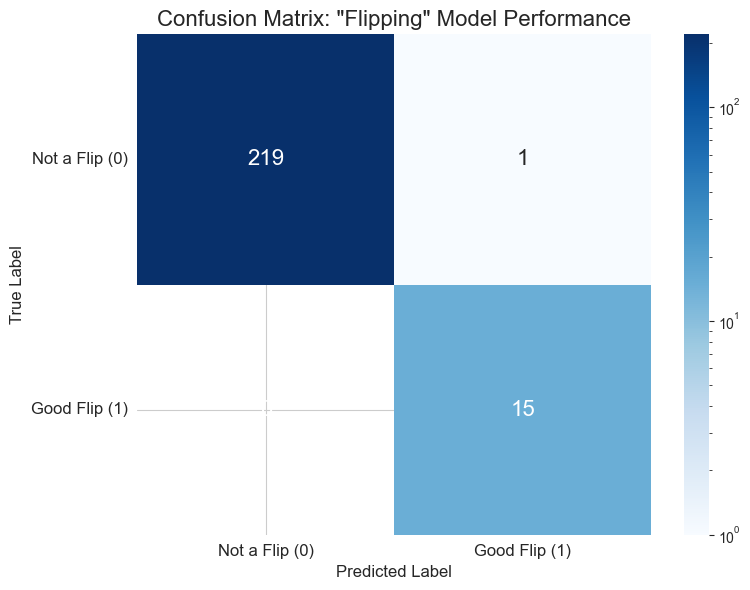

In [146]:
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LogNorm 

cm = confusion_matrix(y_T_val, y_pred)

plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

ax = sns.heatmap(
    cm, 
    annot=True,
    fmt='d',
    cmap='Blues',
    annot_kws={"size": 16},
    norm=LogNorm()
)

ax.set_title('Confusion Matrix: "Flipping" Model Performance', fontsize=16)
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)

ax.xaxis.set_ticklabels(['Not a Flip (0)', 'Good Flip (1)'], fontsize=12)
ax.yaxis.set_ticklabels(['Not a Flip (0)', 'Good Flip (1)'], fontsize=12, rotation=0)

plt.tight_layout()
plt.show()

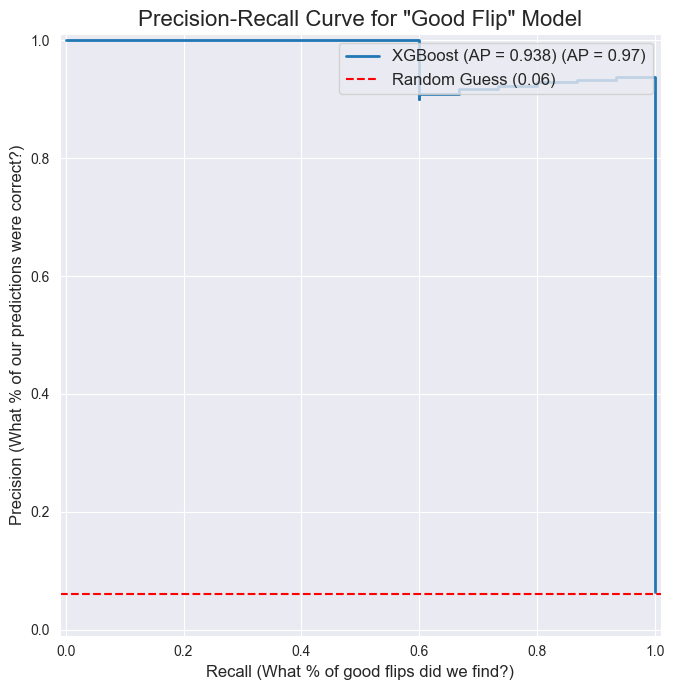

In [147]:
from sklearn.metrics import PrecisionRecallDisplay, average_precision_score

# 1. Set up the plot
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(10, 7))

# 2. Calculate the Average Precision (AP) score
ap_score = average_precision_score(y_T_val, y_pred)

# 3. Plot the PR Curve using the modern display function
display = PrecisionRecallDisplay.from_estimator(
    final_model_class, 
    X_T_val_prepared, 
    y_T_val, 
    name=f'XGBoost (AP = {ap_score:.3f})', 
    ax=ax,
    lw=2
)

# 4. Plot the "dumb" baseline (random guess)
# The baseline is the % of positive samples
baseline = 0.06
ax.axhline(baseline, linestyle='--', color='r', label=f'Random Guess ({baseline:.2f})')

# 5. Set professional labels
ax.set_title('Precision-Recall Curve for "Good Flip" Model', fontsize=16)
ax.set_xlabel('Recall (What % of good flips did we find?)', fontsize=12)
ax.set_ylabel('Precision (What % of our predictions were correct?)', fontsize=12)
ax.legend(loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()

**How to Read This Plot:**

This plot shows the model's performance on a very difficult, imbalanced task.
* **The Red Line (Baseline):** This is a "random guess" model. Its low score (Average Precision ≈ 0.06) shows how hard the problem is.
* **The Blue Line (Our Model):** Our model's curve reaches high into the top-right corner, indicating a high precision and recall simultaneously, which is exactly what we want from it. It achieved an **Average Precision (AP) of 0.97**.

**Takeaway:** 
The model is highly effective at identifying "Good Flip" properties, far surpassing the baseline. This demonstrates that it can reliably prioritize high-potential investments even in a very imbalanced dataset.

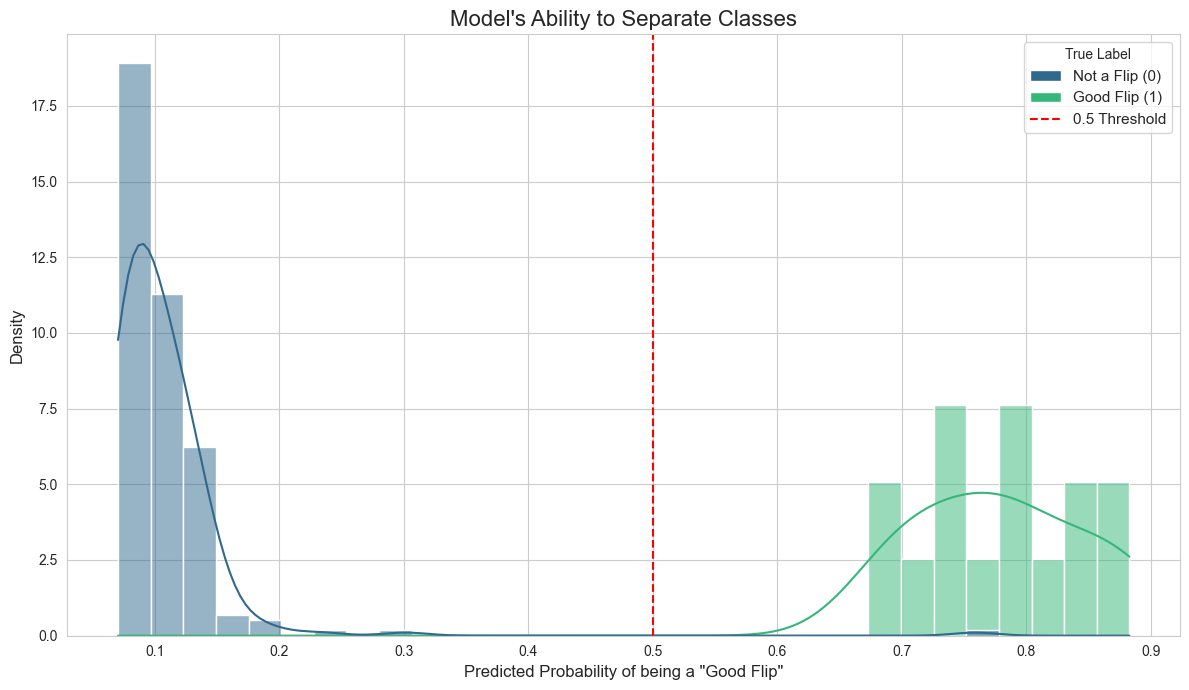

In [148]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

df_viz = pd.DataFrame({
    'True_Label': y_T_val.ravel(), 
    'Predicted_Probability': y_pred_proba.ravel()
})

plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

palette = sns.color_palette('viridis', 2)

sns.histplot(
    data=df_viz, 
    x='Predicted_Probability', 
    hue='True_Label', 
    kde=True,
    stat='density',
    common_norm=False,
    palette=palette
)

plt.axvline(0.5, color='r', linestyle='--') # No 'label' needed here

plt.title('Model\'s Ability to Separate Classes', fontsize=16)
plt.xlabel('Predicted Probability of being a "Good Flip"', fontsize=12)
plt.ylabel('Density', fontsize=12)

legend_elements = [
    Patch(facecolor=palette[0], label='Not a Flip (0)'),
    Patch(facecolor=palette[1], label='Good Flip (1)'),
    Line2D([0], [0], color='r', linestyle='--', label='0.5 Threshold')
]

# Apply the custom legend
plt.legend(handles=legend_elements, title='True Label', loc='upper right', fontsize=11)

plt.tight_layout()
plt.show()

**How to Read This Plot:**

This plot shows how "confident" our model is. It separates all the houses in our validation set into two groups and shows the probability the model gave them.

* **The "Not a Flip" Hump (Blue):** This giant spike on the far left is good. It means that for houses that were *not* good flips, our model was very confident and correctly gave them a probability near 0.

* **The "Good Flip" Hump (Green):** This other curve is the key. It shows that our model also did well in separating *actual* "Good Flips," from the noise. The "hump" is clearly separated and distinct from the blue one.

**Takeaway**
The model clearly separates "Good Flip" and "Not a Flip" properties, showing strong confidence in its predictions. This separation indicates it can reliably distinguish high-potential investments from the rest.


## Feature Importance - which features mattered most?

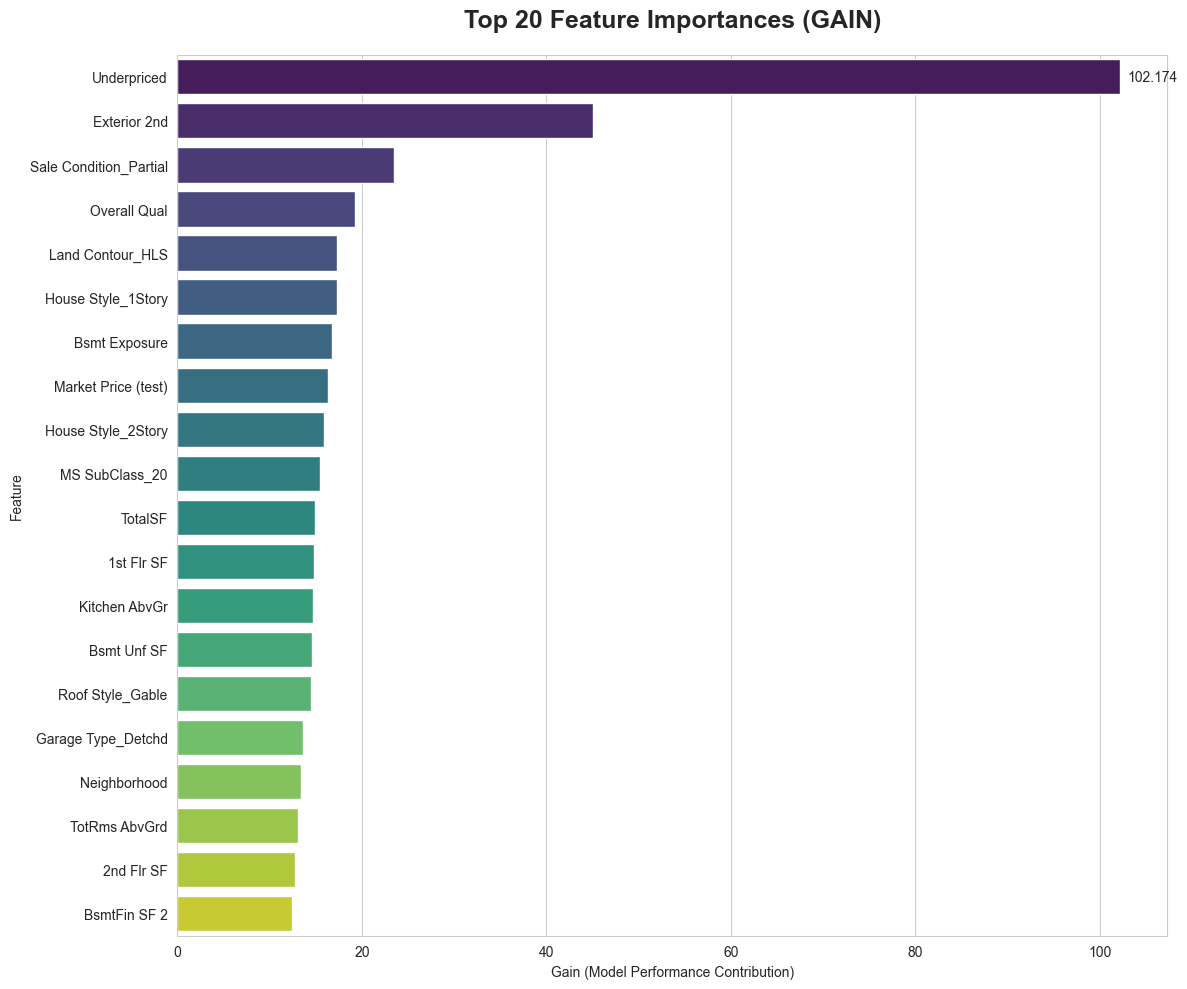

In [162]:
# 1. Extract GAIN importances
# Booster gives raw XGBoost model
booster = final_model_class.get_booster()
importance_dict = booster.get_score(importance_type='gain')

# Convert to DataFrame
imp_df = (
    pd.DataFrame({
        'feature': list(importance_dict.keys()),
        'importance': list(importance_dict.values())
    })
    .sort_values(by='importance', ascending=False)
    .head(20)
)

# 2. Clean labels (optional, matches your pipeline output)
imp_df['clean_feature'] = imp_df['feature'].str.split('__').str[-1]

# 3. Plot with viridis gradient
plt.figure(figsize=(12, 10))
sns.set_style("whitegrid")

ax = sns.barplot(
    data=imp_df,
    x='importance',
    y='clean_feature',
    palette='viridis'
)

# Label bars
ax.bar_label(
    ax.containers[0],
    fmt='%.3f',
    padding=5
)

# Titles & labels
ax.set_title("Top 20 Feature Importances (GAIN)", fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel("Gain (Model Performance Contribution)")
ax.set_ylabel("Feature")

plt.tight_layout()
plt.savefig("feature_importance_gain.png", dpi=300, bbox_inches='tight')
plt.show()

### Feature Importance for Classification

The feature importance plot shows which variables contributed most to the model's predictions. The `Underpriced` feature dominates by a large margin, which is expected given that the target was mathematically derived using this variable. This indicates that the model has effectively learned the logic behind the target (and also illustrates that the final score would be much lower had the target not been mathematical), while other features such as property characteristics, structural details, and intrinsic value provide additional, secondary contributions.

### Takeaway

The model's predictions are strongly driven by the `Underpriced` signal, reflecting the engineered relationship used to define the target. Other features provide supporting information, but the primary driver aligns with the domain-informed derivation, confirming that the model learned the mathematical relationships.
